In [3]:
import matplotlib
import pickle
import photonsoup as fp
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [69]:

FP5_OQ1_ezm=fp.FiberPhotometryCurve(npm_file="/Users/heloiseleblanc/Documents/EZM_FP5_Old_control/FP5_OQ1_EZM_Test_Pho.csv",
  dlc_file="/Users/heloiseleblanc/Desktop/Test_Video_dual_opto_shock_eYFP_m5_recall-006DLC_resnet50_engram_round2_front_fcApr21shuffle1_400000.csv",          anymaze_file="/Users/heloiseleblanc/Documents/EZM_FP5_Ctrl_Bhvr_corrected/FP5_OQ1_OpenArea.csv", offset=9754.6710079999993,
             regress=True, ID='FP5_OQ1_ezm', task='EZM', treatment='aged control',outliers=True)



In [24]:
fp_collection_fc = fp.FiberPhotometryCollection(name='Dual Color EZM')
#

fp_collection_fc.add_curve(FP5_OQ1_ezm)

# fp_collection_fc.batch_data()
#
# fp_collection_fc.batch_behavior(end=1200)

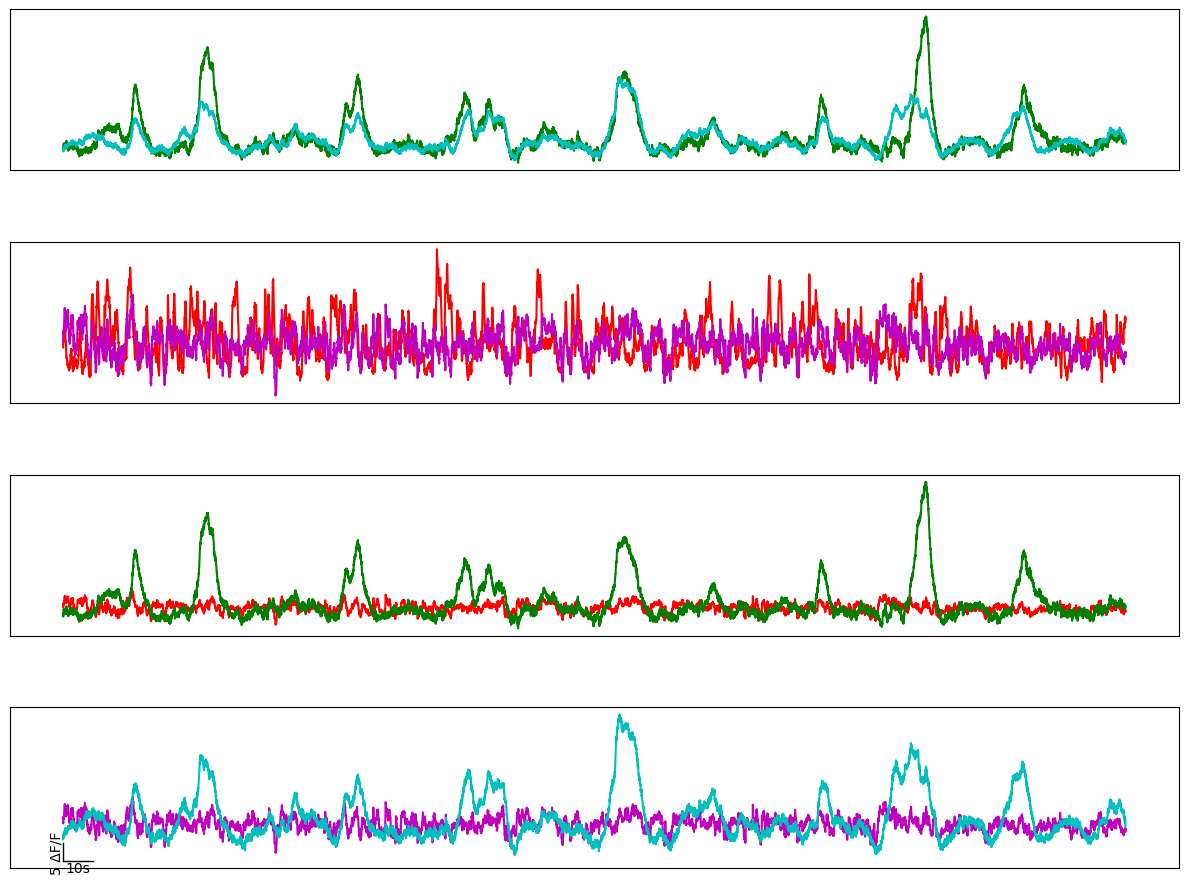

In [22]:
%matplotlib inline
plt.close()

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12.8, 9.6))
x = FP5_OQ1_ezm

# ======================
# PARAMETERS FOR SCALE BARS
# ======================
time_bar_sec = 10        # 5 min scale bar
dff_bar = 2             # ΔF/F scale bar
bar_lw = 1

# Helper to add scale bars
def add_scale_bar(ax, x_start, y_start,
                  time_len, dff_len,
                  time_label, dff_label):
    # horizontal (time)
    ax.plot([x_start, x_start + time_len],
            [y_start, y_start],
            color='k', lw=bar_lw)
    ax.text(x_start + time_len / 2, y_start,
            time_label, ha='center', va='top')

    # vertical (dF/F)
    ax.plot([x_start, x_start],
            [y_start, y_start + dff_len],
            color='k', lw=bar_lw)
    ax.text(x_start, y_start + dff_len / 2,
            dff_label, ha='right', va='center', rotation=90)


# ======================
# PLOTS
# ======================
ax[0].plot(x.Timestamps['2'][3600:14400], x.dff_signals['Region2G'][3600:14400], 'g')
ax[0].plot(x.Timestamps['2'][3600:14400], x.dff_signals['Region3G'][3600:14400], 'c')
# ax[0].set_title('Astrocytes')

ax[1].plot(x.Timestamps['4'][3600:14400], x.dff_signals['Region0R'][3600:14400], 'r')
ax[1].plot(x.Timestamps['4'][3600:14400], x.dff_signals['Region1R'][3600:14400], 'm')
# ax[1].set_title('Neurons')

ax[2].plot(x.Timestamps['4'][3600:14400], x.dff_signals['Region1R'][3600:14400], 'r')
ax[2].plot(x.Timestamps['2'][3600:14400], x.dff_signals['Region2G'][3600:14400], 'g')
# ax[2].set_title('mPFC')
#
ax[3].plot(x.Timestamps['4'][3600:14400], x.dff_signals['Region1R'][3600:14400], 'm')
ax[3].plot(x.Timestamps['2'][3600:14400], x.dff_signals['Region3G'][3600:14400], 'c')
# ax[3].set_title('vCA1')


# ======================
# REMOVE AXES
# ======================
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel('')
    a.set_ylabel('')


# ======================
# ADD SCALE BARS (only once, bottom panel)
# ======================
# choose lower-left corner in data coords
x0 = x.Timestamps['2'][3600]
y0 = ax[3].get_ylim()[0] + 0.1

add_scale_bar(
    ax[3],
    x_start=x0,
    y_start=y0,
    time_len=time_bar_sec,
    dff_len=dff_bar,
    time_label='10s',
    dff_label='5 ΔF/F'
)


plt.subplots_adjust(
    left=0.057,
    bottom=0.057,
    right=0.97,
    top=0.952,
    wspace=0.2,
    hspace=0.445
)

plt.show()


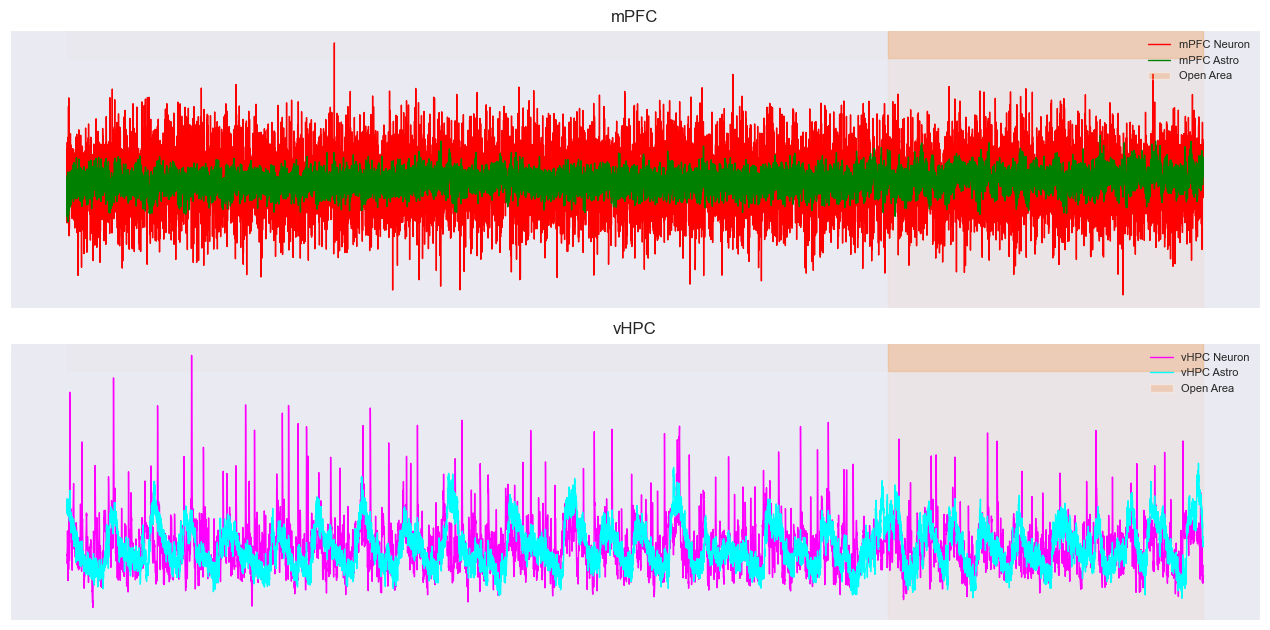

In [17]:
import matplotlib.patches as mpatches
import numpy as np
def _to_np(x):
    """pandas Series -> numpy, else numpy"""
    return x.to_numpy() if hasattr(x, "to_numpy") else np.asarray(x)
def plot_two_combo_panels(curve, NMAX=10800,
                          use_dfz=True,
                          savepath=None):
    """
    Panel A: Region0R (red) + Region2G (green)
    Panel B: Region1R (magenta) + Region3G (cyan)
    Adds struggle bar + light plot shading during struggle.
    """

    # time vectors (clip to NMAX)
    t2 = _to_np(curve.Timestamps["2"][:NMAX])
    t4 = _to_np(curve.Timestamps["4"][:NMAX])

    # signals
    sig = curve.dfz_signals if use_dfz else curve.dff_signals

    y_2G = _to_np(sig["Region2G"][:NMAX])
    y_3G = _to_np(sig["Region3G"][:NMAX])
    y_0R = _to_np(sig["Region0R"][:NMAX])
    y_1R = _to_np(sig["Region1R"][:NMAX])

    # struggle indices (clip)
    on_idx  = np.asarray(curve.behavioral_data["freeze_offsets"], dtype=int)
    off_idx = np.asarray(curve.behavioral_data["freeze_onsets"], dtype=int)

    on_idx  = on_idx[on_idx < NMAX]

    off_idx = off_idx[off_idx < NMAX]


    # map indices -> times for each clock
    on_t2, off_t2 = t2[on_idx], t2[off_idx]
    on_t4, off_t4 = t4[on_idx], t4[off_idx]

    # ---------- plot ----------
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12.8, 6.4), sharex=False)

    # Panel 1: 0R + 2G
    ax[0].plot(t4, y_0R, color="red",   lw=1.0, label="mPFC Neuron")
    ax[0].plot(t2, y_2G, color="green", lw=1.0, label="mPFC Astro")
    ax[0].set_title("mPFC")
    ax[0].legend(loc="upper right", fontsize=8, frameon=False)

    # Panel 2: 1R + 3G
    ax[1].plot(t4, y_1R, color="magenta", lw=1.0, label="vHPC Neuron")
    ax[1].plot(t2, y_3G, color="cyan",    lw=1.0, label="vHPC Astro")
    ax[1].set_title("vHPC")
    ax[1].legend(loc="upper right", fontsize=8, frameon=False)

    # remove ticks/labels (like your original aesthetic)
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.set_xlabel("")
        a.set_ylabel("")

    # IMPORTANT: add shading AFTER plotting so y-lims exist
    add_struggle_bar_and_shade(ax[0], t4, on_t4, off_t4)  # bar/shade aligned to panel clock
    add_struggle_bar_and_shade(ax[1], t4, on_t4, off_t4)

    plt.tight_layout()

    # if savepath is not None:
    #     fig.savefig(savepath, bbox_inches="tight", dpi=600)  # high res
    #     print(f"Saved → {savepath}")

    plt.show()
    return fig, ax

def add_struggle_bar_and_shade(ax, time, onsets_t, offsets_t,
                              bar_frac=0.10,
                              bar_color="#e6e6e6",
                              struggle_color="#f4a261",
                              bar_alpha=0.25,
                              shade_alpha=0.08,
                              z_bar=0,
                              z_shade=0,
                              add_legend=True):
    """
    1) Add a thin top bar showing struggle periods.
    2) Lightly shade the full plot area during struggle (subtle).
    3) Optionally add legend handles describing shading.
    """
    time = _to_np(time).astype(float)
    onsets_t = _to_np(onsets_t).astype(float)
    offsets_t = _to_np(offsets_t).astype(float)

    if time.size < 0:
        return

    xmin, xmax = float(time[0]), float(time[-1])

    # Current y-lims (must be set by plotting first)
    y0, y1 = ax.get_ylim()
    yr = y1 - y0
    if yr == 0:
        yr = 1.0

    # --- shade whole plot during struggle (subtle) ---
    for on, off in zip(onsets_t, offsets_t):
        if off < xmin or on > xmax:
            continue
        on = max(on, xmin)
        off = min(off, xmax)
        ax.axvspan(on, off, color=struggle_color, alpha=shade_alpha, zorder=z_shade)

    # --- top bar ---
    bar_y0 = y1 - bar_frac * yr
    bar_y1 = y1

    # background strip
    ax.axvspan(
        xmin, xmax,
        ymin=(bar_y0 - y0)/yr, ymax=(bar_y1 - y0)/yr,
        color=bar_color, alpha=bar_alpha, zorder=z_bar
    )

    # struggle blocks in the bar
    for on, off in zip(onsets_t, offsets_t):
        if off < xmin or on > xmax:
            continue
        on = max(on, xmin)
        off = min(off, xmax)
        ax.axvspan(
            on, off,
            ymin=(bar_y0 - y0)/yr, ymax=(bar_y1 - y0)/yr,
            color=struggle_color, alpha=0.35, zorder=z_bar+1
        )

    # --- add legend proxies ---
    if add_legend:

        bar_patch = mpatches.Patch(
            facecolor=struggle_color,
            alpha=0.35,
            label="Open Area"
        )

        handles, labels = ax.get_legend_handles_labels()

        # only add once
        if "Open (shaded)" not in labels:
            handles += [bar_patch]
            ax.legend(handles=handles, loc="upper right", fontsize=8, frameon=False)

    # restore original y-lims
    ax.set_ylim(y0, y1)

fig, ax = plot_two_combo_panels(
    curve=FP4_OK1_ezm,
    NMAX=160000,
    use_dfz=True,
    savepath="ADDPATHHERE"
)


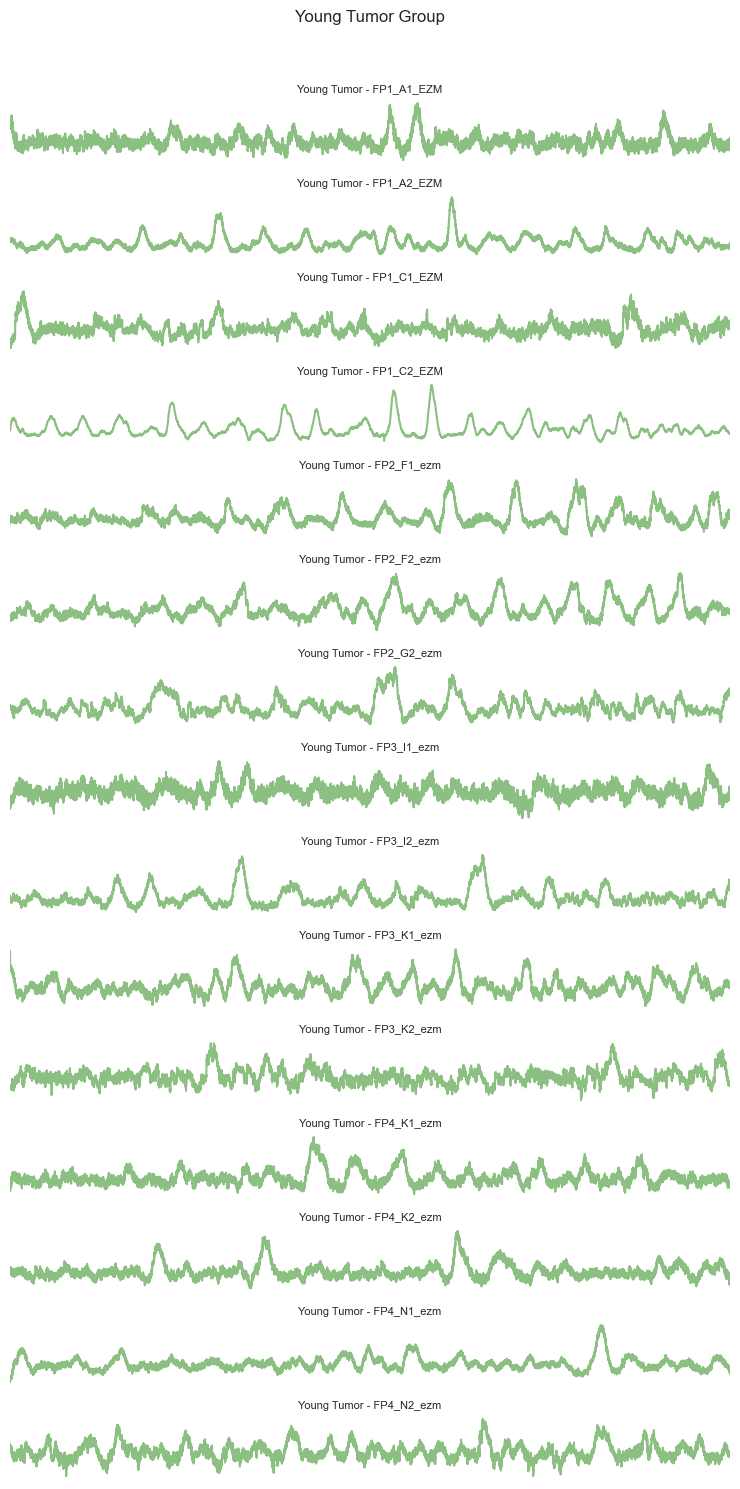

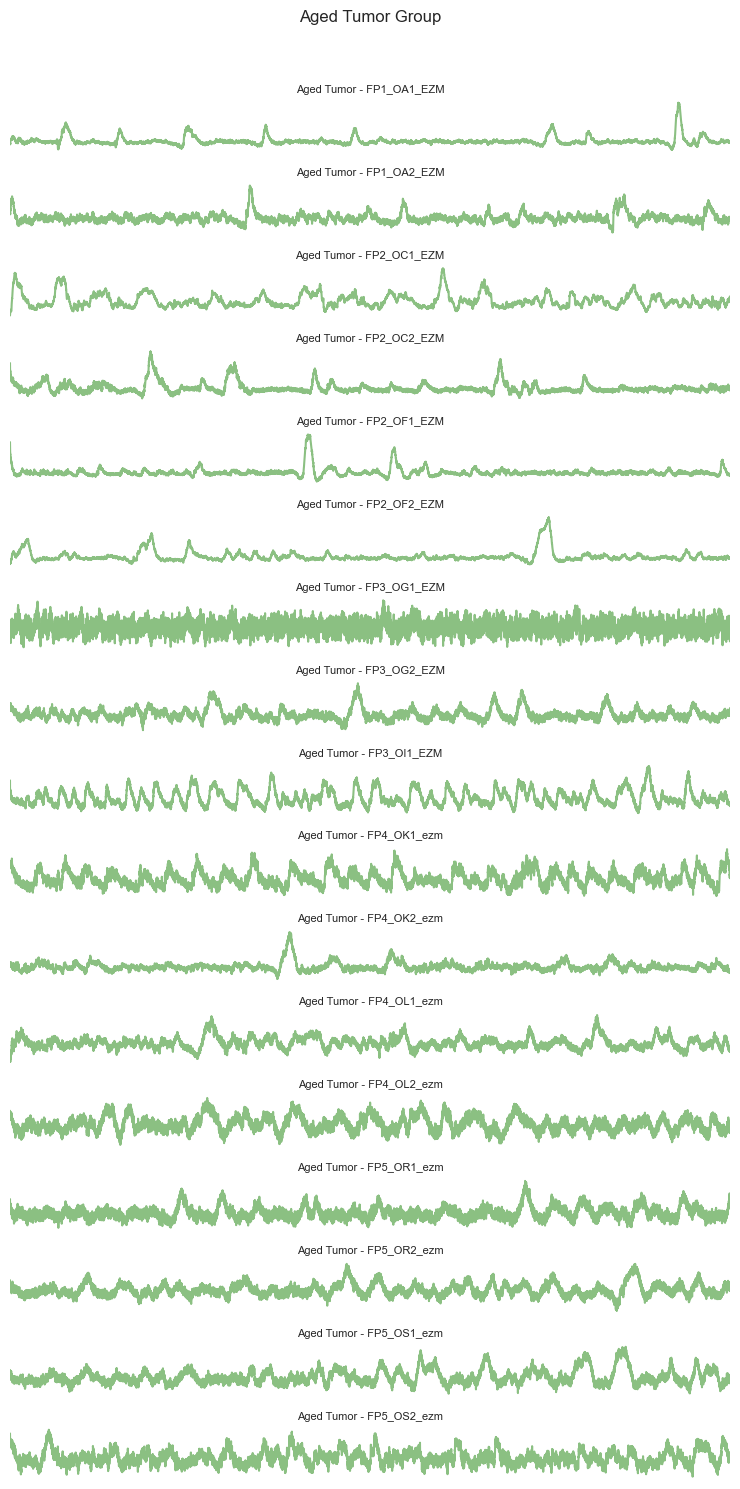

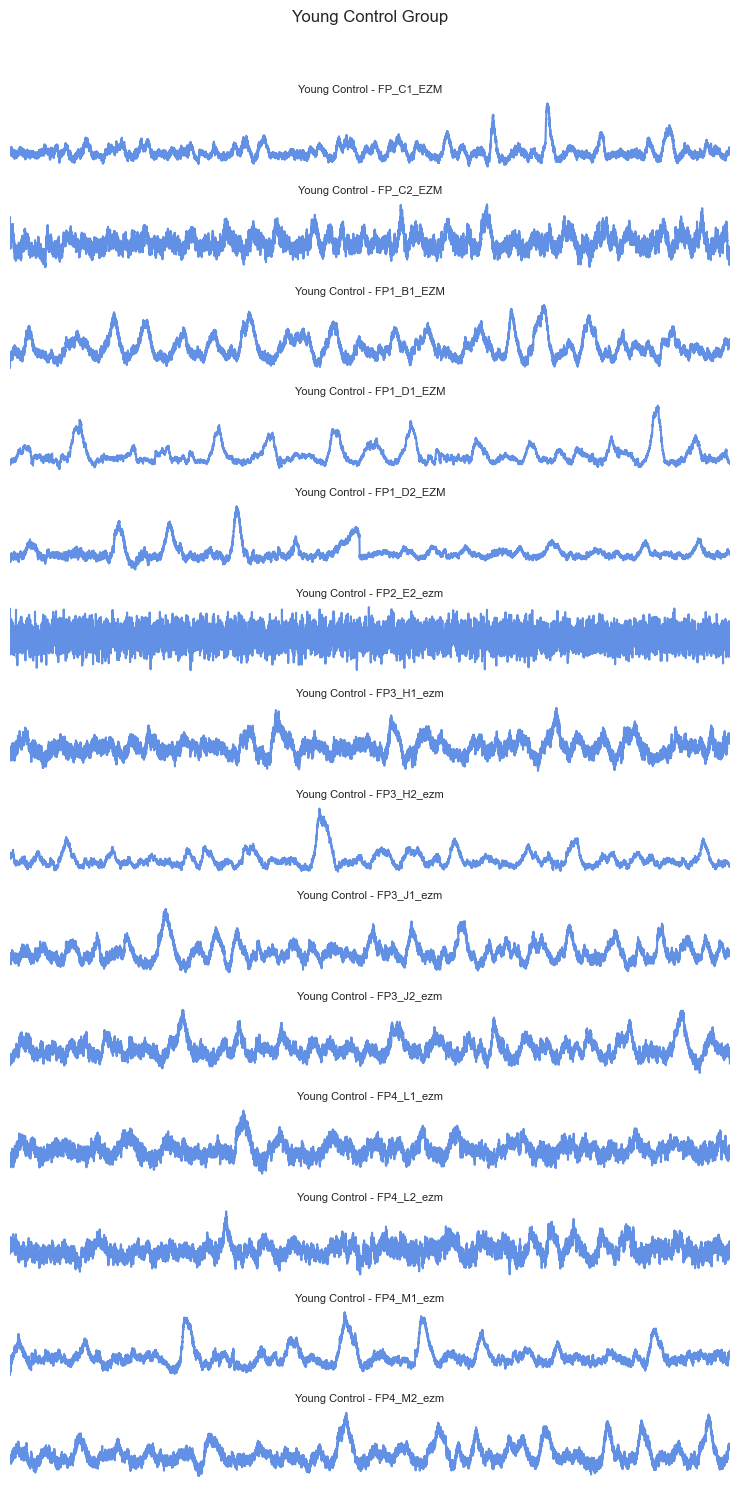

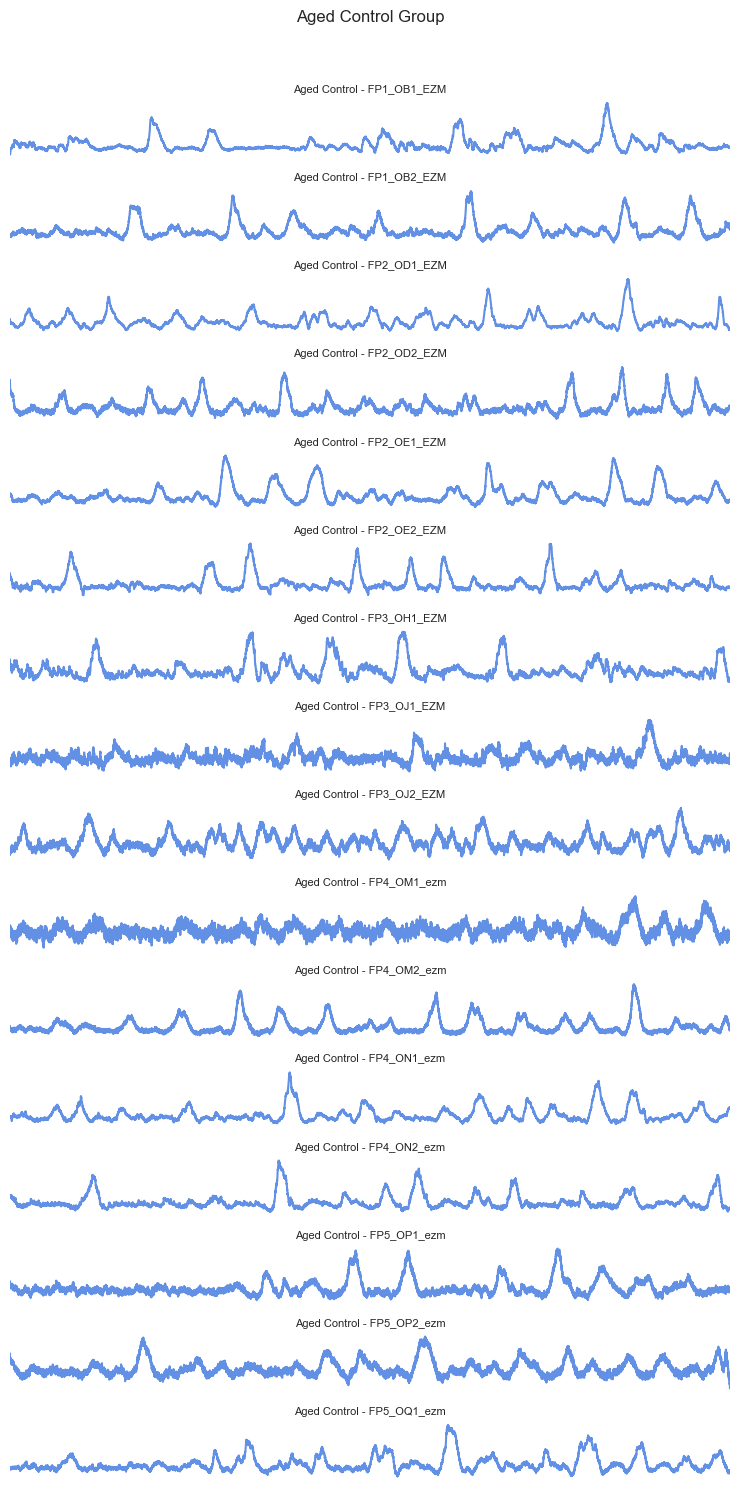

In [275]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare groups
young_tumor_curves = [curve for curve in fp_collection_fc.curves.values() if curve.treatment == 'young tumor']
aged_tumor_curves = [curve for curve in fp_collection_fc.curves.values() if curve.treatment == 'aged tumor']
young_control_curves = [curve for curve in fp_collection_fc.curves.values() if curve.treatment == 'young control']
aged_control_curves = [curve for curve in fp_collection_fc.curves.values() if curve.treatment == 'aged control']

# Step 1: Find the longest curve length
all_lengths = [len(curve["Region2G"]) for curve in fp_collection_fc.curves.values()]
max_length = max(all_lengths)

# --- Tumor Figure ---
fig_ytumor, axs_ytumor = plt.subplots(len(young_tumor_curves), 1, sharex='col', figsize=(len(young_tumor_curves)/2,len(young_tumor_curves)))
for i, (curve, ax) in enumerate(zip(young_tumor_curves, axs_ytumor)):
    y_data = curve.dfz_signals["Region3G"]
    x_data = np.linspace(0, max_length, len(y_data))  # Stretch to full width
    ax.plot(x_data, y_data, color='#8bc082')
    # ax.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Dashed line at y=0
    ax.axis('off')
    ax.set_title(f'Young Tumor - {curve.ID}', fontsize=8)
    ax.set_xlim(0, max_length)


fig_ytumor.suptitle('Young Tumor Group', fontsize=12, y=0.99)  # ✅ Move title up
fig_ytumor.tight_layout(rect=[0, 0, 1, 0.97])  # ✅ Leave space at top

fig_atumor, axs_atumor = plt.subplots(len(aged_tumor_curves), 1, sharex='col', figsize=(len(young_tumor_curves)/2,len(young_tumor_curves)))
for i, (curve, ax) in enumerate(zip(aged_tumor_curves, axs_atumor)):
    y_data = curve.dfz_signals["Region3G"]
    x_data = np.linspace(0, max_length, len(y_data))  # Stretch to full width
    ax.plot(x_data, y_data, color='#8bc082')
    # ax.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Dashed line at y=0
    ax.axis('off')
    ax.set_title(f'Aged Tumor - {curve.ID}', fontsize=8)
    ax.set_xlim(0, max_length)


fig_atumor.suptitle('Aged Tumor Group', fontsize=12, y=0.99)  # ✅ Move title up
fig_atumor.tight_layout(rect=[0, 0, 1, 0.97])  # ✅ Leave space at top
# --- Control Figure ---
fig_ycontrol, axs_ycontrol = plt.subplots(len(young_control_curves), 1, sharex='col', figsize=(len(young_tumor_curves)/2,len(young_tumor_curves)),)
for i, (curve, ax) in enumerate(zip(young_control_curves, axs_ycontrol)):
    y_data = curve.dfz_signals["Region3G"]
    x_data = np.linspace(0, max_length, len(y_data))  # Stretch to full width
    ax.plot(x_data, y_data, color='#6290e5')
    # ax.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Dashed line at y=0
    ax.axis('off')
    ax.set_title(f'Young Control - {curve.ID}', fontsize=8)
    ax.set_xlim(1, max_length)

fig_ycontrol.suptitle('Young Control Group', fontsize=12, y=0.99)  # ✅ Move title up
fig_ycontrol.tight_layout(rect=[0, 0, 1, 0.97])  # ✅ Leave space at top
plt.show()

fig_acontrol, axs_acontrol = plt.subplots(len(aged_control_curves), 1, sharex='col', figsize=(len(young_tumor_curves)/2,len(young_tumor_curves)))
for i, (curve, ax) in enumerate(zip(aged_control_curves, axs_acontrol)):
    y_data = curve.dfz_signals["Region3G"]
    x_data = np.linspace(0, max_length, len(y_data))  # Stretch to full width
    ax.plot(x_data, y_data, color='#6290e5')
    # ax.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Dashed line at y=0
    ax.axis('off')
    ax.set_title(f'Aged Control - {curve.ID}', fontsize=8)
    ax.set_xlim(1, max_length)

fig_acontrol.suptitle('Aged Control Group', fontsize=12, y=0.99)  # ✅ Move title up
fig_acontrol.tight_layout(rect=[0, 0, 1, 0.97])  # ✅ Leave space at top
plt.show()

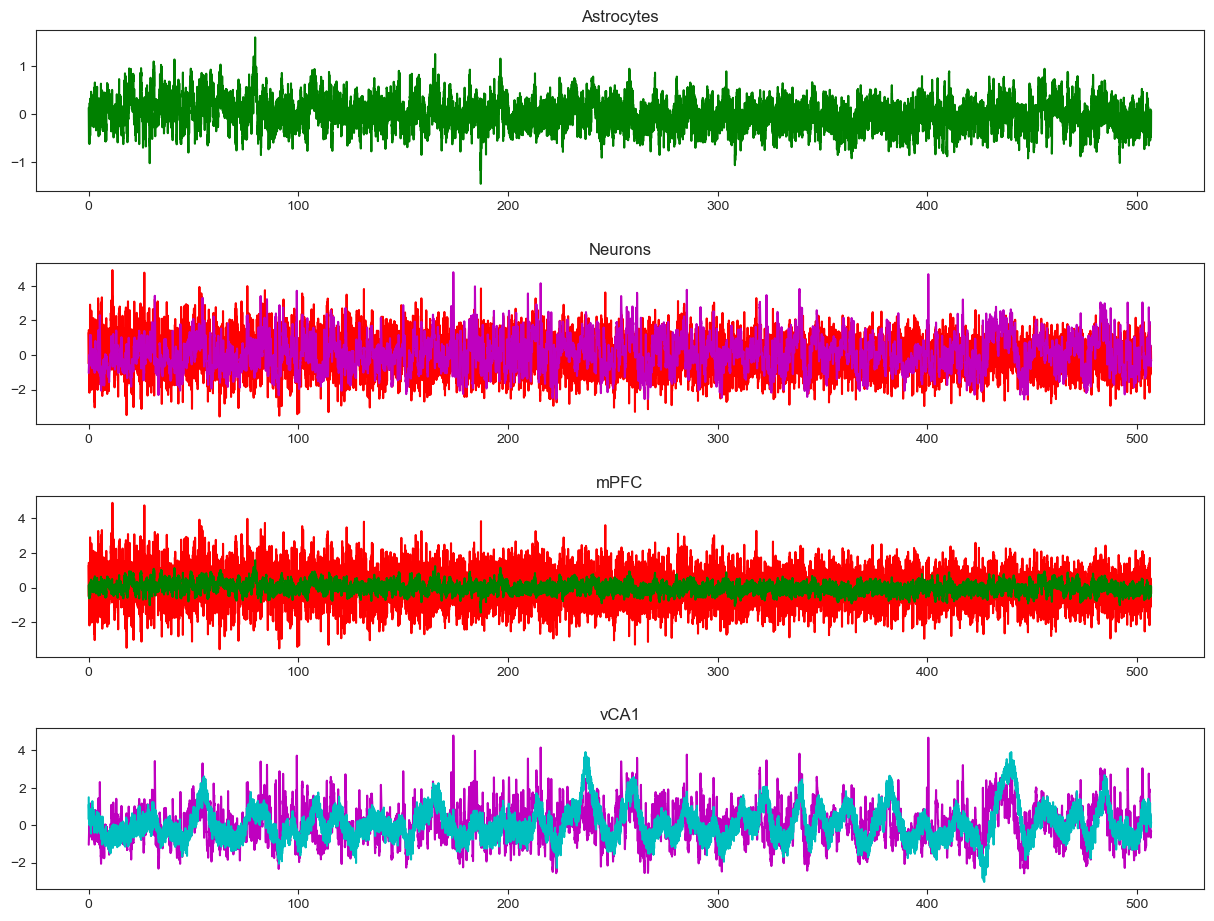

In [62]:
%matplotlib inline
plt.close()
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12.8, 9.6))
x=FP5_OR2_ezm
ax[0].plot(x.Timestamps['2'], x.dfz_signals['Region2G'], 'g')

# ax[0].plot(x.Timestamps['2'], x.dfz_signals['Region3G'], 'c')

#
ax[0].set_title('Astrocytes')
ax[1].plot(x.Timestamps['4'], x.dfz_signals['Region0R'], 'r')

ax[1].plot(x.Timestamps['4'], x.dfz_signals['Region1R'], 'm')

ax[1].set_title('Neurons')



# ax[0].plot(x.Timestamps['4'], x.raw_signal['Region3G'], 'r')

ax[2].plot(x.Timestamps['4'], x.dfz_signals['Region0R'], 'r')

ax[2].plot(x.Timestamps['2'], x.dfz_signals['Region2G'], 'g')
ax[2].set_title('mPFC')

ax[3].plot(x.Timestamps['4'], x.dfz_signals['Region1R'], 'm')
ax[3].plot(x.Timestamps['2'], x.dfz_signals['Region3G'], 'c')
ax[3].set_title('vCA1')

#plt.subplot_tool()
plt.subplots_adjust(left=0.057,
                   bottom=0.057,
                    right=0.97,
                    top=0.952,
                   wspace=0.2,
                    hspace=0.445)
plt.show()


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.ndimage as ndi

def multi_event_eta(self, task, treatment, region, events=None, window=3, ci='tci',
                    sig_duration=8, a=0.05, ax=None, smooth_sigma_s=None, **kwargs):
    """
    Event-triggered average with optional Gaussian smoothing.
    """
    # ~30 Hz sampling across 1.5*window
    number_of_indices = int(window * 1.5 * 30)
    time = np.linspace(-window / 2, window, number_of_indices)

    # choose correct timestamp index
    time_idx = "2" if "G" in region else "4"

    def event_interpolation(curve, events_):
        within_eta_ = np.zeros((len(events_), number_of_indices))
        interp = scipy.interpolate.interp1d(
            curve.Timestamps[time_idx],
            curve.dfz_signals[region],
            kind='cubic',
            bounds_error=False,
            fill_value=np.nan
        )
        for i, event in enumerate(events_):
            time_period = np.linspace(event - (window / 2), event + window, number_of_indices)
            within_eta_[i] = interp(time_period)
        trace = np.nanmean(within_eta_, axis=0)

        # Gaussian smoothing if requested
        if smooth_sigma_s is not None and smooth_sigma_s > 0:
            samp_hz = number_of_indices / (1.5 * window)
            sigma = smooth_sigma_s * samp_hz
            trace = ndi.gaussian_filter1d(trace, sigma=sigma, mode="nearest")

        return trace

    # Collect curves
    curves = self[task, treatment]

    # Expand events properly
    if len(events) == 1:
        events = events * len(curves)
    else:
        valid_indices = [i for i, e in enumerate(events) if len(e) > 0]
        curves = [curves[i] for i in valid_indices]
        events = [events[i] for i in valid_indices]

    # Pre-allocate ETA array
    eta_array = np.zeros((len(events), number_of_indices))
    for j, curve in enumerate(curves):
        eta_array[j] = event_interpolation(curve, events[j])

    # Average across curves
    average_trace = np.average(eta_array, axis=0)

    # Confidence intervals
    confidence_level = 1 - a
    if ci == 'tci':
        c_int = self.tci(eta_array, cl=confidence_level)
    elif ci == 'bci':
        c_int = self.bci(eta_array, cl=confidence_level, num_samples=1000)
    else:
        raise ValueError("Confidence interval options are 'tci' or 'bci'")

    # Find significant indices
    start_indices = self.eta_significance(c_int, sig_duration=sig_duration)

    # Plot
    if ax is None:
        fig, ax = plt.subplots()

    fill_color = kwargs.pop('fill_color', 'blue')
    opacity = kwargs.pop('alpha', 0.3)
    ax.plot(time, average_trace, linewidth=1.5,**kwargs)
    ax.fill_between(time, c_int[0, :], c_int[1, :], color=fill_color, alpha=opacity,edgecolor="none")

    # Mark significance
    # y_height = ax.get_ylim()[1] * 0.97
    # for start_index in start_indices:
    #     end_index = start_index + sig_duration
    #     try:
    #         ax.hlines(y=y_height, xmin=time[start_index], xmax=time[end_index], colors='r')
    #     except IndexError:
    #         end_index = len(time) - 1
    #         print(f"Warning: Adjusted end index to {end_index} due to out-of-bounds error.")
    #         ax.hlines(y=y_height, xmin=time[start_index], xmax=time[end_index], colors='r')

    return (fig, ax, eta_array) if ax is None else (ax, eta_array)


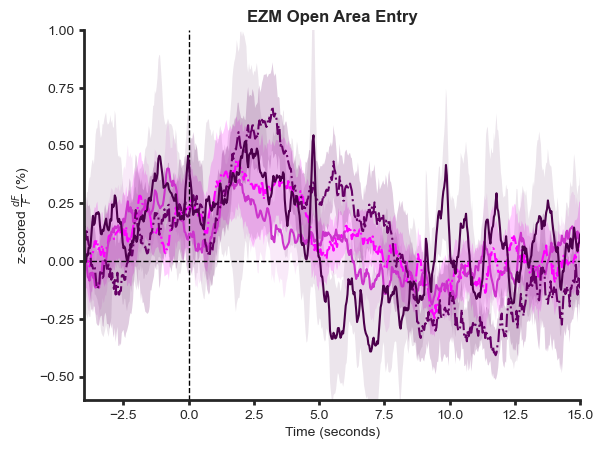

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.close('all')
fig, ax = plt.subplots()

%matplotlib inline

sns.set_style("ticks")
#
# multi_event_eta(fp_collection_fc,task='EZM', treatment='young control', region='Region3G', events=[
# FP_C1_EZM.Timestamps['2'][FP_C1_EZM.behavioral_data['freeze_offsets']],
# FP_C2_EZM.Timestamps['2'][FP_C2_EZM.behavioral_data['freeze_offsets']],
# FP1_B1_EZM.Timestamps['2'][FP1_B1_EZM.behavioral_data['freeze_offsets']],
# FP1_D1_EZM.Timestamps['2'][FP1_D1_EZM.behavioral_data['freeze_offsets']],
# FP1_D2_EZM.Timestamps['2'][FP1_D2_EZM.behavioral_data['freeze_offsets']],
# [],
# FP3_H1_ezm.Timestamps['2'][FP3_H1_ezm.behavioral_data['freeze_offsets']],
# FP3_H2_ezm.Timestamps['2'][FP3_H2_ezm.behavioral_data['freeze_offsets']],
# FP3_J1_ezm.Timestamps['2'][FP3_J1_ezm.behavioral_data['freeze_offsets']],
# FP3_J2_ezm.Timestamps['2'][FP3_J2_ezm.behavioral_data['freeze_offsets']],
#     FP4_L1_ezm.Timestamps['2'][FP4_L1_ezm.behavioral_data['freeze_offsets']],
#     FP4_L2_ezm.Timestamps['2'][FP4_L2_ezm.behavioral_data['freeze_offsets']],
#     FP4_M1_ezm.Timestamps['2'][FP4_M1_ezm.behavioral_data['freeze_offsets']],
#     FP4_M2_ezm.Timestamps['2'][FP4_M2_ezm.behavioral_data['freeze_offsets']],
# ], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#00ffff',linestyle='-.',fill_color='#00ffff',alpha=0.2,smooth_sigma_s=0.1)

multi_event_eta(fp_collection_fc,task='EZM', treatment='young control', region='Region1R', events=[
    FP_C1_EZM.Timestamps['4'][FP_C1_EZM.behavioral_data['freeze_offsets']],
    FP_C2_EZM.Timestamps['4'][FP_C2_EZM.behavioral_data['freeze_offsets']],
    FP1_B1_EZM.Timestamps['4'][FP1_B1_EZM.behavioral_data['freeze_offsets']],
    FP1_D1_EZM.Timestamps['4'][FP1_D1_EZM.behavioral_data['freeze_offsets']],
    FP1_D2_EZM.Timestamps['4'][FP1_D2_EZM.behavioral_data['freeze_offsets']],
    [],
    FP3_H1_ezm.Timestamps['4'][FP3_H1_ezm.behavioral_data['freeze_offsets']],
    FP3_H2_ezm.Timestamps['4'][FP3_H2_ezm.behavioral_data['freeze_offsets']],
    FP3_J1_ezm.Timestamps['4'][FP3_J1_ezm.behavioral_data['freeze_offsets']],
    FP3_J2_ezm.Timestamps['4'][FP3_J2_ezm.behavioral_data['freeze_offsets']],
    FP4_L1_ezm.Timestamps['4'][FP4_L1_ezm.behavioral_data['freeze_offsets']],
    FP4_L2_ezm.Timestamps['4'][FP4_L2_ezm.behavioral_data['freeze_offsets']],
    FP4_M1_ezm.Timestamps['4'][FP4_M1_ezm.behavioral_data['freeze_offsets']],
    FP4_M2_ezm.Timestamps['4'][FP4_M2_ezm.behavioral_data['freeze_offsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#ff00ff',linestyle='-.',fill_color='#ff00ff',alpha=0.2)

# multi_event_eta(fp_collection_fc,task='EZM', treatment='young tumor', region='Region3G', events=[
#     FP1_A1_EZM.Timestamps['2'][FP1_A1_EZM.behavioral_data['freeze_offsets']],
#     FP1_A2_EZM.Timestamps['2'][FP1_A2_EZM.behavioral_data['freeze_offsets']],
#     FP1_C1_EZM.Timestamps['2'][FP1_C1_EZM.behavioral_data['freeze_offsets']],
#     FP1_C2_EZM.Timestamps['2'][FP1_C2_EZM.behavioral_data['freeze_offsets']],
#     FP2_F1_ezm.Timestamps['2'][FP2_F1_ezm.behavioral_data['freeze_offsets']],
#     FP2_F2_ezm.Timestamps['2'][FP2_F2_ezm.behavioral_data['freeze_offsets']],
#     FP2_G2_ezm.Timestamps['2'][FP2_G2_ezm.behavioral_data['freeze_offsets']],
#     FP3_I1_ezm.Timestamps['2'][FP3_I1_ezm.behavioral_data['freeze_offsets']],
#     FP3_I2_ezm.Timestamps['2'][FP3_I2_ezm.behavioral_data['freeze_offsets']],
#     FP3_K1_ezm.Timestamps['2'][FP3_K1_ezm.behavioral_data['freeze_offsets']],
#     FP3_K2_ezm.Timestamps['2'][FP3_K2_ezm.behavioral_data['freeze_offsets']],
#     FP4_K1_ezm.Timestamps['2'][FP4_K1_ezm.behavioral_data['freeze_offsets']],
#     FP4_K2_ezm.Timestamps['2'][FP4_K2_ezm.behavioral_data['freeze_offsets']],
#     FP4_N1_ezm.Timestamps['2'][FP4_N1_ezm.behavioral_data['freeze_offsets']],
#     FP4_N2_ezm.Timestamps['2'][FP4_N2_ezm.behavioral_data['freeze_offsets']],
# ], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#00b3b3',fill_color='#00b3b3',alpha=0.1,smooth_sigma_s=0.1)

multi_event_eta(fp_collection_fc,task='EZM', treatment='young tumor', region='Region1R', events=[
    FP1_A1_EZM.Timestamps['4'][FP1_A1_EZM.behavioral_data['freeze_offsets']],
    FP1_A2_EZM.Timestamps['4'][FP1_A2_EZM.behavioral_data['freeze_offsets']],
    FP1_C1_EZM.Timestamps['4'][FP1_C1_EZM.behavioral_data['freeze_offsets']],
    FP1_C2_EZM.Timestamps['4'][FP1_C2_EZM.behavioral_data['freeze_offsets']],
    FP2_F1_ezm.Timestamps['4'][FP2_F1_ezm.behavioral_data['freeze_offsets']],
    FP2_F2_ezm.Timestamps['4'][FP2_F2_ezm.behavioral_data['freeze_offsets']],
    FP2_G2_ezm.Timestamps['4'][FP2_G2_ezm.behavioral_data['freeze_offsets']],
    FP3_I1_ezm.Timestamps['4'][FP3_I1_ezm.behavioral_data['freeze_offsets']],
    FP3_I2_ezm.Timestamps['4'][FP3_I2_ezm.behavioral_data['freeze_offsets']],
    FP3_K1_ezm.Timestamps['4'][FP3_K1_ezm.behavioral_data['freeze_offsets']],
    FP3_K2_ezm.Timestamps['4'][FP3_K2_ezm.behavioral_data['freeze_offsets']],
    FP4_K1_ezm.Timestamps['2'][FP4_K1_ezm.behavioral_data['freeze_offsets']],
    FP4_K2_ezm.Timestamps['2'][FP4_K2_ezm.behavioral_data['freeze_offsets']],
    FP4_N1_ezm.Timestamps['2'][FP4_N1_ezm.behavioral_data['freeze_offsets']],
    FP4_N2_ezm.Timestamps['2'][FP4_N2_ezm.behavioral_data['freeze_offsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#cc33cc',fill_color='#cc33cc',alpha=0.1)


# multi_event_eta(fp_collection_fc,
#     task='EZM', treatment='aged control', region='Region3G',
#     events=[
#         FP1_OB1_EZM.Timestamps['2'][FP1_OB1_EZM.behavioral_data['freeze_offsets']],
#         FP1_OB2_EZM.Timestamps['2'][FP1_OB2_EZM.behavioral_data['freeze_offsets']],
#         FP2_OD1_EZM.Timestamps['2'][FP2_OD1_EZM.behavioral_data['freeze_offsets']],
#         FP2_OD2_EZM.Timestamps['2'][FP2_OD2_EZM.behavioral_data['freeze_offsets']],
#         FP2_OE1_EZM.Timestamps['2'][FP2_OE1_EZM.behavioral_data['freeze_offsets']],
#         FP2_OE2_EZM.Timestamps['2'][FP2_OE2_EZM.behavioral_data['freeze_offsets']],
#         FP3_OH1_EZM.Timestamps['2'][FP3_OH1_EZM.behavioral_data['freeze_offsets']],
#         FP3_OJ1_EZM.Timestamps['2'][FP3_OJ1_EZM.behavioral_data['freeze_offsets']],
#         FP3_OJ2_EZM.Timestamps['2'][FP3_OJ2_EZM.behavioral_data['freeze_offsets']],
#         FP4_OM1_ezm.Timestamps['2'][FP4_OM1_ezm.behavioral_data['freeze_offsets']],
#         FP4_OM2_ezm.Timestamps['2'][FP4_OM2_ezm.behavioral_data['freeze_offsets']],
#         FP4_ON1_ezm.Timestamps['2'][FP4_ON1_ezm.behavioral_data['freeze_offsets']],
#         FP4_ON2_ezm.Timestamps['2'][FP4_ON2_ezm.behavioral_data['freeze_offsets']],
#         FP5_OP1_ezm.Timestamps['2'][FP5_OP1_ezm.behavioral_data['freeze_offsets']],
#         FP5_OP2_ezm.Timestamps['2'][FP5_OP2_ezm.behavioral_data['freeze_offsets']],
#         FP5_OQ1_ezm.Timestamps['2'][FP5_OQ1_ezm.behavioral_data['freeze_offsets']],
#     ],
#     window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#006d6d', linestyle='-.', fill_color='#006d6d', alpha=0.2,smooth_sigma_s=0.1
# )
# # Control - Region1R
multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged control', region='Region1R',
    events=[
        FP1_OB1_EZM.Timestamps['4'][FP1_OB1_EZM.behavioral_data['freeze_offsets']],
        FP1_OB2_EZM.Timestamps['4'][FP1_OB2_EZM.behavioral_data['freeze_offsets']],
        FP2_OD1_EZM.Timestamps['4'][FP2_OD1_EZM.behavioral_data['freeze_offsets']],
        FP2_OD2_EZM.Timestamps['4'][FP2_OD2_EZM.behavioral_data['freeze_offsets']],
        FP2_OE1_EZM.Timestamps['4'][FP2_OE1_EZM.behavioral_data['freeze_offsets']],
        FP2_OE2_EZM.Timestamps['4'][FP2_OE2_EZM.behavioral_data['freeze_offsets']],
        FP3_OH1_EZM.Timestamps['4'][FP3_OH1_EZM.behavioral_data['freeze_offsets']],
        FP3_OJ1_EZM.Timestamps['4'][FP3_OJ1_EZM.behavioral_data['freeze_offsets']],
        FP3_OJ2_EZM.Timestamps['4'][FP3_OJ2_EZM.behavioral_data['freeze_offsets']],
        FP4_OM1_ezm.Timestamps['4'][FP4_OM1_ezm.behavioral_data['freeze_offsets']],
        FP4_OM2_ezm.Timestamps['4'][FP4_OM2_ezm.behavioral_data['freeze_offsets']],
        FP4_ON1_ezm.Timestamps['4'][FP4_ON1_ezm.behavioral_data['freeze_offsets']],
        FP4_ON2_ezm.Timestamps['4'][FP4_ON2_ezm.behavioral_data['freeze_offsets']],
        FP5_OP1_ezm.Timestamps['4'][FP5_OP1_ezm.behavioral_data['freeze_offsets']],
        FP5_OP2_ezm.Timestamps['4'][FP5_OP2_ezm.behavioral_data['freeze_offsets']],
        FP5_OQ1_ezm.Timestamps['4'][FP5_OQ1_ezm.behavioral_data['freeze_offsets']],
    ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#660066', linestyle='-.', fill_color='#660066', alpha=0.2
)
#
# #
#
# # Tumor - Region3G
# multi_event_eta(fp_collection_fc,
#     task='EZM', treatment='aged tumor', region='Region3G',
#     events=[[],[],
#         FP2_OC1_EZM.Timestamps['2'][FP2_OC1_EZM.behavioral_data['freeze_offsets']],
#         FP2_OC2_EZM.Timestamps['2'][FP2_OC2_EZM.behavioral_data['freeze_offsets']],
#         FP2_OF1_EZM.Timestamps['2'][FP2_OF1_EZM.behavioral_data['freeze_offsets']],
#         FP2_OF2_EZM.Timestamps['2'][FP2_OF2_EZM.behavioral_data['freeze_offsets']],
#         [],
#         FP3_OG2_EZM.Timestamps['2'][FP3_OG2_EZM.behavioral_data['freeze_offsets']],
#         FP3_OI1_EZM.Timestamps['2'][FP3_OI1_EZM.behavioral_data['freeze_offsets']],
#         FP4_OK1_ezm.Timestamps['2'][FP4_OK1_ezm.behavioral_data['freeze_offsets']],
#         FP4_OK2_ezm.Timestamps['2'][FP4_OK2_ezm.behavioral_data['freeze_offsets']],
#         FP4_OL1_ezm.Timestamps['2'][FP4_OL1_ezm.behavioral_data['freeze_offsets']],
#         FP4_OL2_ezm.Timestamps['2'][FP4_OL2_ezm.behavioral_data['freeze_offsets']],
#         FP5_OR1_ezm.Timestamps['2'][FP5_OR1_ezm.behavioral_data['freeze_offsets']],
#         FP5_OR2_ezm.Timestamps['2'][FP5_OR2_ezm.behavioral_data['freeze_offsets']],
#         FP5_OS1_ezm.Timestamps['2'][FP5_OS1_ezm.behavioral_data['freeze_offsets']],
#         FP5_OS2_ezm.Timestamps['2'][FP5_OS2_ezm.behavioral_data['freeze_offsets']]
#     ],
#     window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#004d66', fill_color='#004d66', alpha=0.1
# ,smooth_sigma_s=0.1)
# # Tumor - Region1R
multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged tumor', region='Region1R',
    events=[[],[],
        FP2_OC1_EZM.Timestamps['4'][FP2_OC1_EZM.behavioral_data['freeze_offsets']],
        FP2_OC2_EZM.Timestamps['4'][FP2_OC2_EZM.behavioral_data['freeze_offsets']],
        FP2_OF1_EZM.Timestamps['4'][FP2_OF1_EZM.behavioral_data['freeze_offsets']],
        FP2_OF2_EZM.Timestamps['4'][FP2_OF2_EZM.behavioral_data['freeze_offsets']],
        [],
        FP3_OG2_EZM.Timestamps['4'][FP3_OG2_EZM.behavioral_data['freeze_offsets']],
        FP3_OI1_EZM.Timestamps['4'][FP3_OI1_EZM.behavioral_data['freeze_offsets']],
        FP4_OK1_ezm.Timestamps['4'][FP4_OK1_ezm.behavioral_data['freeze_offsets']],
        FP4_OK2_ezm.Timestamps['4'][FP4_OK2_ezm.behavioral_data['freeze_offsets']],
        FP4_OL1_ezm.Timestamps['4'][FP4_OL1_ezm.behavioral_data['freeze_offsets']],
        FP4_OL2_ezm.Timestamps['4'][FP4_OL2_ezm.behavioral_data['freeze_offsets']],
        FP5_OR1_ezm.Timestamps['4'][FP5_OR1_ezm.behavioral_data['freeze_offsets']],
        FP5_OR2_ezm.Timestamps['4'][FP5_OR2_ezm.behavioral_data['freeze_offsets']],
        FP5_OS1_ezm.Timestamps['4'][FP5_OS1_ezm.behavioral_data['freeze_offsets']],
        FP5_OS2_ezm.Timestamps['4'][FP5_OS2_ezm.behavioral_data['freeze_offsets']]
    ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#4b004b', fill_color='#4b004b', alpha=0.1
)
plt.xlabel('Time (seconds)')
plt.xlim(-4, 15)
plt.ylim(-0.6, 1)
plt.ylabel(r'z-scored $\frac{dF}{F}$ (%)')
plt.grid(False)
sns.despine()
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.tick_params(width=2)
plt.title('EZM Open Area Entry', fontweight='bold')
plt.axvline(0, linestyle='--', color='black', linewidth=1,zorder=1)
plt.axhline(0, linestyle='--', color='black', linewidth=1,zorder=1)
plt.show()



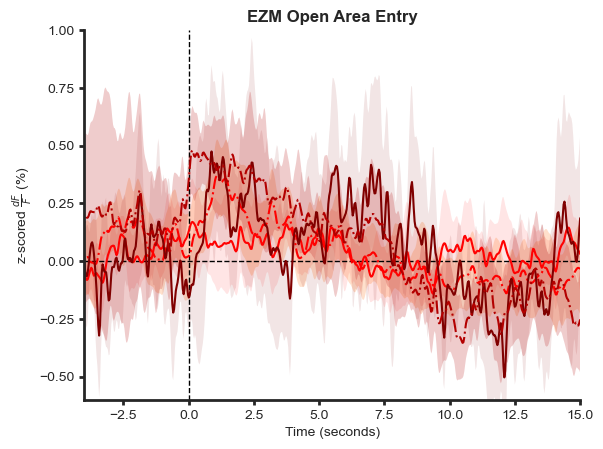

In [86]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.close('all')
fig, ax = plt.subplots()

%matplotlib inline

sns.set_style("ticks")
# multi_event_eta(fp_collection_fc,task='EZM', treatment='young tumor', region='Region2G', events=[[],FP1_A2_EZM.Timestamps['2'][FP1_A2_EZM.behavioral_data['freeze_offsets']],FP1_C1_EZM.Timestamps['2'][FP1_C1_EZM.behavioral_data['freeze_offsets']],FP1_C2_EZM.Timestamps['2'][FP1_C2_EZM.behavioral_data['freeze_offsets']],[],FP2_F2_ezm.Timestamps['2'][FP2_F2_ezm.behavioral_data['freeze_offsets']],[],FP3_I1_ezm.Timestamps['2'][FP3_I1_ezm.behavioral_data['freeze_offsets']],FP3_I2_ezm.Timestamps['2'][FP3_I2_ezm.behavioral_data['freeze_offsets']],FP3_K1_ezm.Timestamps['2'][FP3_K1_ezm.behavioral_data['freeze_offsets']],FP3_K2_ezm.Timestamps['2'][FP3_K2_ezm.behavioral_data['freeze_offsets']],FP4_K1_ezm.Timestamps['2'][FP4_K1_ezm.behavioral_data['freeze_offsets']],
#     [],
#     FP4_N1_ezm.Timestamps['2'][FP4_N1_ezm.behavioral_data['freeze_offsets']],
#     FP4_N2_ezm.Timestamps['2'][FP4_N2_ezm.behavioral_data['freeze_offsets']],
# ], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#00A651',fill_color='#00A651',alpha=0.1,smooth_sigma_s=0.1,)
multi_event_eta(fp_collection_fc,task='EZM', treatment='young tumor', region='Region0R', events=[[],FP1_A2_EZM.Timestamps['2'][FP1_A2_EZM.behavioral_data['freeze_offsets']],[],FP1_C2_EZM.Timestamps['4'][FP1_C2_EZM.behavioral_data['freeze_offsets']],[],FP2_F2_ezm.Timestamps['4'][FP2_F2_ezm.behavioral_data['freeze_offsets']],[],FP3_I1_ezm.Timestamps['4'][FP3_I1_ezm.behavioral_data['freeze_offsets']],FP3_I2_ezm.Timestamps['4'][FP3_I2_ezm.behavioral_data['freeze_offsets']],FP3_K1_ezm.Timestamps['4'][FP3_K1_ezm.behavioral_data['freeze_offsets']],FP3_K2_ezm.Timestamps['4'][FP3_K2_ezm.behavioral_data['freeze_offsets']],FP4_K1_ezm.Timestamps['4'][FP4_K1_ezm.behavioral_data['freeze_offsets']],
    [],
    FP4_N1_ezm.Timestamps['4'][FP4_N1_ezm.behavioral_data['freeze_offsets']],
    FP4_N2_ezm.Timestamps['4'][FP4_N2_ezm.behavioral_data['freeze_offsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#ff0202',fill_color='#ff0202',alpha=0.1,smooth_sigma_s=0.05)

# multi_event_eta(fp_collection_fc,task='EZM', treatment='young control', region='Region2G', events=[FP_C1_EZM.Timestamps['2'][FP_C1_EZM.behavioral_data['freeze_offsets']],FP_C2_EZM.Timestamps['2'][FP_C2_EZM.behavioral_data['freeze_offsets']],FP1_B1_EZM.Timestamps['2'][FP1_B1_EZM.behavioral_data['freeze_offsets']],FP1_D1_EZM.Timestamps['2'][FP1_D1_EZM.behavioral_data['freeze_offsets']],FP1_D2_EZM.Timestamps['2'][FP1_D2_EZM.behavioral_data['freeze_offsets']],FP2_E2_ezm.Timestamps['2'][FP2_E2_ezm.behavioral_data['freeze_offsets']],FP3_H1_ezm.Timestamps['2'][FP3_H1_ezm.behavioral_data['freeze_offsets']],FP3_H2_ezm.Timestamps['2'][FP3_H2_ezm.behavioral_data['freeze_offsets']],FP3_J1_ezm.Timestamps['2'][FP3_J1_ezm.behavioral_data['freeze_offsets']],FP3_J2_ezm.Timestamps['2'][FP3_J2_ezm.behavioral_data['freeze_offsets']],FP4_L1_ezm.Timestamps['2'][FP4_L1_ezm.behavioral_data['freeze_offsets']],
#     FP4_L2_ezm.Timestamps['2'][FP4_L2_ezm.behavioral_data['freeze_offsets']],
#     FP4_M1_ezm.Timestamps['2'][FP4_M1_ezm.behavioral_data['freeze_offsets']],
#     FP4_M2_ezm.Timestamps['2'][FP4_M2_ezm.behavioral_data['freeze_offsets']],
# ],window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#00c600',linestyle='-.',fill_color='#00ff00',alpha=0.2,smooth_sigma_s=0.1)
multi_event_eta(fp_collection_fc,task='EZM', treatment='young control', region='Region0R', events=[FP_C1_EZM.Timestamps['4'][FP_C1_EZM.behavioral_data['freeze_offsets']],FP_C2_EZM.Timestamps['4'][FP_C2_EZM.behavioral_data['freeze_offsets']],FP1_B1_EZM.Timestamps['4'][FP1_B1_EZM.behavioral_data['freeze_offsets']],FP1_D1_EZM.Timestamps['4'][FP1_D1_EZM.behavioral_data['freeze_offsets']],FP1_D2_EZM.Timestamps['4'][FP1_D2_EZM.behavioral_data['freeze_offsets']],FP2_E2_ezm.Timestamps['2'][FP2_E2_ezm.behavioral_data['freeze_offsets']],FP3_H1_ezm.Timestamps['4'][FP3_H1_ezm.behavioral_data['freeze_offsets']],FP3_H2_ezm.Timestamps['4'][FP3_H2_ezm.behavioral_data['freeze_offsets']],FP3_J1_ezm.Timestamps['4'][FP3_J1_ezm.behavioral_data['freeze_offsets']],FP3_J2_ezm.Timestamps['4'][FP3_J2_ezm.behavioral_data['freeze_offsets']],FP4_L1_ezm.Timestamps['4'][FP4_L1_ezm.behavioral_data['freeze_offsets']],
    FP4_L2_ezm.Timestamps['4'][FP4_L2_ezm.behavioral_data['freeze_offsets']],
    FP4_M1_ezm.Timestamps['4'][FP4_M1_ezm.behavioral_data['freeze_offsets']],
    FP4_M2_ezm.Timestamps['4'][FP4_M2_ezm.behavioral_data['freeze_offsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#ff0000',linestyle='-.',fill_color='#ff6700',alpha=0.2,smooth_sigma_s=0.05)
# multi_event_eta(fp_collection_fc,
#     task='EZM', treatment='aged tumor', region='Region2G',
#     events=[[],
#         [],
#         FP2_OC1_EZM.Timestamps['2'][FP2_OC1_EZM.behavioral_data['freeze_offsets']],
#         [],
#             [],[],
#         FP3_OG1_EZM.Timestamps['2'][FP3_OG1_EZM.behavioral_data['freeze_offsets']],
#         FP3_OG2_EZM.Timestamps['2'][FP3_OG2_EZM.behavioral_data['freeze_offsets']],
#         FP3_OI1_EZM.Timestamps['2'][FP3_OI1_EZM.behavioral_data['freeze_offsets']],
#         FP4_OK1_ezm.Timestamps['2'][FP4_OK1_ezm.behavioral_data['freeze_offsets']],
#         FP4_OK2_ezm.Timestamps['2'][FP4_OK2_ezm.behavioral_data['freeze_offsets']],
#         [],
#         FP4_OL2_ezm.Timestamps['2'][FP4_OL2_ezm.behavioral_data['freeze_offsets']],
#         FP5_OR1_ezm.Timestamps['2'][FP5_OR1_ezm.behavioral_data['freeze_offsets']],
#         [],
#         FP5_OS1_ezm.Timestamps['2'][FP5_OS1_ezm.behavioral_data['freeze_offsets']],
#         FP5_OS2_ezm.Timestamps['2'][FP5_OS2_ezm.behavioral_data['freeze_offsets']]
#     ],
#     window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#004d00', fill_color='#004d00', alpha=0.1,smooth_sigma_s=0.1
# )
multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged tumor', region='Region0R',
    events=[
        [],[],
        FP2_OC1_EZM.Timestamps['4'][FP2_OC1_EZM.behavioral_data['freeze_offsets']],
           [],[],
        FP3_OG1_EZM.Timestamps['4'][FP3_OG1_EZM.behavioral_data['freeze_offsets']],
        FP3_OG2_EZM.Timestamps['4'][FP3_OG2_EZM.behavioral_data['freeze_offsets']],
        FP3_OI1_EZM.Timestamps['4'][FP3_OI1_EZM.behavioral_data['freeze_offsets']],
        FP4_OK1_ezm.Timestamps['4'][FP4_OK1_ezm.behavioral_data['freeze_offsets']],
        FP4_OK2_ezm.Timestamps['4'][FP4_OK2_ezm.behavioral_data['freeze_offsets']],
        [],
        FP4_OL2_ezm.Timestamps['4'][FP4_OL2_ezm.behavioral_data['freeze_offsets']],
        FP5_OR1_ezm.Timestamps['4'][FP5_OR1_ezm.behavioral_data['freeze_offsets']],
        [],
        FP5_OS1_ezm.Timestamps['4'][FP5_OS1_ezm.behavioral_data['freeze_offsets']],
        FP5_OS2_ezm.Timestamps['4'][FP5_OS2_ezm.behavioral_data['freeze_offsets']]
     ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#800000', fill_color='#800000', alpha=0.1,smooth_sigma_s=0.05
)
#
# multi_event_eta(fp_collection_fc,
#     task='EZM', treatment='aged control', region='Region2G',
#     events=[[],[],
#         [],
#         FP2_OD2_EZM.Timestamps['2'][FP2_OD2_EZM.behavioral_data['freeze_offsets']],
#         FP2_OE1_EZM.Timestamps['2'][FP2_OE1_EZM.behavioral_data['freeze_offsets']],
#         FP2_OE2_EZM.Timestamps['2'][FP2_OE2_EZM.behavioral_data['freeze_offsets']],
#         FP3_OH1_EZM.Timestamps['2'][FP3_OJ1_EZM.behavioral_data['freeze_offsets']],
#         FP3_OJ1_EZM.Timestamps['2'][FP3_OJ1_EZM.behavioral_data['freeze_offsets']],
#         FP3_OJ2_EZM.Timestamps['2'][FP3_OJ2_EZM.behavioral_data['freeze_offsets']],
#         FP4_OM1_ezm.Timestamps['2'][FP4_OM1_ezm.behavioral_data['freeze_offsets']],
#         FP4_OM2_ezm.Timestamps['2'][FP4_OM2_ezm.behavioral_data['freeze_offsets']],
#         FP4_ON1_ezm.Timestamps['2'][FP4_ON1_ezm.behavioral_data['freeze_offsets']],
#         FP4_ON2_ezm.Timestamps['2'][FP4_ON2_ezm.behavioral_data['freeze_offsets']],
#         FP5_OP1_ezm.Timestamps['2'][FP5_OP1_ezm.behavioral_data['freeze_offsets']],
#         FP5_OP2_ezm.Timestamps['2'][FP5_OP2_ezm.behavioral_data['freeze_offsets']],
#         FP5_OQ1_ezm.Timestamps['2'][FP5_OQ1_ezm.behavioral_data['freeze_offsets']],
#     ],
#     window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#008f00', linestyle='-.',fill_color='#008f00', alpha=0.1,smooth_sigma_s=0.1
# )
multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged control', region='Region0R',
    events=[[],[],
        [],
        FP2_OD2_EZM.Timestamps['4'][FP2_OD2_EZM.behavioral_data['freeze_offsets']],
        FP2_OE1_EZM.Timestamps['4'][FP2_OE1_EZM.behavioral_data['freeze_offsets']],
        FP2_OE2_EZM.Timestamps['4'][FP2_OE2_EZM.behavioral_data['freeze_offsets']],
        FP3_OH1_EZM.Timestamps['4'][FP3_OH1_EZM.behavioral_data['freeze_offsets']],
        FP3_OJ1_EZM.Timestamps['4'][FP3_OJ1_EZM.behavioral_data['freeze_offsets']],
        FP3_OJ2_EZM.Timestamps['4'][FP3_OJ2_EZM.behavioral_data['freeze_offsets']],
        FP4_OM1_ezm.Timestamps['4'][FP4_OM1_ezm.behavioral_data['freeze_offsets']],
        FP4_OM2_ezm.Timestamps['4'][FP4_OM2_ezm.behavioral_data['freeze_offsets']],
        FP4_ON1_ezm.Timestamps['4'][FP4_ON1_ezm.behavioral_data['freeze_offsets']],
        FP4_ON2_ezm.Timestamps['4'][FP4_ON2_ezm.behavioral_data['freeze_offsets']],
        FP5_OP1_ezm.Timestamps['4'][FP5_OP1_ezm.behavioral_data['freeze_offsets']],
        FP5_OP2_ezm.Timestamps['4'][FP5_OP2_ezm.behavioral_data['freeze_offsets']],
        FP5_OQ1_ezm.Timestamps['4'][FP5_OQ1_ezm.behavioral_data['freeze_offsets']],
    ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#b30000', linestyle='-.', fill_color='#b30000', alpha=0.2,smooth_sigma_s=0.05
)
plt.xlabel('Time (seconds)')
plt.xlim(-4, 15)
plt.ylim(-0.6, 1)

plt.ylabel(r'z-scored $\frac{dF}{F}$ (%)')
plt.grid(False)
sns.despine()
ax.yaxis.set_major_locator(MultipleLocator(0.25))
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.tick_params(width=2)
plt.title('EZM Open Area Entry', fontweight='bold')
plt.axvline(0, linestyle='--', color='black', linewidth=1,zorder=1)
plt.axhline(0, linestyle='--', color='black', linewidth=1,zorder=1)
plt.show()



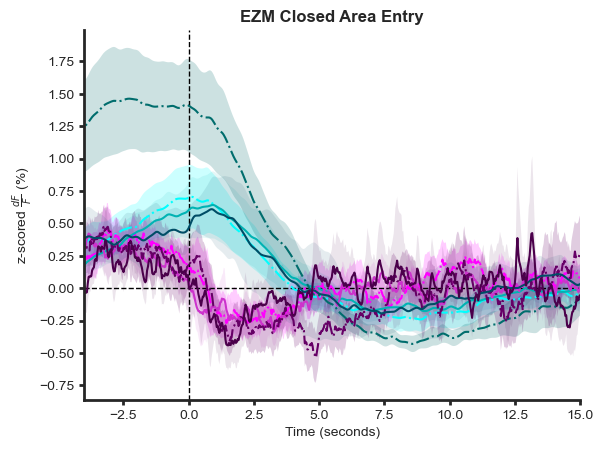

In [360]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.close('all')
fig, ax = plt.subplots()

%matplotlib inline

sns.set_style("ticks")

multi_event_eta(fp_collection_fc,task='EZM', treatment='young control', region='Region3G', events=[
FP_C1_EZM.Timestamps['2'][FP_C1_EZM.behavioral_data['freeze_onsets']],
FP_C2_EZM.Timestamps['2'][FP_C2_EZM.behavioral_data['freeze_onsets']],
FP1_B1_EZM.Timestamps['2'][FP1_B1_EZM.behavioral_data['freeze_onsets']],
FP1_D1_EZM.Timestamps['2'][FP1_D1_EZM.behavioral_data['freeze_onsets']],
FP1_D2_EZM.Timestamps['2'][FP1_D2_EZM.behavioral_data['freeze_onsets']],
[],
FP3_H1_ezm.Timestamps['2'][FP3_H1_ezm.behavioral_data['freeze_onsets']],
FP3_H2_ezm.Timestamps['2'][FP3_H2_ezm.behavioral_data['freeze_onsets']],
FP3_J1_ezm.Timestamps['2'][FP3_J1_ezm.behavioral_data['freeze_onsets']],
FP3_J2_ezm.Timestamps['2'][FP3_J2_ezm.behavioral_data['freeze_onsets']],
    FP4_L1_ezm.Timestamps['2'][FP4_L1_ezm.behavioral_data['freeze_onsets']],
    FP4_L2_ezm.Timestamps['2'][FP4_L2_ezm.behavioral_data['freeze_onsets']],
    FP4_M1_ezm.Timestamps['2'][FP4_M1_ezm.behavioral_data['freeze_onsets']],
    FP4_M2_ezm.Timestamps['2'][FP4_M2_ezm.behavioral_data['freeze_onsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#00ffff',linestyle='-.',fill_color='#00ffff',alpha=0.2,smooth_sigma_s=0.1)

multi_event_eta(fp_collection_fc,task='EZM', treatment='young control', region='Region1R', events=[
    FP_C1_EZM.Timestamps['4'][FP_C1_EZM.behavioral_data['freeze_onsets']],
    FP_C2_EZM.Timestamps['4'][FP_C2_EZM.behavioral_data['freeze_onsets']],
    FP1_B1_EZM.Timestamps['4'][FP1_B1_EZM.behavioral_data['freeze_onsets']],
    FP1_D1_EZM.Timestamps['4'][FP1_D1_EZM.behavioral_data['freeze_onsets']],
    FP1_D2_EZM.Timestamps['4'][FP1_D2_EZM.behavioral_data['freeze_onsets']],
    [],
    FP3_H1_ezm.Timestamps['4'][FP3_H1_ezm.behavioral_data['freeze_onsets']],
    FP3_H2_ezm.Timestamps['4'][FP3_H2_ezm.behavioral_data['freeze_onsets']],
    FP3_J1_ezm.Timestamps['4'][FP3_J1_ezm.behavioral_data['freeze_onsets']],
    FP3_J2_ezm.Timestamps['4'][FP3_J2_ezm.behavioral_data['freeze_onsets']],
    FP4_L1_ezm.Timestamps['4'][FP4_L1_ezm.behavioral_data['freeze_onsets']],
    FP4_L2_ezm.Timestamps['4'][FP4_L2_ezm.behavioral_data['freeze_onsets']],
    FP4_M1_ezm.Timestamps['4'][FP4_M1_ezm.behavioral_data['freeze_onsets']],
    FP4_M2_ezm.Timestamps['4'][FP4_M2_ezm.behavioral_data['freeze_onsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#ff00ff',linestyle='-.',fill_color='#ff00ff',alpha=0.2)

multi_event_eta(fp_collection_fc,task='EZM', treatment='young tumor', region='Region3G', events=[
    FP1_A1_EZM.Timestamps['2'][FP1_A1_EZM.behavioral_data['freeze_onsets']],
    FP1_A2_EZM.Timestamps['2'][FP1_A2_EZM.behavioral_data['freeze_onsets']],
    FP1_C1_EZM.Timestamps['2'][FP1_C1_EZM.behavioral_data['freeze_onsets']],
    FP1_C2_EZM.Timestamps['2'][FP1_C2_EZM.behavioral_data['freeze_onsets']],
    FP2_F1_ezm.Timestamps['2'][FP2_F1_ezm.behavioral_data['freeze_onsets']],
    FP2_F2_ezm.Timestamps['2'][FP2_F2_ezm.behavioral_data['freeze_onsets']],
    FP2_G2_ezm.Timestamps['2'][FP2_G2_ezm.behavioral_data['freeze_onsets']],
    FP3_I1_ezm.Timestamps['2'][FP3_I1_ezm.behavioral_data['freeze_onsets']],
    FP3_I2_ezm.Timestamps['2'][FP3_I2_ezm.behavioral_data['freeze_onsets']],
    FP3_K1_ezm.Timestamps['2'][FP3_K1_ezm.behavioral_data['freeze_onsets']],
    FP3_K2_ezm.Timestamps['2'][FP3_K2_ezm.behavioral_data['freeze_onsets']],
    FP4_K1_ezm.Timestamps['2'][FP4_K1_ezm.behavioral_data['freeze_onsets']],
    FP4_K2_ezm.Timestamps['2'][FP4_K2_ezm.behavioral_data['freeze_onsets']],
    FP4_N1_ezm.Timestamps['2'][FP4_N1_ezm.behavioral_data['freeze_onsets']],
    FP4_N2_ezm.Timestamps['2'][FP4_N2_ezm.behavioral_data['freeze_onsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#00b3b3',fill_color='#00b3b3',alpha=0.1,smooth_sigma_s=0.1)

multi_event_eta(fp_collection_fc,task='EZM', treatment='young tumor', region='Region1R', events=[
    FP1_A1_EZM.Timestamps['4'][FP1_A1_EZM.behavioral_data['freeze_onsets']],
    FP1_A2_EZM.Timestamps['4'][FP1_A2_EZM.behavioral_data['freeze_onsets']],
    FP1_C1_EZM.Timestamps['4'][FP1_C1_EZM.behavioral_data['freeze_onsets']],
    FP1_C2_EZM.Timestamps['4'][FP1_C2_EZM.behavioral_data['freeze_onsets']],
    FP2_F1_ezm.Timestamps['4'][FP2_F1_ezm.behavioral_data['freeze_onsets']],
    FP2_F2_ezm.Timestamps['4'][FP2_F2_ezm.behavioral_data['freeze_onsets']],
    FP2_G2_ezm.Timestamps['4'][FP2_G2_ezm.behavioral_data['freeze_onsets']],
    FP3_I1_ezm.Timestamps['4'][FP3_I1_ezm.behavioral_data['freeze_onsets']],
    FP3_I2_ezm.Timestamps['4'][FP3_I2_ezm.behavioral_data['freeze_onsets']],
    FP3_K1_ezm.Timestamps['4'][FP3_K1_ezm.behavioral_data['freeze_onsets']],
    FP3_K2_ezm.Timestamps['4'][FP3_K2_ezm.behavioral_data['freeze_onsets']],
    FP4_K1_ezm.Timestamps['2'][FP4_K1_ezm.behavioral_data['freeze_onsets']],
    FP4_K2_ezm.Timestamps['2'][FP4_K2_ezm.behavioral_data['freeze_onsets']],
    FP4_N1_ezm.Timestamps['2'][FP4_N1_ezm.behavioral_data['freeze_onsets']],
    FP4_N2_ezm.Timestamps['2'][FP4_N2_ezm.behavioral_data['freeze_onsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#cc33cc',fill_color='#cc33cc',alpha=0.1)


multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged control', region='Region3G',
    events=[
        FP1_OB1_EZM.Timestamps['2'][FP1_OB1_EZM.behavioral_data['freeze_onsets']],
        FP1_OB2_EZM.Timestamps['2'][FP1_OB2_EZM.behavioral_data['freeze_onsets']],
        FP2_OD1_EZM.Timestamps['2'][FP2_OD1_EZM.behavioral_data['freeze_onsets']],
        FP2_OD2_EZM.Timestamps['2'][FP2_OD2_EZM.behavioral_data['freeze_onsets']],
        FP2_OE1_EZM.Timestamps['2'][FP2_OE1_EZM.behavioral_data['freeze_onsets']],
        FP2_OE2_EZM.Timestamps['2'][FP2_OE2_EZM.behavioral_data['freeze_onsets']],
        FP3_OH1_EZM.Timestamps['2'][FP3_OH1_EZM.behavioral_data['freeze_onsets']],
        FP3_OJ1_EZM.Timestamps['2'][FP3_OJ1_EZM.behavioral_data['freeze_onsets']],
        FP3_OJ2_EZM.Timestamps['2'][FP3_OJ2_EZM.behavioral_data['freeze_onsets']],
        FP4_OM1_ezm.Timestamps['2'][FP4_OM1_ezm.behavioral_data['freeze_onsets']],
        FP4_OM2_ezm.Timestamps['2'][FP4_OM2_ezm.behavioral_data['freeze_onsets']],
        FP4_ON1_ezm.Timestamps['2'][FP4_ON1_ezm.behavioral_data['freeze_onsets']],
        FP4_ON2_ezm.Timestamps['2'][FP4_ON2_ezm.behavioral_data['freeze_onsets']],
        FP5_OP1_ezm.Timestamps['2'][FP5_OP1_ezm.behavioral_data['freeze_onsets']],
        FP5_OP2_ezm.Timestamps['2'][FP5_OP2_ezm.behavioral_data['freeze_onsets']],
        FP5_OQ1_ezm.Timestamps['2'][FP5_OQ1_ezm.behavioral_data['freeze_onsets']],
    ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#006d6d', linestyle='-.', fill_color='#006d6d', alpha=0.2,smooth_sigma_s=0.1
)
# # Control - Region1R
multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged control', region='Region1R',
    events=[
        FP1_OB1_EZM.Timestamps['4'][FP1_OB1_EZM.behavioral_data['freeze_onsets']],
        FP1_OB2_EZM.Timestamps['4'][FP1_OB2_EZM.behavioral_data['freeze_onsets']],
        FP2_OD1_EZM.Timestamps['4'][FP2_OD1_EZM.behavioral_data['freeze_onsets']],
        FP2_OD2_EZM.Timestamps['4'][FP2_OD2_EZM.behavioral_data['freeze_onsets']],
        FP2_OE1_EZM.Timestamps['4'][FP2_OE1_EZM.behavioral_data['freeze_onsets']],
        FP2_OE2_EZM.Timestamps['4'][FP2_OE2_EZM.behavioral_data['freeze_onsets']],
        FP3_OH1_EZM.Timestamps['4'][FP3_OH1_EZM.behavioral_data['freeze_onsets']],
        FP3_OJ1_EZM.Timestamps['4'][FP3_OJ1_EZM.behavioral_data['freeze_onsets']],
        FP3_OJ2_EZM.Timestamps['4'][FP3_OJ2_EZM.behavioral_data['freeze_onsets']],
        FP4_OM1_ezm.Timestamps['4'][FP4_OM1_ezm.behavioral_data['freeze_onsets']],
        FP4_OM2_ezm.Timestamps['4'][FP4_OM2_ezm.behavioral_data['freeze_onsets']],
        FP4_ON1_ezm.Timestamps['4'][FP4_ON1_ezm.behavioral_data['freeze_onsets']],
        FP4_ON2_ezm.Timestamps['4'][FP4_ON2_ezm.behavioral_data['freeze_onsets']],
        FP5_OP1_ezm.Timestamps['4'][FP5_OP1_ezm.behavioral_data['freeze_onsets']],
        FP5_OP2_ezm.Timestamps['4'][FP5_OP2_ezm.behavioral_data['freeze_onsets']],
        FP5_OQ1_ezm.Timestamps['4'][FP5_OQ1_ezm.behavioral_data['freeze_onsets']],
    ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#660066', linestyle='-.', fill_color='#660066', alpha=0.2
)
#
# #
#
# # Tumor - Region3G
multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged tumor', region='Region3G',
    events=[[],[],
        FP2_OC1_EZM.Timestamps['2'][FP2_OC1_EZM.behavioral_data['freeze_onsets']],
        FP2_OC2_EZM.Timestamps['2'][FP2_OC2_EZM.behavioral_data['freeze_onsets']],
        [],
        [],
        [],
        FP3_OG2_EZM.Timestamps['2'][FP3_OG2_EZM.behavioral_data['freeze_onsets']],
        FP3_OI1_EZM.Timestamps['2'][FP3_OI1_EZM.behavioral_data['freeze_onsets']],
        [],
        FP4_OK2_ezm.Timestamps['2'][FP4_OK2_ezm.behavioral_data['freeze_onsets']],
        FP4_OL1_ezm.Timestamps['2'][FP4_OL1_ezm.behavioral_data['freeze_onsets']],
        FP4_OL2_ezm.Timestamps['2'][FP4_OL2_ezm.behavioral_data['freeze_onsets']],
        FP5_OR1_ezm.Timestamps['2'][FP5_OR1_ezm.behavioral_data['freeze_onsets']],
        FP5_OR2_ezm.Timestamps['2'][FP5_OR2_ezm.behavioral_data['freeze_onsets']],
        FP5_OS1_ezm.Timestamps['2'][FP5_OS1_ezm.behavioral_data['freeze_onsets']],
        FP5_OS2_ezm.Timestamps['2'][FP5_OS2_ezm.behavioral_data['freeze_onsets']]
    ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#004d66', fill_color='#004d66', alpha=0.1
,smooth_sigma_s=0.1)
# # Tumor - Region1R
multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged tumor', region='Region1R',
    events=[[],[],
        FP2_OC1_EZM.Timestamps['4'][FP2_OC1_EZM.behavioral_data['freeze_onsets']],
        FP2_OC2_EZM.Timestamps['4'][FP2_OC2_EZM.behavioral_data['freeze_onsets']],
        [],
        [],
        [],
        FP3_OG2_EZM.Timestamps['4'][FP3_OG2_EZM.behavioral_data['freeze_onsets']],
        FP3_OI1_EZM.Timestamps['4'][FP3_OI1_EZM.behavioral_data['freeze_onsets']],
        [],
        FP4_OK2_ezm.Timestamps['4'][FP4_OK2_ezm.behavioral_data['freeze_onsets']],
        FP4_OL1_ezm.Timestamps['4'][FP4_OL1_ezm.behavioral_data['freeze_onsets']],
        FP4_OL2_ezm.Timestamps['4'][FP4_OL2_ezm.behavioral_data['freeze_onsets']],
        FP5_OR1_ezm.Timestamps['4'][FP5_OR1_ezm.behavioral_data['freeze_onsets']],
        FP5_OR2_ezm.Timestamps['4'][FP5_OR2_ezm.behavioral_data['freeze_onsets']],
        FP5_OS1_ezm.Timestamps['4'][FP5_OS1_ezm.behavioral_data['freeze_onsets']],
        FP5_OS2_ezm.Timestamps['4'][FP5_OS2_ezm.behavioral_data['freeze_onsets']]
    ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#4b004b', fill_color='#4b004b', alpha=0.1
)

plt.xlabel('Time (seconds)')
plt.xlim(-4, 15)
plt.ylabel(r'z-scored $\frac{dF}{F}$ (%)')
plt.grid(False)
sns.despine()
ax.yaxis.set_major_locator(MultipleLocator(0.25))
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.tick_params(width=2)
plt.title('EZM Closed Area Entry', fontweight='bold')
plt.axvline(0, linestyle='--', color='black', linewidth=1,zorder=1)
plt.axhline(0, linestyle='--', color='black', linewidth=1,zorder=1)
plt.show()


In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.close('all')
fig, ax = plt.subplots()

%matplotlib inline

sns.set_style("ticks")
multi_event_eta(fp_collection_fc,task='EZM', treatment='young tumor', region='Region2G', events=[[],FP1_A2_EZM.Timestamps['2'][FP1_A2_EZM.behavioral_data['freeze_onsets']],FP1_C1_EZM.Timestamps['2'][FP1_C1_EZM.behavioral_data['freeze_onsets']],FP1_C2_EZM.Timestamps['2'][FP1_C2_EZM.behavioral_data['freeze_onsets']],[],FP2_F2_ezm.Timestamps['2'][FP2_F2_ezm.behavioral_data['freeze_onsets']],[],FP3_I1_ezm.Timestamps['2'][FP3_I1_ezm.behavioral_data['freeze_onsets']],FP3_I2_ezm.Timestamps['2'][FP3_I2_ezm.behavioral_data['freeze_onsets']],FP3_K1_ezm.Timestamps['2'][FP3_K1_ezm.behavioral_data['freeze_onsets']],FP3_K2_ezm.Timestamps['2'][FP3_K2_ezm.behavioral_data['freeze_onsets']],FP4_K1_ezm.Timestamps['2'][FP4_K1_ezm.behavioral_data['freeze_onsets']],
    [],
    FP4_N1_ezm.Timestamps['2'][FP4_N1_ezm.behavioral_data['freeze_onsets']],
    FP4_N2_ezm.Timestamps['2'][FP4_N2_ezm.behavioral_data['freeze_onsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#00A651',fill_color='#00A651',alpha=0.1,smooth_sigma_s=0.1,)
multi_event_eta(fp_collection_fc,task='EZM', treatment='young tumor', region='Region0R', events=[[],FP1_A2_EZM.Timestamps['2'][FP1_A2_EZM.behavioral_data['freeze_onsets']],[],FP1_C2_EZM.Timestamps['4'][FP1_C2_EZM.behavioral_data['freeze_onsets']],[],FP2_F2_ezm.Timestamps['4'][FP2_F2_ezm.behavioral_data['freeze_onsets']],[],FP3_I2_ezm.Timestamps['4'][FP3_I2_ezm.behavioral_data['freeze_onsets']],FP3_K1_ezm.Timestamps['4'][FP3_K1_ezm.behavioral_data['freeze_onsets']],FP3_K2_ezm.Timestamps['4'][FP3_K2_ezm.behavioral_data['freeze_onsets']],FP4_K1_ezm.Timestamps['4'][FP4_K1_ezm.behavioral_data['freeze_onsets']],
    [],
    FP4_N1_ezm.Timestamps['4'][FP4_N1_ezm.behavioral_data['freeze_onsets']],
    FP4_N2_ezm.Timestamps['4'][FP4_N2_ezm.behavioral_data['freeze_onsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#ff0202',fill_color='#ff0202',alpha=0.1,)

multi_event_eta(fp_collection_fc,task='EZM', treatment='young control', region='Region2G', events=[FP_C1_EZM.Timestamps['2'][FP_C1_EZM.behavioral_data['freeze_onsets']],FP_C2_EZM.Timestamps['2'][FP_C2_EZM.behavioral_data['freeze_onsets']],FP1_B1_EZM.Timestamps['2'][FP1_B1_EZM.behavioral_data['freeze_onsets']],FP1_D1_EZM.Timestamps['2'][FP1_D1_EZM.behavioral_data['freeze_onsets']],FP1_D2_EZM.Timestamps['2'][FP1_D2_EZM.behavioral_data['freeze_onsets']],FP2_E2_ezm.Timestamps['2'][FP2_E2_ezm.behavioral_data['freeze_onsets']],FP3_H1_ezm.Timestamps['2'][FP3_H1_ezm.behavioral_data['freeze_onsets']],FP3_H2_ezm.Timestamps['2'][FP3_H2_ezm.behavioral_data['freeze_onsets']],FP3_J1_ezm.Timestamps['2'][FP3_J1_ezm.behavioral_data['freeze_onsets']],FP3_J2_ezm.Timestamps['2'][FP3_J2_ezm.behavioral_data['freeze_onsets']],FP4_L1_ezm.Timestamps['2'][FP4_L1_ezm.behavioral_data['freeze_onsets']],
    FP4_L2_ezm.Timestamps['2'][FP4_L2_ezm.behavioral_data['freeze_onsets']],
    FP4_M1_ezm.Timestamps['2'][FP4_M1_ezm.behavioral_data['freeze_onsets']],
    FP4_M2_ezm.Timestamps['2'][FP4_M2_ezm.behavioral_data['freeze_onsets']],
],window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#00c600',linestyle='-.',fill_color='#00ff00',alpha=0.2,smooth_sigma_s=0.1)
multi_event_eta(fp_collection_fc,task='EZM', treatment='young control', region='Region0R', events=[FP_C1_EZM.Timestamps['4'][FP_C1_EZM.behavioral_data['freeze_onsets']],FP_C2_EZM.Timestamps['4'][FP_C2_EZM.behavioral_data['freeze_onsets']],FP1_B1_EZM.Timestamps['4'][FP1_B1_EZM.behavioral_data['freeze_onsets']],FP1_D1_EZM.Timestamps['4'][FP1_D1_EZM.behavioral_data['freeze_onsets']],FP1_D2_EZM.Timestamps['4'][FP1_D2_EZM.behavioral_data['freeze_onsets']],FP2_E2_ezm.Timestamps['2'][FP2_E2_ezm.behavioral_data['freeze_onsets']],FP3_H1_ezm.Timestamps['4'][FP3_H1_ezm.behavioral_data['freeze_onsets']],FP3_H2_ezm.Timestamps['4'][FP3_H2_ezm.behavioral_data['freeze_onsets']],FP3_J1_ezm.Timestamps['4'][FP3_J1_ezm.behavioral_data['freeze_onsets']],FP3_J2_ezm.Timestamps['4'][FP3_J2_ezm.behavioral_data['freeze_onsets']],FP4_L1_ezm.Timestamps['4'][FP4_L1_ezm.behavioral_data['freeze_onsets']],
    FP4_L2_ezm.Timestamps['4'][FP4_L2_ezm.behavioral_data['freeze_onsets']],
    FP4_M1_ezm.Timestamps['4'][FP4_M1_ezm.behavioral_data['freeze_onsets']],
    FP4_M2_ezm.Timestamps['4'][FP4_M2_ezm.behavioral_data['freeze_onsets']],
], window = 15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#ff0000',linestyle='-.',fill_color='#ff6700',alpha=0.2)
multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged tumor', region='Region2G',
    events=[[],
        [],
        FP2_OC1_EZM.Timestamps['2'][FP2_OC1_EZM.behavioral_data['freeze_onsets']],
        [],
            [],[],
        [],
        FP3_OG2_EZM.Timestamps['2'][FP3_OG2_EZM.behavioral_data['freeze_onsets']],
        FP3_OI1_EZM.Timestamps['2'][FP3_OI1_EZM.behavioral_data['freeze_onsets']],
        [],
        FP4_OK2_ezm.Timestamps['2'][FP4_OK2_ezm.behavioral_data['freeze_onsets']],
        [],
        FP4_OL2_ezm.Timestamps['2'][FP4_OL2_ezm.behavioral_data['freeze_onsets']],
        FP5_OR1_ezm.Timestamps['2'][FP5_OR1_ezm.behavioral_data['freeze_onsets']],
        [],
        FP5_OS1_ezm.Timestamps['2'][FP5_OS1_ezm.behavioral_data['freeze_onsets']],
        FP5_OS2_ezm.Timestamps['2'][FP5_OS2_ezm.behavioral_data['freeze_onsets']]
    ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#004d00', fill_color='#004d00', alpha=0.1,smooth_sigma_s=0.1
)
multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged tumor', region='Region0R',
    events=[
        [],[],
        FP2_OC1_EZM.Timestamps['4'][FP2_OC1_EZM.behavioral_data['freeze_onsets']],
           [],[],
        [],
        FP3_OG2_EZM.Timestamps['4'][FP3_OG2_EZM.behavioral_data['freeze_onsets']],
        FP3_OI1_EZM.Timestamps['4'][FP3_OI1_EZM.behavioral_data['freeze_onsets']],
        [],
        FP4_OK2_ezm.Timestamps['4'][FP4_OK2_ezm.behavioral_data['freeze_onsets']],
        [],
        FP4_OL2_ezm.Timestamps['4'][FP4_OL2_ezm.behavioral_data['freeze_onsets']],
        FP5_OR1_ezm.Timestamps['4'][FP5_OR1_ezm.behavioral_data['freeze_onsets']],
        [],
        FP5_OS1_ezm.Timestamps['4'][FP5_OS1_ezm.behavioral_data['freeze_onsets']],
        FP5_OS2_ezm.Timestamps['4'][FP5_OS2_ezm.behavioral_data['freeze_onsets']]
     ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#800000', fill_color='#800000', alpha=0.1,
)

multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged control', region='Region2G',
    events=[[],[],
        [],
        FP2_OD2_EZM.Timestamps['2'][FP2_OD2_EZM.behavioral_data['freeze_onsets']],
        FP2_OE1_EZM.Timestamps['2'][FP2_OE1_EZM.behavioral_data['freeze_onsets']],
        FP2_OE2_EZM.Timestamps['2'][FP2_OE2_EZM.behavioral_data['freeze_onsets']],
        FP3_OH1_EZM.Timestamps['2'][FP3_OJ1_EZM.behavioral_data['freeze_onsets']],
        FP3_OJ1_EZM.Timestamps['2'][FP3_OJ1_EZM.behavioral_data['freeze_onsets']],
        FP3_OJ2_EZM.Timestamps['2'][FP3_OJ2_EZM.behavioral_data['freeze_onsets']],
        FP4_OM1_ezm.Timestamps['2'][FP4_OM1_ezm.behavioral_data['freeze_onsets']],
        FP4_OM2_ezm.Timestamps['2'][FP4_OM2_ezm.behavioral_data['freeze_onsets']],
        FP4_ON1_ezm.Timestamps['2'][FP4_ON1_ezm.behavioral_data['freeze_onsets']],
        FP4_ON2_ezm.Timestamps['2'][FP4_ON2_ezm.behavioral_data['freeze_onsets']],
        FP5_OP1_ezm.Timestamps['2'][FP5_OP1_ezm.behavioral_data['freeze_onsets']],
        FP5_OP2_ezm.Timestamps['2'][FP5_OP2_ezm.behavioral_data['freeze_onsets']],
        FP5_OQ1_ezm.Timestamps['2'][FP5_OQ1_ezm.behavioral_data['freeze_onsets']],
    ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#008f00', linestyle='-.',fill_color='#008f00', alpha=0.1,smooth_sigma_s=0.1
)
multi_event_eta(fp_collection_fc,
    task='EZM', treatment='aged control', region='Region0R',
    events=[[],[],
        [],
        FP2_OD2_EZM.Timestamps['4'][FP2_OD2_EZM.behavioral_data['freeze_onsets']],
        FP2_OE1_EZM.Timestamps['4'][FP2_OE1_EZM.behavioral_data['freeze_onsets']],
        FP2_OE2_EZM.Timestamps['4'][FP2_OE2_EZM.behavioral_data['freeze_onsets']],
        FP3_OH1_EZM.Timestamps['4'][FP3_OH1_EZM.behavioral_data['freeze_onsets']],
        FP3_OJ1_EZM.Timestamps['4'][FP3_OJ1_EZM.behavioral_data['freeze_onsets']],
        FP3_OJ2_EZM.Timestamps['4'][FP3_OJ2_EZM.behavioral_data['freeze_onsets']],
        FP4_OM1_ezm.Timestamps['4'][FP4_OM1_ezm.behavioral_data['freeze_onsets']],
        FP4_OM2_ezm.Timestamps['4'][FP4_OM2_ezm.behavioral_data['freeze_onsets']],
        FP4_ON1_ezm.Timestamps['4'][FP4_ON1_ezm.behavioral_data['freeze_onsets']],
        FP4_ON2_ezm.Timestamps['4'][FP4_ON2_ezm.behavioral_data['freeze_onsets']],
        FP5_OP1_ezm.Timestamps['4'][FP5_OP1_ezm.behavioral_data['freeze_onsets']],
        FP5_OP2_ezm.Timestamps['4'][FP5_OP2_ezm.behavioral_data['freeze_onsets']],
        FP5_OQ1_ezm.Timestamps['4'][FP5_OQ1_ezm.behavioral_data['freeze_onsets']],
    ],
    window=15, ci='tci', sig_duration=30, ax=ax, a=0.05, color='#b30000', linestyle='-.', fill_color='#b30000', alpha=0.2
)
plt.xlabel('Time (seconds)')
plt.xlim(-4, 15)
plt.ylim(-0.75, 1.6)

plt.ylabel(r'z-scored $\frac{dF}{F}$ (%)')
plt.grid(False)
sns.despine()
ax.yaxis.set_major_locator(MultipleLocator(0.25))
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.tick_params(width=2)
plt.title('EZM Closed Area Entry', fontweight='bold')
plt.axvline(0, linestyle='--', color='black', linewidth=1,zorder=1)
plt.axhline(0, linestyle='--', color='black', linewidth=1,zorder=1)
plt.show()


NameError: name 'multi_event_eta' is not defined

In [19]:
events_by_group = {
    # === YOUNG CONTROL ===
    ("young control", "Region3G"): [
        ("FP_C1", FP_C1_EZM.Timestamps['2'][FP_C1_EZM.behavioral_data['freeze_offsets']]),
        ("FP_C2", FP_C2_EZM.Timestamps['2'][FP_C2_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_B1", FP1_B1_EZM.Timestamps['2'][FP1_B1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_D1", FP1_D1_EZM.Timestamps['2'][FP1_D1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_D2", FP1_D2_EZM.Timestamps['2'][FP1_D2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_H1", FP3_H1_ezm.Timestamps['2'][FP3_H1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_H2", FP3_H2_ezm.Timestamps['2'][FP3_H2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_J1", FP3_J1_ezm.Timestamps['2'][FP3_J1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_J2", FP3_J2_ezm.Timestamps['2'][FP3_J2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_L1",FP4_L1_ezm.Timestamps['2'][FP4_L1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_L2",FP4_L2_ezm.Timestamps['2'][FP4_L2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_M1",FP4_M1_ezm.Timestamps['2'][FP4_M1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_M2",FP4_M2_ezm.Timestamps['2'][FP4_M2_ezm.behavioral_data['freeze_offsets']]),

    ],
    ("young control", "Region1R"): [
        ("FP_C1", FP_C1_EZM.Timestamps['4'][FP_C1_EZM.behavioral_data['freeze_offsets']]),
        ("FP_C2", FP_C2_EZM.Timestamps['4'][FP_C2_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_B1", FP1_B1_EZM.Timestamps['4'][FP1_B1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_D1", FP1_D1_EZM.Timestamps['4'][FP1_D1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_D2", FP1_D2_EZM.Timestamps['4'][FP1_D2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_H1", FP3_H1_ezm.Timestamps['4'][FP3_H1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_H2", FP3_H2_ezm.Timestamps['4'][FP3_H2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_J1", FP3_J1_ezm.Timestamps['4'][FP3_J1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_J2", FP3_J2_ezm.Timestamps['4'][FP3_J2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_L1",FP4_L1_ezm.Timestamps['4'][FP4_L1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_L2",FP4_L2_ezm.Timestamps['4'][FP4_L2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_M1",FP4_M1_ezm.Timestamps['4'][FP4_M1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_M2",FP4_M2_ezm.Timestamps['4'][FP4_M2_ezm.behavioral_data['freeze_offsets']]),
    ],
    ("young control", "Region2G"): [
        ("FP_C1", FP_C1_EZM.Timestamps['2'][FP_C1_EZM.behavioral_data['freeze_offsets']]),
        ("FP_C2", FP_C2_EZM.Timestamps['2'][FP_C2_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_B1", FP1_B1_EZM.Timestamps['2'][FP1_B1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_D1", FP1_D1_EZM.Timestamps['2'][FP1_D1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_D2", FP1_D2_EZM.Timestamps['2'][FP1_D2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_E2", FP2_E2_ezm.Timestamps['2'][FP2_E2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_H1", FP3_H1_ezm.Timestamps['2'][FP3_H1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_H2", FP3_H2_ezm.Timestamps['2'][FP3_H2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_J1", FP3_J1_ezm.Timestamps['2'][FP3_J1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_J2", FP3_J2_ezm.Timestamps['2'][FP3_J2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_L1",FP4_L1_ezm.Timestamps['2'][FP4_L1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_L2",FP4_L2_ezm.Timestamps['2'][FP4_L2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_M1",FP4_M1_ezm.Timestamps['2'][FP4_M1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_M2",FP4_M2_ezm.Timestamps['2'][FP4_M2_ezm.behavioral_data['freeze_offsets']]),
    ],
    ("young control", "Region0R"): [
        ("FP_C1", FP_C1_EZM.Timestamps['4'][FP_C1_EZM.behavioral_data['freeze_offsets']]),
        ("FP_C2", FP_C2_EZM.Timestamps['4'][FP_C2_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_B1", FP1_B1_EZM.Timestamps['4'][FP1_B1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_D1", FP1_D1_EZM.Timestamps['4'][FP1_D1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_D2", FP1_D2_EZM.Timestamps['4'][FP1_D2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_E2", FP2_E2_ezm.Timestamps['4'][FP2_E2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_H1", FP3_H1_ezm.Timestamps['4'][FP3_H1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_H2", FP3_H2_ezm.Timestamps['4'][FP3_H2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_J1", FP3_J1_ezm.Timestamps['4'][FP3_J1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_J2", FP3_J2_ezm.Timestamps['4'][FP3_J2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_L1",FP4_L1_ezm.Timestamps['4'][FP4_L1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_L2",FP4_L2_ezm.Timestamps['4'][FP4_L2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_M1",FP4_M1_ezm.Timestamps['4'][FP4_M1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_M2",FP4_M2_ezm.Timestamps['4'][FP4_M2_ezm.behavioral_data['freeze_offsets']]),
    ],

    # === YOUNG TUMOR ===
    ("young tumor", "Region3G"): [
        ("FP1_A1", FP1_A1_EZM.Timestamps['2'][FP1_A1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_A2", FP1_A2_EZM.Timestamps['2'][FP1_A2_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_C1", FP1_C1_EZM.Timestamps['2'][FP1_C1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_C2", FP1_C2_EZM.Timestamps['2'][FP1_C2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_F1", FP2_F1_ezm.Timestamps['2'][FP2_F1_ezm.behavioral_data['freeze_offsets']]),
        ("FP2_F2", FP2_F2_ezm.Timestamps['2'][FP2_F2_ezm.behavioral_data['freeze_offsets']]),
        ("FP2_G2", FP2_G2_ezm.Timestamps['2'][FP2_G2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_I1", FP3_I1_ezm.Timestamps['2'][FP3_I1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_I2", FP3_I2_ezm.Timestamps['2'][FP3_I2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_K1", FP3_K1_ezm.Timestamps['2'][FP3_K1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_K2", FP3_K2_ezm.Timestamps['2'][FP3_K2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_K1",FP4_K1_ezm.Timestamps['2'][FP4_K1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_K2",FP4_K2_ezm.Timestamps['2'][FP4_K2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_N1",FP4_N1_ezm.Timestamps['2'][FP4_N1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_N2",FP4_N2_ezm.Timestamps['2'][FP4_N2_ezm.behavioral_data['freeze_offsets']]),
    ],
    ("young tumor", "Region1R"): [
        ("FP1_A1", FP1_A1_EZM.Timestamps['4'][FP1_A1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_A2", FP1_A2_EZM.Timestamps['4'][FP1_A2_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_C1", FP1_C1_EZM.Timestamps['4'][FP1_C1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_C2", FP1_C2_EZM.Timestamps['4'][FP1_C2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_F1", FP2_F1_ezm.Timestamps['4'][FP2_F1_ezm.behavioral_data['freeze_offsets']]),
        ("FP2_F2", FP2_F2_ezm.Timestamps['4'][FP2_F2_ezm.behavioral_data['freeze_offsets']]),
        ("FP2_G2", FP2_G2_ezm.Timestamps['4'][FP2_G2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_I1", FP3_I1_ezm.Timestamps['4'][FP3_I1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_I2", FP3_I2_ezm.Timestamps['4'][FP3_I2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_K1", FP3_K1_ezm.Timestamps['4'][FP3_K1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_K2", FP3_K2_ezm.Timestamps['4'][FP3_K2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_K1",FP4_K1_ezm.Timestamps['4'][FP4_K1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_K2",FP4_K2_ezm.Timestamps['4'][FP4_K2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_N1",FP4_N1_ezm.Timestamps['4'][FP4_N1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_N2",FP4_N2_ezm.Timestamps['4'][FP4_N2_ezm.behavioral_data['freeze_offsets']]),
    ],
    ("young tumor", "Region2G"): [
        ("FP1_A2", FP1_A2_EZM.Timestamps['2'][FP1_A2_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_C1", FP1_C1_EZM.Timestamps['2'][FP1_C1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_C2", FP1_C2_EZM.Timestamps['2'][FP1_C2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_F2", FP2_F2_ezm.Timestamps['2'][FP2_F2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_I1", FP3_I1_ezm.Timestamps['2'][FP3_I1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_I2", FP3_I2_ezm.Timestamps['2'][FP3_I2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_K1", FP3_K1_ezm.Timestamps['2'][FP3_K1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_K2", FP3_K2_ezm.Timestamps['2'][FP3_K2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_K1",FP4_K1_ezm.Timestamps['2'][FP4_K1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_N1",FP4_N1_ezm.Timestamps['2'][FP4_N1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_N2",FP4_N2_ezm.Timestamps['2'][FP4_N2_ezm.behavioral_data['freeze_offsets']]),
    ],
    ("young tumor", "Region0R"): [
        ("FP1_A2", FP1_A2_EZM.Timestamps['4'][FP1_A2_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_C2", FP1_C2_EZM.Timestamps['4'][FP1_C2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_F2", FP2_F2_ezm.Timestamps['4'][FP2_F2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_I1", FP3_I1_ezm.Timestamps['4'][FP3_I1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_I2", FP3_I2_ezm.Timestamps['4'][FP3_I2_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_K1", FP3_K1_ezm.Timestamps['4'][FP3_K1_ezm.behavioral_data['freeze_offsets']]),
        ("FP3_K2", FP3_K2_ezm.Timestamps['4'][FP3_K2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_K1",FP4_K1_ezm.Timestamps['4'][FP4_K1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_N1",FP4_N1_ezm.Timestamps['4'][FP4_N1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_N2",FP4_N2_ezm.Timestamps['4'][FP4_N2_ezm.behavioral_data['freeze_offsets']]),
    ],

    # === AGED CONTROL ===
    ("aged control", "Region3G"): [
        ("FP1_OB1", FP1_OB1_EZM.Timestamps['2'][FP1_OB1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_OB2", FP1_OB2_EZM.Timestamps['2'][FP1_OB2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OD1", FP2_OD1_EZM.Timestamps['2'][FP2_OD1_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OD2", FP2_OD2_EZM.Timestamps['2'][FP2_OD2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OE1", FP2_OE1_EZM.Timestamps['2'][FP2_OE1_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OE2", FP2_OE2_EZM.Timestamps['2'][FP2_OE2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OH1", FP3_OH1_EZM.Timestamps['2'][FP3_OH1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OJ2", FP3_OJ2_EZM.Timestamps['2'][FP3_OJ2_EZM.behavioral_data['freeze_offsets']]),
        ("FP4_OM1", FP4_OM1_ezm.Timestamps['2'][FP4_OM1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OM2", FP4_OM2_ezm.Timestamps['2'][FP4_OM2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_ON1", FP4_ON1_ezm.Timestamps['2'][FP4_ON1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_ON2", FP4_ON2_ezm.Timestamps['2'][FP4_ON2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OP1", FP5_OP1_ezm.Timestamps['2'][FP5_OP1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OP2", FP5_OP2_ezm.Timestamps['2'][FP5_OP2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OQ1", FP5_OQ1_ezm.Timestamps['2'][FP5_OQ1_ezm.behavioral_data['freeze_offsets']])

    ],
    ("aged control", "Region1R"): [
        ("FP1_OB1", FP1_OB1_EZM.Timestamps['4'][FP1_OB1_EZM.behavioral_data['freeze_offsets']]),
        ("FP1_OB2", FP1_OB2_EZM.Timestamps['4'][FP1_OB2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OD1", FP2_OD1_EZM.Timestamps['4'][FP2_OD1_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OD2", FP2_OD2_EZM.Timestamps['4'][FP2_OD2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OE1", FP2_OE1_EZM.Timestamps['4'][FP2_OE1_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OE2", FP2_OE2_EZM.Timestamps['4'][FP2_OE2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OH1", FP3_OH1_EZM.Timestamps['4'][FP3_OH1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OJ1", FP3_OJ1_EZM.Timestamps['4'][FP3_OJ1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OJ2", FP3_OJ2_EZM.Timestamps['4'][FP3_OJ2_EZM.behavioral_data['freeze_offsets']]),
        ("FP4_OM1", FP4_OM1_ezm.Timestamps['4'][FP4_OM1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OM2", FP4_OM2_ezm.Timestamps['4'][FP4_OM2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_ON1", FP4_ON1_ezm.Timestamps['4'][FP4_ON1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_ON2", FP4_ON2_ezm.Timestamps['4'][FP4_ON2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OP1", FP5_OP1_ezm.Timestamps['4'][FP5_OP1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OP2", FP5_OP2_ezm.Timestamps['4'][FP5_OP2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OQ1", FP5_OQ1_ezm.Timestamps['4'][FP5_OQ1_ezm.behavioral_data['freeze_offsets']])
    ],
    ("aged control", "Region2G"): [
        ("FP2_OD2", FP2_OD2_EZM.Timestamps['2'][FP2_OD2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OE1", FP2_OE1_EZM.Timestamps['2'][FP2_OE1_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OE2", FP2_OE2_EZM.Timestamps['2'][FP2_OE2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OH1", FP3_OH1_EZM.Timestamps['2'][FP3_OH1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OJ1", FP3_OJ1_EZM.Timestamps['2'][FP3_OJ1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OJ2", FP3_OJ2_EZM.Timestamps['2'][FP3_OJ2_EZM.behavioral_data['freeze_offsets']]),
        ("FP4_OM1", FP4_OM1_ezm.Timestamps['2'][FP4_OM1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OM2", FP4_OM2_ezm.Timestamps['2'][FP4_OM2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_ON1", FP4_ON1_ezm.Timestamps['2'][FP4_ON1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_ON2", FP4_ON2_ezm.Timestamps['2'][FP4_ON2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OP1", FP5_OP1_ezm.Timestamps['2'][FP5_OP1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OP2", FP5_OP2_ezm.Timestamps['2'][FP5_OP2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OQ1", FP5_OQ1_ezm.Timestamps['2'][FP5_OQ1_ezm.behavioral_data['freeze_offsets']])

    ],
    ("aged control", "Region0R"): [
        ("FP2_OD2", FP2_OD2_EZM.Timestamps['4'][FP2_OD2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OE1", FP2_OE1_EZM.Timestamps['4'][FP2_OE1_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OE2", FP2_OE2_EZM.Timestamps['4'][FP2_OE2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OH1", FP3_OH1_EZM.Timestamps['4'][FP3_OH1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OJ1", FP3_OJ1_EZM.Timestamps['4'][FP3_OJ1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OJ2", FP3_OJ2_EZM.Timestamps['4'][FP3_OJ2_EZM.behavioral_data['freeze_offsets']]),
        ("FP4_OM1", FP4_OM1_ezm.Timestamps['4'][FP4_OM1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OM2", FP4_OM2_ezm.Timestamps['4'][FP4_OM2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_ON1", FP4_ON1_ezm.Timestamps['4'][FP4_ON1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_ON2", FP4_ON2_ezm.Timestamps['4'][FP4_ON2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OP1", FP5_OP1_ezm.Timestamps['4'][FP5_OP1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OP2", FP5_OP2_ezm.Timestamps['4'][FP5_OP2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OQ1", FP5_OQ1_ezm.Timestamps['4'][FP5_OQ1_ezm.behavioral_data['freeze_offsets']])

    ],

    # === AGED TUMOR ===
    ("aged tumor", "Region3G"): [
        ("FP2_OC1", FP2_OC1_EZM.Timestamps['2'][FP2_OC1_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OC2", FP2_OC2_EZM.Timestamps['2'][FP2_OC2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OF1", FP2_OF1_EZM.Timestamps['2'][FP2_OF1_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OF2", FP2_OF2_EZM.Timestamps['2'][FP2_OF2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OG2", FP3_OG2_EZM.Timestamps['2'][FP3_OG2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OI1", FP3_OI1_EZM.Timestamps['2'][FP3_OI1_EZM.behavioral_data['freeze_offsets']]),
        ("FP4_OK1", FP4_OK1_ezm.Timestamps['2'][FP4_OK1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OK2", FP4_OK2_ezm.Timestamps['2'][FP4_OK2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OL1", FP4_OL1_ezm.Timestamps['2'][FP4_OL1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OL2", FP4_OL2_ezm.Timestamps['2'][FP4_OL2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OR1", FP5_OR1_ezm.Timestamps['2'][FP5_OR1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OR2", FP5_OR2_ezm.Timestamps['2'][FP5_OR2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OS1", FP5_OS1_ezm.Timestamps['2'][FP5_OS1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OS2", FP5_OS2_ezm.Timestamps['2'][FP5_OS2_ezm.behavioral_data['freeze_offsets']])
    ],
    ("aged tumor", "Region1R"): [
        ("FP2_OC1", FP2_OC1_EZM.Timestamps['4'][FP2_OC1_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OC2", FP2_OC2_EZM.Timestamps['4'][FP2_OC2_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OF1", FP2_OF1_EZM.Timestamps['4'][FP2_OF1_EZM.behavioral_data['freeze_offsets']]),
        ("FP2_OF2", FP2_OF2_EZM.Timestamps['4'][FP2_OF2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OG2", FP3_OG2_EZM.Timestamps['4'][FP3_OG2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OI1", FP3_OI1_EZM.Timestamps['4'][FP3_OI1_EZM.behavioral_data['freeze_offsets']]),
        ("FP4_OK1", FP4_OK1_ezm.Timestamps['4'][FP4_OK1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OK2", FP4_OK2_ezm.Timestamps['4'][FP4_OK2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OL1", FP4_OL1_ezm.Timestamps['4'][FP4_OL1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OL2", FP4_OL2_ezm.Timestamps['4'][FP4_OL2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OR1", FP5_OR1_ezm.Timestamps['4'][FP5_OR1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OR2", FP5_OR2_ezm.Timestamps['4'][FP5_OR2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OS1", FP5_OS1_ezm.Timestamps['4'][FP5_OS1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OS2", FP5_OS2_ezm.Timestamps['4'][FP5_OS2_ezm.behavioral_data['freeze_offsets']])
    ],
    ("aged tumor", "Region2G"): [
        ("FP2_OC1", FP2_OC1_EZM.Timestamps['2'][FP2_OC1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OG1", FP3_OG1_EZM.Timestamps['2'][FP3_OG1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OG2", FP3_OG2_EZM.Timestamps['2'][FP3_OG2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OI1", FP3_OI1_EZM.Timestamps['2'][FP3_OI1_EZM.behavioral_data['freeze_offsets']]),
        ("FP4_OK2", FP4_OK2_ezm.Timestamps['2'][FP4_OK2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OL2", FP4_OL2_ezm.Timestamps['2'][FP4_OL2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OR1", FP5_OR1_ezm.Timestamps['2'][FP5_OR1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OS1", FP5_OS1_ezm.Timestamps['2'][FP5_OS1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OS2", FP5_OS2_ezm.Timestamps['2'][FP5_OS2_ezm.behavioral_data['freeze_offsets']])
    ],
    ("aged tumor", "Region0R"): [
        ("FP2_OC1", FP2_OC1_EZM.Timestamps['4'][FP2_OC1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OG1", FP3_OG1_EZM.Timestamps['4'][FP3_OG1_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OG2", FP3_OG2_EZM.Timestamps['4'][FP3_OG2_EZM.behavioral_data['freeze_offsets']]),
        ("FP3_OI1", FP3_OI1_EZM.Timestamps['4'][FP3_OI1_EZM.behavioral_data['freeze_offsets']]),
        ("FP4_OK1", FP4_OK1_ezm.Timestamps['4'][FP4_OK1_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OK2", FP4_OK2_ezm.Timestamps['4'][FP4_OK2_ezm.behavioral_data['freeze_offsets']]),
        ("FP4_OL2", FP4_OL2_ezm.Timestamps['4'][FP4_OL2_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OR1", FP5_OR1_ezm.Timestamps['4'][FP5_OR1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OS1", FP5_OS1_ezm.Timestamps['4'][FP5_OS1_ezm.behavioral_data['freeze_offsets']]),
        ("FP5_OS2", FP5_OS2_ezm.Timestamps['4'][FP5_OS2_ezm.behavioral_data['freeze_offsets']])
    ]
}



In [22]:
import numpy as np

curve_records = []
fs = 30.0  # Hz

for (treatment, region), entries in events_by_group.items():
    for mouse_id, _timestamps in entries:
        # find the matching curve in collection
        curve = next(
            (c for name, c in fp_collection_fc.curves.items() if mouse_id in name),
            None
        )
        if curve is None:
            print(f"⚠️ Curve for {mouse_id} not found, skipping.")
            continue

        if region not in curve.dfz_signals:
            continue

        signal = np.asarray(curve.dfz_signals[region])
        behavior = np.asarray(curve.behavioral_data["freeze_vector"])

        onsets = np.where((behavior[1:] == 1) & (behavior[:-1] == 0))[0] + 1
        offsets = np.where((behavior[1:] == 0) & (behavior[:-1] == 1))[0] + 1

        rec = {
            "mouse": mouse_id,
            "treatment": treatment,
            "region": region,
            "fs": fs,
            "signal": signal,
            "behavior": behavior,
            "onsets": onsets,
            "offsets": offsets,
        }
        curve_records.append(rec)


In [117]:
onset_times = onsets / fs
offset_times = offsets / fs

In [89]:
import pandas as pd
import numpy as np

def records_to_longdf(curve_records):
    rows = []
    for rec in curve_records:
        n = len(rec["signal"])
        time = np.arange(n) / rec["fs"]  # build time axis
        for t, sig, beh in zip(time, rec["signal"], rec["behavior"]):
            rows.append({
                "mouse": rec["mouse"],
                "treatment": rec["treatment"],
                "region": rec["region"],
                "time": t,
                "signal": sig,
                "behavior": beh
            })
    return pd.DataFrame(rows)

# Convert and save
df = records_to_longdf(curve_records)
df.to_csv("ezm_curve_records_long.csv", index=False)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import scipy.interpolate
import scipy.ndimage as ndi
def get_onsets_offsets(behavior_vec):
    """
    Extract freeze onsets (0→1) and offsets (1→0) from a binary vector.
    If there is only ONE onset and no valid offset after it, set offset to end of recording.
    """
    b = np.asarray(behavior_vec).astype(int)

    onsets = np.where((b[1:] == 1) & (b[:-1] == 0))[0] + 1
    offsets = np.where((b[1:] == 0) & (b[:-1] == 1))[0] + 1

    onset_list, offset_list = [], []
    oi, fi = 0, 0

    while oi < len(onsets) and fi < len(offsets):
        if onsets[oi] < offsets[fi]:
            onset_list.append(onsets[oi])
            offset_list.append(offsets[fi])
            oi += 1
            fi += 1
        else:
            fi += 1

    # ✅ your rule: one onset only → offset = end of recording (if none paired)
    if len(onset_list) == 0 and len(onsets) == 1:
        onset_list = [onsets[0]]
        offset_list = [len(b)]

    return np.array(onset_list), np.array(offset_list)

def interpolate_signal(time, signal, onsets, offsets, window, fs=30):
    """
    Extracts signal snippets around each onset, aligned to onset.
    Returns traces and their durations.
    """
    num_indices = int(window * fs * 1.5)
    traces, durations = [], []

    for onset, offset in zip(onsets, offsets):
        dur = (offset - onset) / fs

        center = onset / fs
        time_window = np.linspace(center - window/2, center + window, num_indices)

        interp_func = scipy.interpolate.interp1d(
            np.arange(len(signal))/fs, signal,
            kind="cubic", bounds_error=False, fill_value=np.nan
        )
        snippet = interp_func(time_window)

        # if np.isnan(snippet).any():
        #     continue

        traces.append(snippet)
        durations.append(dur)

    return np.array(traces), np.array(durations)

def compute_celltype_ranges(curve_records, fs=30, window=5):
    values_R, values_G = [], []
    for rec in curve_records:
        signal, behavior, region = rec["signal"], rec["behavior"], rec["region"]
        onsets, offsets = get_onsets_offsets(behavior)
        traces, _ = interpolate_signal(np.arange(len(signal))/fs, signal, onsets, offsets, window, fs)
        if traces is None or len(traces) == 0:
            continue
        traces = ndi.gaussian_filter1d(traces, sigma=15, axis=1, mode="nearest")
        if region.endswith("R"):
            values_R.append(traces)
        elif region.endswith("G"):
            values_G.append(traces)

    vmin_R, vmax_R = None, None
    vmin_G, vmax_G = None, None
    if values_R:
        arr = np.vstack(values_R)
        vmin_R, vmax_R = arr.min(), arr.max()
    if values_G:
        arr = np.vstack(values_G)
        vmin_G, vmax_G = arr.min(), arr.max()
    return (vmin_R, vmax_R), (vmin_G, vmax_G)

def combined_heatmap(curve_records, treatment, region, window=5, fs=30,vmin=None, vmax=None):
    """
    Build a combined heatmap of freeze-aligned signals for one treatment × region.
    """
    all_traces, all_durations = [], []

    for rec in curve_records:
        if rec["treatment"] != treatment or rec["region"] != region:
            continue

        signal = rec["signal"]
        behavior = rec["behavior"]  # your 0/1 freeze vector

        onsets, offsets = get_onsets_offsets(behavior)

        traces, durations = interpolate_signal(
            np.arange(len(signal))/fs, signal, onsets, offsets, window, fs=fs
        )
        if len(traces) > 0:
            traces = ndi.gaussian_filter1d(traces, sigma=15, axis=1, mode="nearest")
            all_traces.append(traces)
            all_durations.append(durations)

    if len(all_traces) == 0:
        print(f"⚠️ No valid events for {treatment} – {region}")
        return None

    all_traces = np.vstack(all_traces)
    all_durations = np.concatenate(all_durations)

    # sort by duration
    # sort by duration (descending, longest first)
    sort_idx = np.argsort(all_durations)[::-1]
    traces_sorted = all_traces[sort_idx]
    durations_sorted = all_durations[sort_idx]


    # time axis
    num_indices = traces_sorted.shape[1]
    time = np.linspace(-window/2, window, num_indices)

    # plot
    fig, ax = plt.subplots(figsize=(7, 7))
    if vmin is None or vmax is None:
        vmin, vmax = traces_sorted.min(), traces_sorted.max()
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    c = ax.imshow(
        traces_sorted,
        aspect="auto",
        extent=[time[0], time[-1], 0, traces_sorted.shape[0]],
        origin="lower",
        cmap="bwr",
        norm=norm
    )
    plt.colorbar(c, ax=ax, label="ΔF/F (z-scored)")
    ax.set_xlabel("Time (s)")
    ax.axvline(x=0,color='black', linestyle='--')
    ax.set_ylabel("Open area entries (sorted by duration)")
    ax.set_title(f"{treatment} – {region} (n={len(durations_sorted)} events)")
        # overlay offsets as dots
      # black dot at offset
    # time axis range
    num_indices = traces_sorted.shape[1]
    time = np.linspace(-window/2, window, num_indices)
    x_max = time[-1]

# overlay offsets as dots, capped at the right edge
    for row_idx, dur in enumerate(durations_sorted):
        dot_x = min(dur, x_max)   # cap at right edge
        ax.plot(dot_x, row_idx + 0.5, 'ko', markersize=1)

    return fig, ax


In [64]:
#offset_heatmaps


def interpolate_signal(time, signal, onsets, offsets, window, fs=30, align_to="onset"):
    """
    Extracts signal snippets around each event, aligned to onset or offset.
    Returns traces and their durations.

    align_to: "onset" or "offset"
    """
    num_indices = int(window * fs * 1.5)
    traces, durations = [], []

    for onset, offset in zip(onsets, offsets):
        dur = (offset - onset) / fs
        # freeze duration in seconds

        if align_to == "onset":
            center = onset / fs
        elif align_to == "offset":
            center = offset / fs
        else:
            raise ValueError("align_to must be 'onset' or 'offset'")

        # same asymmetrical window: 0 is the alignment point, with
        # window/2 seconds before and window seconds after
        time_window = np.linspace(center - window/2, center + window, num_indices)

        interp_func = scipy.interpolate.interp1d(
            np.arange(len(signal))/fs, signal,
            kind="cubic", bounds_error=False, fill_value=np.nan
        )
        snippet = interp_func(time_window)

        if np.isnan(snippet).any():
            continue

        traces.append(snippet)
        durations.append(dur)

    return np.array(traces), np.array(durations)
def compute_celltype_ranges(curve_records, fs=30, window=5):
    values_R, values_G = [], []
    for rec in curve_records:
        signal, behavior, region = rec["signal"], rec["behavior"], rec["region"]
        onsets, offsets = get_onsets_offsets(behavior)
        traces, _ = interpolate_signal(
            np.arange(len(signal))/fs,
            signal,
            onsets,
            offsets,
            window,
            fs,
            align_to="onset"   # ⬅️ align to offsets
        )
        if traces is None or len(traces) == 0:
            continue
        traces = ndi.gaussian_filter1d(traces, sigma=15, axis=1, mode="nearest")
        if region.endswith("R"):
            values_R.append(traces)
        elif region.endswith("G"):
            values_G.append(traces)

    vmin_R, vmax_R = None, None
    vmin_G, vmax_G = None, None
    if values_R:
        arr = np.vstack(values_R)
        vmin_R, vmax_R = arr.min(), arr.max()
    if values_G:
        arr = np.vstack(values_G)
        vmin_G, vmax_G = arr.min(), arr.max()
    return (vmin_R, vmax_R), (vmin_G, vmax_G)
def combined_heatmap(curve_records, treatment, region, window=5, fs=30,
                     vmin=None, vmax=None):
    """
    Build a combined heatmap of freeze-aligned signals for one treatment × region,
    now aligned to FREEZE OFFSETS.
    """
    all_traces, all_durations = [], []

    for rec in curve_records:
        if rec["treatment"] != treatment or rec["region"] != region:
            continue

        signal = rec["signal"]
        behavior = rec["behavior"]  # 0/1 freeze vector

        onsets, offsets = get_onsets_offsets(behavior)

        traces, durations = interpolate_signal(
            np.arange(len(signal))/fs,
            signal,
            onsets,
            offsets,
            window,
            fs=fs,
            align_to="onset"   # ⬅️ align to offsets
        )
        if len(traces) > 0:
            traces = ndi.gaussian_filter1d(traces, sigma=15, axis=1, mode="nearest")
            all_traces.append(traces)
            all_durations.append(durations)

    if len(all_traces) == 0:
        print(f"⚠️ No valid events for {treatment} – {region}")
        return None

    all_traces = np.vstack(all_traces)
    all_durations = np.concatenate(all_durations)

    # sort by duration (descending, longest first)
    sort_idx = np.argsort(all_durations)[::-1]
    traces_sorted = all_traces[sort_idx]
    durations_sorted = all_durations[sort_idx]

    # time axis (relative to OFFSET, which is at t=0)
    num_indices = traces_sorted.shape[1]
    time = np.linspace(-window/2, window, num_indices)

    fig, ax = plt.subplots(figsize=(7, 7))
    if vmin is None or vmax is None:
        vmin, vmax = traces_sorted.min(), traces_sorted.max()
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    c = ax.imshow(
        traces_sorted,
        aspect="auto",
        extent=[time[0], time[-1], 0, traces_sorted.shape[0]],
        origin="lower",
        cmap="bwr",
        norm=norm
    )
    plt.colorbar(c, ax=ax, label="ΔF/F (z-scored)")

    ax.set_xlabel("Time (s)")
    ax.axvline(x=0, color='black', linestyle='--')  # now offset = 0
    ax.set_ylabel("Open Area events (sorted by duration)")
    ax.set_title(f"{treatment} – {region} (n={len(durations_sorted)} events)")

    # overlay offsets as dots; cap at right edge
    x_max = time[-1]
    for row_idx, dur in enumerate(durations_sorted):
        onset_time = dur
        dot_x = max(onset_time, time[0])
   # dur is still the freeze duration
        ax.plot(dot_x, row_idx + 0.5, 'ko', markersize=1)

    return fig, ax


In [68]:

def save_all_combined_heatmaps(
        curve_records,
        fs=30,
        outdir="/Users/heloiseleblanc/Desktop/heatmaps_EZM",
        # treatments whose data define the shared scale
        scale_treatments=("young control", "aged control"),
):
    """
    Loop over all treatment × region combos in curve_records,
    build combined heatmaps with region-specific windows,
    and save them as SVGs.
    Also collects all event durations and their metadata.

    Scaling is now per-region, but vmin/vmax are computed
    ONLY from the events belonging to `scale_treatments`
    (e.g. young control + aged control), so those two
    conditions share a common scale.
    """
    import os
    import numpy as np
    import pandas as pd
    import scipy.ndimage as ndi
    import matplotlib.pyplot as plt

    os.makedirs(outdir, exist_ok=True)

    # region-specific windows
    window_map = {
        "Region0R": 20,
        "Region1R": 20,
        "Region2G": 20,
        "Region3G": 20,
    }

    treatments = sorted(set(rec["treatment"] for rec in curve_records))
    regions = sorted(set(rec["region"] for rec in curve_records))

    # --- containers for per-region values + durations ---
    region_values = {r: [] for r in regions if r in window_map}
    durations_data = []  # store all durations and metadata

    # --- first pass: gather durations (all treatments) ---
    # and traces for scaling (ONLY scale_treatments) ---
    for rec in curve_records:
        signal = rec["signal"]
        behavior = rec["behavior"]
        region = rec["region"]
        mouse = rec.get("mouse", "unknown")
        treatment = rec["treatment"]

        if region not in window_map:
            continue

        onsets, offsets = get_onsets_offsets(behavior)
        if onsets is None or offsets is None or len(onsets) == 0:
            continue

        # compute event durations (for ALL treatments)
        durations = (np.array(offsets) - np.array(onsets)) / fs
        for d in durations:
            durations_data.append({
                "mouse": mouse,
                "treatment": treatment,
                "region": region,
                "duration_sec": d
            })

        # For scaling: only use specified treatments
        if (scale_treatments is not None) and (treatment not in scale_treatments):
            continue

        # process signals for scaling
        traces, _ = interpolate_signal(
            np.arange(len(signal)) / fs,
            signal,
            onsets,
            offsets,
            window_map.get(region, 15),
            fs
        )
        if traces is None or len(traces) == 0:
            continue

        traces = ndi.gaussian_filter1d(traces, sigma=15, axis=1, mode="nearest")

        # accumulate per-region traces (for scaling)
        region_values[region].append(traces)

    # --- compute per-region vmin/vmax from scale_treatments only ---
    region_scales = {}
    for region, vals in region_values.items():
        if not vals:
            region_scales[region] = (None, None)
            print(f"⚠️ No scaling data for {region} (check scale_treatments names).")
            continue
        stacked = np.vstack(vals)  # shape (all_events_all_mice, n_time)
        vmin = np.min(stacked)
        vmax = np.max(stacked)
        region_scales[region] = (vmin, vmax)
        print(
            f"Scale for {region} "
            f"(from treatments={scale_treatments}): "
            f"vmin={vmin:.4f}, vmax={vmax:.4f}"
        )

    # --- save all durations as CSV ---
    if durations_data:
        df_durations = pd.DataFrame(durations_data)
        csv_path = os.path.join(outdir, "all_event_durations.csv")
        df_durations.to_csv(csv_path, index=False)
        print(f"📊 Saved durations file: {csv_path}")
        print(df_durations.head())

    # --- loop over treatment × region, using per-region scale ---
    for treatment in treatments:
        for region in regions:
            if region not in window_map:
                continue

            win = window_map[region]
            vmin, vmax = region_scales.get(region, (None, None))

            fig_ax = combined_heatmap(
                curve_records,
                treatment,
                region,
                window=win,
                fs=fs,
                vmin=vmin,
                vmax=vmax
            )
            if fig_ax is None:
                continue

            fig, ax = fig_ax
            fname = f"{treatment.replace(' ', '_')}_{region}_heatmap_EZM.svg"
            path = os.path.join(outdir, fname)
            fig.savefig(path, bbox_inches="tight")
            plt.close(fig)
            print(f"✅ Saved: {path}")

def combined_heatmap_mouse_avg(curve_records, treatment, region, window=5, fs=30,
                               vmin=None, vmax=None,
                               mouse_key="mouse"):
    """
    Builds freeze-aligned ΔF/F heatmap for one treatment×region.
    Each row = that mouse's average trace across all its valid events.
    Sorting is by the mouse's mean event duration (descending).
    """

    # --- label maps ---
    region_label_map = {
        "Region0R": "mPFC Neuron",
        "Region1R": "vHPC Neuron",
        "Region2G": "mPFC Astrocyte",
        "Region3G": "vHPC Astrocyte",
    }
    treatment_label_map = {
        "aged tumor": "AT",
        "young tumor": "YT",
        "young control": "YC",
        "aged control": "AC",
    }

    # Collect per-mouse traces and durations
    mouse_traces = {}
    mouse_durations = {}

    for rec in curve_records:
        if rec["treatment"] != treatment or rec["region"] != region:
            continue

        # Get mouse id
        if mouse_key not in rec:
            raise KeyError(f"Mouse key '{mouse_key}' not found in record: {rec.keys()}")
        mouse_id = rec[mouse_key]

        signal = rec["signal"]
        behavior = rec["behavior"]

        # Apply bout filters
        onsets, offsets = get_onsets_offsets(
            behavior
        )
        if len(onsets) == 0:
            continue

        traces, durations = interpolate_signal(
            np.arange(len(signal))/fs, signal, onsets, offsets, window, fs=fs
        )
        if len(traces) == 0:
            print(traces)
            continue

        traces = ndi.gaussian_filter1d(traces, sigma=15, axis=1, mode="nearest")

        if mouse_id not in mouse_traces:
            mouse_traces[mouse_id] = []
            mouse_durations[mouse_id] = []

        mouse_traces[mouse_id].append(traces)
        mouse_durations[mouse_id].append(durations)

    if len(mouse_traces) == 0:
        print(f"⚠️ No valid events for {treatment} – {region}")
        return None

    # Average events within each mouse
    mouse_ids = sorted(mouse_traces.keys())
    mouse_avg_traces = []
    mouse_mean_durations = []

    for m in mouse_ids:
        mouse_all_traces = np.vstack(mouse_traces[m])
        mouse_mean_trace = np.nanmean(mouse_all_traces, axis=0)
        mouse_avg_traces.append(mouse_mean_trace)

        mouse_all_durs = np.concatenate(mouse_durations[m])
        mouse_mean_durations.append(mouse_all_durs.mean())

    mouse_avg_traces = np.vstack(mouse_avg_traces)
    mouse_mean_durations = np.array(mouse_mean_durations)

    # Sort mice by mean duration (descending)
    sort_idx = np.argsort(mouse_mean_durations)[::-1]
    traces_sorted = mouse_avg_traces[sort_idx]
    durations_sorted = mouse_mean_durations[sort_idx]
    # (keep IDs if you still need them for debugging; no longer used for y labels)
    sorted_mouse_ids = np.array(mouse_ids)[sort_idx]

    # Time axis
    num_indices = traces_sorted.shape[1]
    time = np.linspace(-window/4, window, num_indices)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 7))
    if vmin is None or vmax is None:
        vmin, vmax = traces_sorted.min(), traces_sorted.max()
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    c = ax.imshow(
        traces_sorted, aspect="auto", extent=[time[0], time[-1], 0, traces_sorted.shape[0]],
        origin="lower", cmap="bwr", norm=norm, interpolation="nearest"
    )
    plt.colorbar(c, ax=ax, label="ΔF/F (z-scored)")
    ax.set_xlabel("Time (s)")
    ax.axvline(x=0, color="black", linestyle="--")
    ax.set_ylabel("Mice (sorted by mean event duration)")

    # --- mapped title: "AT - mPFC Neuron" etc. ---
    trt_lab = treatment_label_map.get(treatment, treatment)
    reg_lab = region_label_map.get(region, region)
    ax.set_title(f"{trt_lab} - {reg_lab}",fontweight="bold",fontsize=14)

    # Overlay mean bout offset per mouse as black dots
    #x_max = time[-1]
    #for row_idx, dur in enumerate(durations_sorted):
        #dot_x = min(dur, x_max)
        #ax.plot(dot_x, row_idx + 0.5, 'ko', markersize=2)

    # --- y tick labels as M1, M2, ... (in sorted order) ---
    n = traces_sorted.shape[0]
    if n <= 30:
        ax.set_yticks(np.arange(n) + 0.5)
        ax.set_yticklabels([f"M{i+1}" for i in range(n)])

    for y in range(1, n):
        ax.axhline(y=y, color="black", linewidth=0.5)

    return fig, ax

def save_all_combined_heatmaps_mouse_avg(
    curve_records,
    fs=30,
    outdir="/Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM",
    mouse_key="mouse"
):
    import os
    os.makedirs(outdir, exist_ok=True)

    window_map = {
        "Region0R": 20,
        "Region1R": 20,
        "Region2G": 20,
        "Region3G": 20,
    }

    treatments = sorted(set(rec["treatment"] for rec in curve_records))
    regions = sorted(set(rec["region"] for rec in curve_records))

    # --- compute vmin/vmax per region (mouse-averaged, across all treatments) ---
    region_scale = {}  # region -> (vmin, vmax)

    for region in regions:
        if region not in window_map:
            continue
        win = window_map[region]

        mouse_traces_region = {}

        for rec in curve_records:
            if rec["region"] != region:
                continue
            if mouse_key not in rec:
                raise KeyError(f"Mouse key '{mouse_key}' not found in record: {rec.keys()}")

            mouse_id = rec[mouse_key]
            signal, behavior = rec["signal"], rec["behavior"]

            onsets, offsets = get_onsets_offsets(
                behavior
            )
            if len(onsets) == 0:
                print(rec)
                continue

            traces, _ = interpolate_signal(
                np.arange(len(signal))/fs, signal, onsets, offsets, win, fs=fs
            )
            if len(traces) == 0:
                continue

            traces = ndi.gaussian_filter1d(traces, sigma=15, axis=1, mode="nearest")

            mouse_traces_region.setdefault(mouse_id, []).append(traces)

        if len(mouse_traces_region) == 0:
            region_scale[region] = (None, None)
            continue

        # average per mouse, then pool values
        pooled = []
        for m in mouse_traces_region:
            mouse_all_traces = np.vstack(mouse_traces_region[m])
            mouse_mean_trace = mouse_all_traces.mean(axis=0, keepdims=True)  # (1, n_time)
            pooled.append(mouse_mean_trace)

        pooled = np.vstack(pooled)  # (n_mice, n_time)
        if region.endswith("R"):
            region_scale[region] = (-1, 1.5)
        elif region.endswith("G"):
            region_scale[region] = (np.nanmin(pooled), 3)
        else:
            region_scale[region] = (np.nanmin(pooled), pooled.max())


    print("Per-region scales (mouse-avg):")
    for r, (vmin, vmax) in region_scale.items():
        print(f"  {r}: {vmin}, {vmax}")

    # --- loop over treatment × region with region-specific scaling ---
    for treatment in treatments:
        for region in regions:
            if region not in window_map:
                continue

            win = window_map[region]
            vmin, vmax = region_scale.get(region, (None, None))

            fig_ax = combined_heatmap_mouse_avg(
                curve_records,
                treatment,
                region,
                window=win,
                fs=fs,
                vmin=vmin,
                vmax=vmax,

                mouse_key=mouse_key
            )
            if fig_ax is None:
                continue

            fig, ax = fig_ax
            fname = f"{treatment.replace(' ', '_')}_{region}_heatmap_mouseavg.svg"
            path = os.path.join(outdir, fname)
            fig.savefig(path, bbox_inches="tight")
            plt.close(fig)
            print(f"✅ Saved mouse-avg: {path}")

In [54]:
save_all_combined_heatmaps(curve_records, fs=30)


Scale for Region0R (from treatments=('young control', 'aged control')): vmin=-2.1493, vmax=3.9398
Scale for Region1R (from treatments=('young control', 'aged control')): vmin=-2.0169, vmax=4.8245
Scale for Region2G (from treatments=('young control', 'aged control')): vmin=-1.4853, vmax=6.7770
Scale for Region3G (from treatments=('young control', 'aged control')): vmin=-1.5530, vmax=6.0500
📊 Saved durations file: /Users/heloiseleblanc/Desktop/heatmaps_EZM/all_event_durations.csv
   mouse      treatment    region  duration_sec
0  FP_C1  young control  Region3G           2.6
1  FP_C1  young control  Region3G           5.3
2  FP_C1  young control  Region3G          11.3
3  FP_C1  young control  Region3G           1.6
4  FP_C1  young control  Region3G          17.8
✅ Saved: /Users/heloiseleblanc/Desktop/heatmaps_EZM/aged_control_Region0R_heatmap_EZM.svg
✅ Saved: /Users/heloiseleblanc/Desktop/heatmaps_EZM/aged_control_Region1R_heatmap_EZM.svg
✅ Saved: /Users/heloiseleblanc/Desktop/heatmaps_E

In [69]:
save_all_combined_heatmaps_mouse_avg(curve_records, fs=30, mouse_key="mouse")


{'mouse': 'FP2_OE2', 'treatment': 'aged control', 'region': 'Region0R', 'fs': 30.0, 'signal': array([-3.31927065, -2.60286719, -1.52173491, ..., -0.60199591,
       -0.92341155, -1.3169244 ]), 'behavior': array([0, 0, 0, ..., 0, 0, 0]), 'onsets': array([], dtype=int64), 'offsets': array([], dtype=int64)}
{'mouse': 'FP2_OE2', 'treatment': 'aged control', 'region': 'Region1R', 'fs': 30.0, 'signal': array([-1.79896144, -1.75769205, -1.5300261 , ...,  0.68222781,
        0.64577635,  0.69425044]), 'behavior': array([0, 0, 0, ..., 0, 0, 0]), 'onsets': array([], dtype=int64), 'offsets': array([], dtype=int64)}
{'mouse': 'FP2_OE2', 'treatment': 'aged control', 'region': 'Region2G', 'fs': 30.0, 'signal': array([ 2.92175151,  1.47595148,  0.75990207, ..., -0.91735491,
       -0.56001511, -0.65639396]), 'behavior': array([0, 0, 0, ..., 0, 0, 0]), 'onsets': array([], dtype=int64), 'offsets': array([], dtype=int64)}
{'mouse': 'FP2_OE2', 'treatment': 'aged control', 'region': 'Region3G', 'fs': 30.0

/var/folders/9m/6y8bfvv15qn0c41ws806w6t00000gp/T/ipykernel_8702/3961254365.py:215: RuntimeWarning: Mean of empty slice
  mouse_mean_trace = np.nanmean(mouse_all_traces, axis=0)


✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/aged_tumor_Region1R_heatmap_mouseavg.svg
✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/aged_tumor_Region2G_heatmap_mouseavg.svg


/var/folders/9m/6y8bfvv15qn0c41ws806w6t00000gp/T/ipykernel_8702/3961254365.py:215: RuntimeWarning: Mean of empty slice
  mouse_mean_trace = np.nanmean(mouse_all_traces, axis=0)


✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/aged_tumor_Region3G_heatmap_mouseavg.svg
✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/young_control_Region0R_heatmap_mouseavg.svg
✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/young_control_Region1R_heatmap_mouseavg.svg
✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/young_control_Region2G_heatmap_mouseavg.svg
✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/young_control_Region3G_heatmap_mouseavg.svg
✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/young_tumor_Region0R_heatmap_mouseavg.svg
✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/young_tumor_Region1R_heatmap_mouseavg.svg
✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/young_tumor_Region2G_heatmap_mouseavg.svg
✅ Saved mouse-avg: /Users/heloiseleblanc/Desktop/heatmaps_mouseavg_EZM/young_tumor_Region

In [15]:

from scipy.signal import find_peaks, peak_widths, peak_prominences
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def find_region_type_peaks2(obj, signal_type='dff_signals', neg=False):
    """
    Detect peaks using z-scored signals, but compute metrics (AUC, amplitude, FWHM, prominence) from raw dff signals.

    Args:
        obj: Dataset object containing dfz_signals and dff_signals.
        signal_type (str): Only 'dff_signals' is valid for storing results.
        neg (bool): Invert signal to detect negative peaks.

    Returns:
        dict: Region-specific peak properties stored in obj.dff_signals_region_type_peaks
    """
    region_peak_properties = {}

    astrocyte_regions = ['Region2G', 'Region3G']
    neuron_regions = ['Region0R', 'Region1R']

    dff = getattr(obj, 'dff_signals', None)
    dfz = getattr(obj, 'dfz_signals', None)
    if dff is None or dfz is None:
        raise ValueError("Both 'dff_signals' and 'dfz_signals' must exist in the object.")

    for region in dfz:
        signal_z = -dfz[region] if neg else dfz[region]
        signal_raw = -dff[region] if neg else dff[region]

        # Region-specific peak detection parameters
        if region in astrocyte_regions:
            peak_kwargs = dict(height=0.25, prominence=1, width=(90, 500), rel_height=0.7, wlen=600)
        elif region in neuron_regions:
            peak_kwargs = dict(height=1, prominence=2, width=(30, 500), rel_height=0.7)
        else:
            peak_kwargs = dict(height=1.0, prominence=2.0, width=(30, 1000), rel_height=0.5)

        rel_height = peak_kwargs.get('rel_height', 0.5)

        # Detect peaks on z-scored signal
        peaks, props = find_peaks(signal_z, **peak_kwargs)

        # Compute widths on raw signal
        width_results = peak_widths(signal_raw, peaks, rel_height=rel_height)
        fwhm = width_results[0] * obj._sample_time_
        aucs = obj.calc_area(width_results[2].astype(int), width_results[3].astype(int), signal_raw)
        amplitudes = signal_raw[peaks]

        # Calculate prominence from raw signal
        raw_prominences, _, _ = peak_prominences(signal_raw, peaks)

        region_peak_properties[region] = {
            'peaks': peaks,
            'left_ips': width_results[2],
            'right_ips': width_results[3],
            'width_heights': width_results[1],
            'widths': fwhm,
            'areas_under_curve': aucs,
            'amplitudes': amplitudes,
            'prominences': raw_prominences
        }

    setattr(obj, "dfz_signals_region_type_peaks", region_peak_properties)
    return region_peak_properties


def visual_check_peaks2(obj, region):
    """
    Visualize both dff and dfz signals, with peaks, widths, and amplitudes overlaid.

    Args:
        obj: Dataset object.
        region (str): Region name (e.g., 'Region2G').

    Returns:
        Matplotlib figure.
    """
    attr_name = 'dfz_signals_region_type_peaks'

    if not hasattr(obj, attr_name):
        raise KeyError(f"{attr_name} not found in object or does not contain region {region}")

    peak_data = getattr(obj, attr_name)[region]
    dff_signal = obj.dff_signals[region]
    dfz_signal = obj.dfz_signals[region]
    peaks = peak_data['peaks']
    amplitudes = peak_data['amplitudes']

    fig = plt.figure(figsize=(10, 4))
    plt.plot(dfz_signal, label='Z-scored Signal (dfz)', color='gray', linestyle='--', alpha=0.6)
    plt.plot(dff_signal, label='Raw Signal (dff)', color='dodgerblue')
    plt.plot(peaks, amplitudes, "x", label='Detected Peaks', color='orange')

    if peak_data.get('prominences') is not None:
        plt.vlines(x=peaks,
                   ymin=amplitudes - peak_data['prominences'],
                   ymax=amplitudes,
                   color="orange")

    plt.hlines(y=peak_data["width_heights"],
               xmin=peak_data["left_ips"],
               xmax=peak_data["right_ips"],
               color="orange", linestyle="--", label='FWHM')

    plt.title(f"Signal Overlay and Peaks — {region}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Signal")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return fig


# Assuming `collection` is your FiberPhotometryCollection
for curve in fp_collection_fc.curves.values():
    find_region_type_peaks2(curve,signal_type='dfz_signals', neg=False)


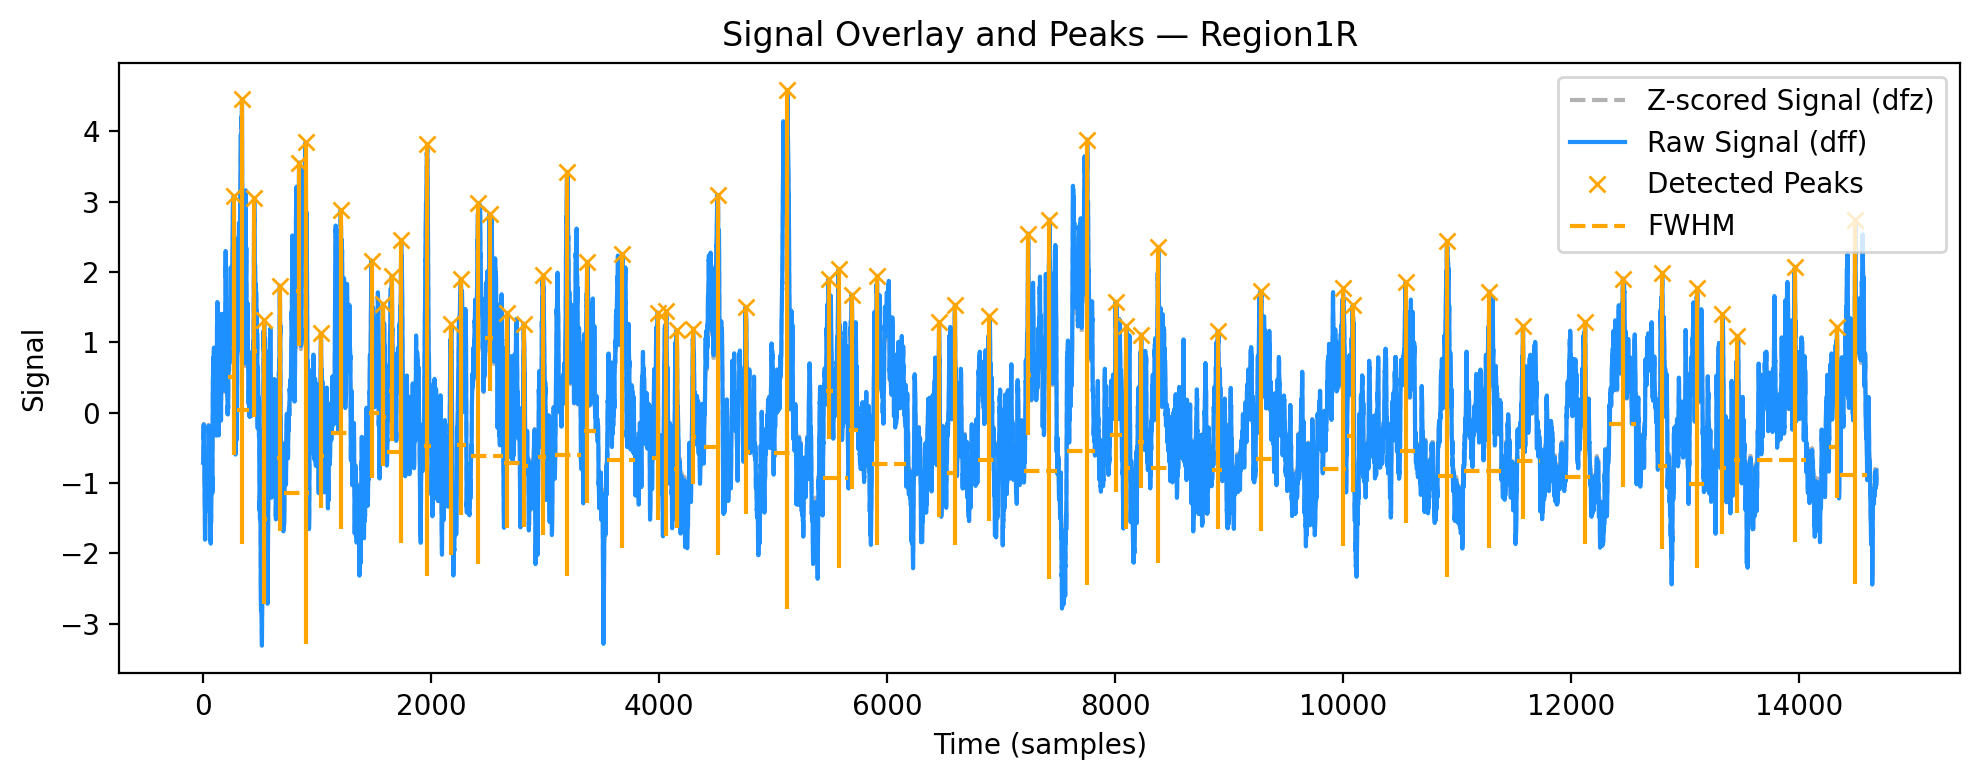

In [18]:
%matplotlib qt
visual_check_peaks2(FP1_OB2_EZM,'Region1R')


In [68]:
def collect_event_summaries_byregion(collection, region, signal_type='dfz_signals', attr_suffix='region_type_peaks'):
    """
    Aggregates peak event information (AUC, amplitude, FWHM, etc.) from each curve in a collection for a given region.

    Args:
        collection (FiberPhotometryCollection): your fp_collection.
        region (str): Region name (e.g., 'Region2G').
        signal_type (str): Signal type (default 'dfz_signals').
        attr_suffix (str): Attribute suffix (default 'region_type_peaks').

    Returns:
        pd.DataFrame: Long-form DataFrame with all event metrics across curves.
    """
    all_events = []

    for ID, curve in collection.curves.items():
        attr_name = f"{signal_type}_{attr_suffix}"
        if not hasattr(curve, attr_name):
            print(f"Warning: {attr_name} not found on {ID}. Skipping.")
            continue

        region_peaks = getattr(curve, attr_name).get(region)
        if region_peaks is None:
            print(f"Warning: Region {region} not found for {ID}. Skipping.")
            continue

        n_events = len(region_peaks['peaks'])
        if n_events == 0:
            continue

        df = pd.DataFrame({
            "ID": [ID] * n_events,
            "Peak_Index": region_peaks['peaks'],
            "Amplitude": region_peaks['amplitudes'],
            "AUC": region_peaks['areas_under_curve'],
            "FWHM": region_peaks['widths'],
            "Prominence": region_peaks['prominences'],
            "Left_IP": region_peaks['left_ips'],
            "Right_IP": region_peaks['right_ips'],
            "Width_Height": region_peaks['width_heights'],
        })

        # Add metadata
        df["task"] = getattr(curve, "task", "Unknown")
        df["treatment"] = getattr(curve, "treatment", "Unknown")
        df["n_frames"] = getattr(curve, "fp_df", pd.DataFrame()).shape[0]  # <-- frame count

        all_events.append(df)

    if not all_events:
        print("No events found.")
        return pd.DataFrame()

    return pd.concat(all_events, ignore_index=True).infer_objects()


# === Collect regions ===
events_vCA1_astros_new = collect_event_summaries_byregion(fp_collection_fc, "Region3G")
events_mPFC_astros_new = collect_event_summaries_byregion(fp_collection_fc, "Region2G")
events_vCA1_neurons_new = collect_event_summaries_byregion(fp_collection_fc, "Region1R")
events_mPFC_neurons_new = collect_event_summaries_byregion(fp_collection_fc, "Region0R")

# === Group and summarize ===
columns_to_average = ['Amplitude', 'AUC', 'FWHM', 'Width_Height', 'Prominence']

def summarize_events(df):
    if df.empty:
        return df
    df_mean = (
        df.groupby(['ID', 'task', 'treatment', 'n_frames'])[columns_to_average]
        .agg(['mean', 'count'])
        .reset_index()
    )
    return df_mean


events_vCA1_astros_mean = summarize_events(events_vCA1_astros_new)
events_vCA1_neurons_mean = summarize_events(events_vCA1_neurons_new)
events_mPFC_astros_mean = summarize_events(events_mPFC_astros_new)
events_mPFC_neurons_mean = summarize_events(events_mPFC_neurons_new)

# === Export all ===

print("✅ Saved all regional event summaries with treatment and n_frames columns included.")


✅ Saved all regional event summaries with treatment and n_frames columns included.


In [113]:
with open("EZM_all_dff.pkl", "wb") as f:
    pickle.dump(fp_collection_fc, f)

In [1]:
import pickle
with open("EZM_all_dff.pkl", "rb") as f:
    fp_collection_fc = pickle.load(f)

    # Make each curve its own variable
globals().update(fp_collection_fc.curves)

In [67]:
import numpy as np
import pandas as pd

def flatten_peaks_by_behavior_single(
    curve,
    signal_type: str = "dfz_signals",
    attr_suffix: str = "region_type_peaks",
    behavior_key: str = "freeze_vector",
    onset_key: str = "freeze_offsets",
    offset_key: str = "freeze_onsets",
) -> pd.DataFrame:
    """
    For one FiberPhotometryCurve:

      - Uses precomputed filtered struggle bouts:
            behavioral_data[onset_key], behavioral_data[offset_key]
      - Builds struggle_mask over frames.
      - For neuron regions (0R/1R): BehaviorState from peak index.
        For astro regions (G):      BehaviorState from left_ips index.
      - Adds n_frames = number of frames spent in that state for this curve.

    Returns a long DataFrame with one row per peak.
    """
    attr_name = f"{signal_type}_{attr_suffix}"
    if not hasattr(curve, attr_name):
        print(f"⚠️ {attr_name} not found on {getattr(curve, 'ID', 'Unknown')}. Skipping.")
        return pd.DataFrame()

    peaks_dict = getattr(curve, attr_name)

    behavior = np.asarray(curve.behavioral_data.get(behavior_key, []), dtype=int)
    if behavior.size == 0:
        print(f"⚠️ No behavior data for {getattr(curve, 'ID', 'Unknown')}. Skipping.")
        return pd.DataFrame()

    n_frames = behavior.size

    # --- build struggle mask from stored filtered bouts ---
    onsets = np.asarray(curve.behavioral_data.get(onset_key, []), dtype=int)
    offsets = np.asarray(curve.behavioral_data.get(offset_key, []), dtype=int)

    struggle_mask = np.zeros(n_frames, dtype=bool)
    for on, off in zip(onsets, offsets):
        if off < 0:
            off = n_frames
        on = max(0, min(on, n_frames))
        off = max(0, min(off, n_frames))
        if on < off:
            struggle_mask[on:off] = True

    n_frames_behavior = {
        0: int((~struggle_mask).sum()),
        1: int(struggle_mask.sum()),
    }

    ID        = getattr(curve, "ID", "Unknown")
    task      = getattr(curve, "task", "Unknown")
    treatment = getattr(curve, "treatment", "Unknown")

    all_rows = []

    for region, metrics in peaks_dict.items():
        peaks    = np.asarray(metrics.get("peaks", []), dtype=int)
        left_ips = np.asarray(metrics.get("left_ips", []), dtype=int)
        left_bases = np.asarray(metrics.get("left_bases", []), dtype=int)

        if peaks.size == 0:
            continue

        # index used to read behavior:
        if "G" in region:
            idx_for_behavior = left_ips
        else:
            idx_for_behavior = peaks

        behavior_state = []
        for idx in idx_for_behavior:
            if 0 <= idx < n_frames:
                behavior_state.append(int(struggle_mask[idx]))
            else:
                behavior_state.append(np.nan)

        # ensure matching length to peaks
        n_rows = peaks.size
        if len(behavior_state) != n_rows:
            behavior_state = (behavior_state + [np.nan] * n_rows)[:n_rows]

        df_region = pd.DataFrame({
            "ID":        [ID] * n_rows,
            "task":      [task] * n_rows,
            "treatment": [treatment] * n_rows,
            "Region":    [region] * n_rows,
            "BehaviorState": behavior_state,
            "Peak_Index":    peaks,
            "Amplitude":     metrics.get("amplitudes",    [np.nan] * n_rows),
            "AUC":           metrics.get("areas_under_curve", [np.nan] * n_rows),
            "FWHM":          metrics.get("widths",        [np.nan] * n_rows),
            "Prominence":    metrics.get("prominences",   [np.nan] * n_rows),
            "Left_IP":       metrics.get("left_ips",      [np.nan] * n_rows),
            "Right_IP":      metrics.get("right_ips",     [np.nan] * n_rows),
            "Width_Height":  metrics.get("width_heights", [np.nan] * n_rows),
        })

        # add n_frames for that behavior state
        df_region["n_frames"] = df_region["BehaviorState"].map(n_frames_behavior)

        # keep only 0/1
        df_region = df_region[df_region["BehaviorState"].isin([0, 1])]

        if not df_region.empty:
            all_rows.append(df_region)

    if not all_rows:
        return pd.DataFrame()

    return pd.concat(all_rows, ignore_index=True)
def flatten_peaks_by_behavior_collection(
    collection,
    **kwargs,   # passed to flatten_peaks_by_behavior_single
) -> pd.DataFrame:
    dfs = []
    for ID, curve in collection.curves.items():
        df_curve = flatten_peaks_by_behavior_single(curve, **kwargs)
        if not df_curve.empty:
            dfs.append(df_curve)
    if not dfs:
        print("⚠️ No peaks found in collection.")
        return pd.DataFrame()
    return pd.concat(dfs, ignore_index=True).infer_objects()
all_peaks = flatten_peaks_by_behavior_collection(fp_collection_fc)
columns_to_average = ['Amplitude', 'AUC', 'FWHM', 'Width_Height', 'Prominence']

def summarize_events_by_behavior(df):
    if df.empty:
        return df
    return (
        df.groupby(['ID', 'task', 'treatment', 'Region',
                    'BehaviorState', 'n_frames'])[columns_to_average]
          .agg(['mean', 'count'])
          .reset_index()
    )

# one big flattened DF
all_peaks = flatten_peaks_by_behavior_collection(fp_collection_fc)

# region-specific subsets
events_vCA1_astros   = all_peaks[all_peaks["Region"] == "Region3G"]
events_mPFC_astros   = all_peaks[all_peaks["Region"] == "Region2G"]
events_vCA1_neurons  = all_peaks[all_peaks["Region"] == "Region1R"]
events_mPFC_neurons  = all_peaks[all_peaks["Region"] == "Region0R"]

events_vCA1_astros_mean   = summarize_events_by_behavior(events_vCA1_astros)
events_vCA1_neurons_mean  = summarize_events_by_behavior(events_vCA1_neurons)
events_mPFC_astros_mean   = summarize_events_by_behavior(events_mPFC_astros)
events_mPFC_neurons_mean  = summarize_events_by_behavior(events_mPFC_neurons)

# save


In [57]:
# --- robust curves_by_id builder for EZM ---
def build_curves_by_id_ezm(events_by_group, namespace=None):
    if namespace is None:
        namespace = globals()

    curves_by_id = {}

    # extract every mouse ID
    for (treatment, region), entries in events_by_group.items():
        for mouse_name, _ in entries:

            # possible variable name patterns
            candidate_names = [
                f"{mouse_name}_EZM",
                f"{mouse_name}_ezm",
                f"{mouse_name}_Ezm",
                f"{mouse_name.lower()}_EZM",
                f"{mouse_name.lower()}_ezm",
            ]

            found = None
            for cname in candidate_names:
                if cname in namespace:
                    found = namespace[cname]
                    break

            if found is None:
                print(f"⚠️ Could NOT find curve object for mouse {mouse_name} (tried {candidate_names})")
            else:
                curves_by_id[mouse_name] = found

    print(f"Loaded {len(curves_by_id)} mice into curves_by_id")
    return curves_by_id

# Build it
curves_by_id = build_curves_by_id_ezm(events_by_group)
curves_by_id

Loaded 60 mice into curves_by_id


{'FP_C1': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa278ba6e90>,
 'FP_C2': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa2292eb610>,
 'FP1_B1': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa2690fcd90>,
 'FP1_D1': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa239a5aec0>,
 'FP1_D2': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa239aae950>,
 'FP3_H1': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa27a6047f0>,
 'FP3_H2': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa27af1ac20>,
 'FP3_J1': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa23ae3d0f0>,
 'FP3_J2': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa23ae8c400>,
 'FP4_L1': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa21ac017e0>,
 'FP4_L2': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa21ac48460>,
 'FP4_M1': <photonsoup.FiberPhotometry.FiberPhotometryCurve at 0x7fa21ac99810>,
 'FP4_M2': <photonsoup.FiberPhotometry.Fib

In [13]:
def plot_group_events(events_by_group, curves_by_id,
                      treatment, region,
                      signal_attr="dfz_signals"):
    """
    For a given (treatment, region) key in events_by_group:
      - loop over mice
      - pull the corresponding curve object
      - get its time, signal, and filtered struggle onsets/offsets
      - plot signal with event segments highlighted.
    """
    key = (treatment, region)
    if key not in events_by_group:
        print(f"No events found for {key}")
        return

    entries = events_by_group[key]  # list of (mouse_id, onset_times_array)

    chan = region_to_channel[region]  # '2' or '4'

    for mouse_id, onset_times_from_dict in entries:
        if mouse_id not in curves_by_id:
            print(f"⚠️ Mouse {mouse_id} not in curves_by_id, skipping.")
            continue

        curve = curves_by_id[mouse_id]

        # time axis for this region
        time = curve.Timestamps[chan]
        # signal for this region (dfz_signals['Region3G'], etc.)
        signal = getattr(curve, signal_attr)[region]

        # use the *indices* already computed for this mouse
        onset_idx  = curve.behavioral_data["freeze_offsets"]
        offset_idx = curve.behavioral_data["freeze_onsets"]

        onset_times  = time[onset_idx]
        offset_times = time[offset_idx]

        fig, ax = plt.subplots(figsize=(10, 5))
        plot_event_with_markers(time, signal, onset_times, offset_times, ax=ax)

        ax.set_title(f"{treatment} – {region} – {mouse_id}")
        plt.tight_layout()
        plt.show()


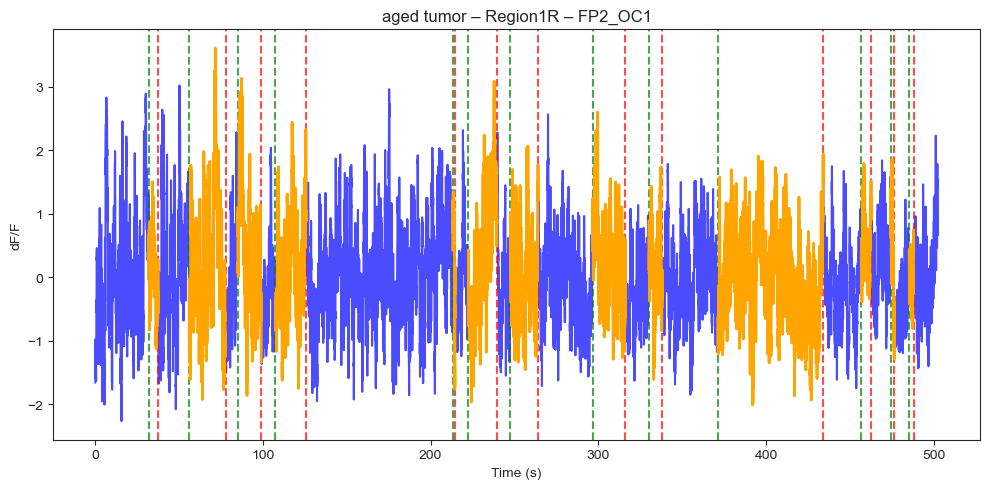

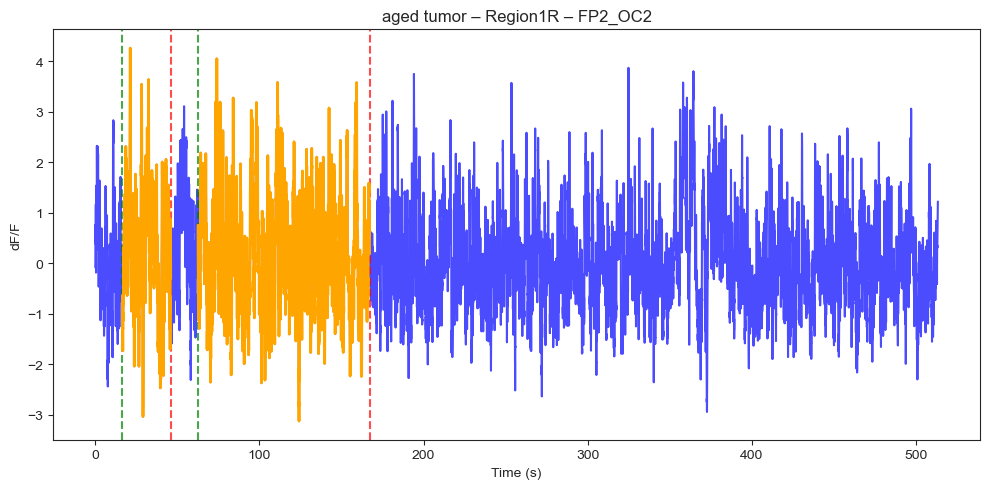

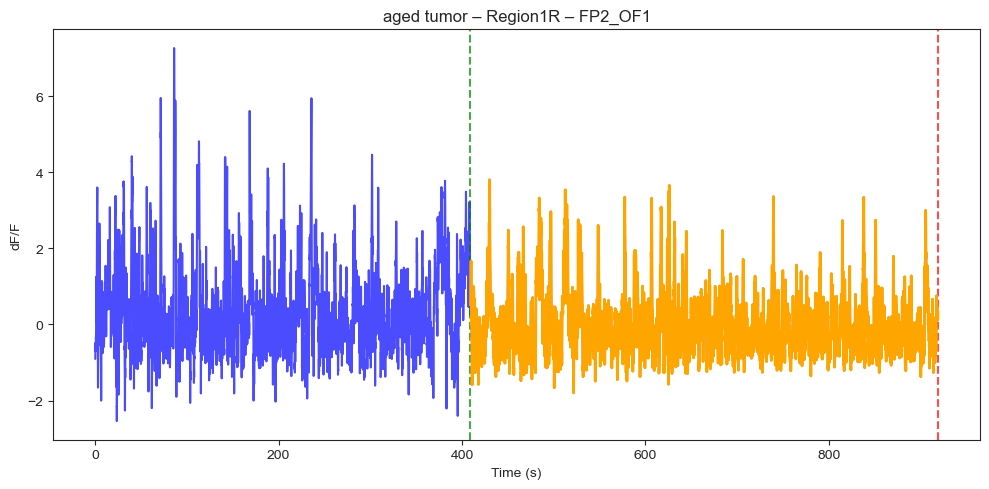

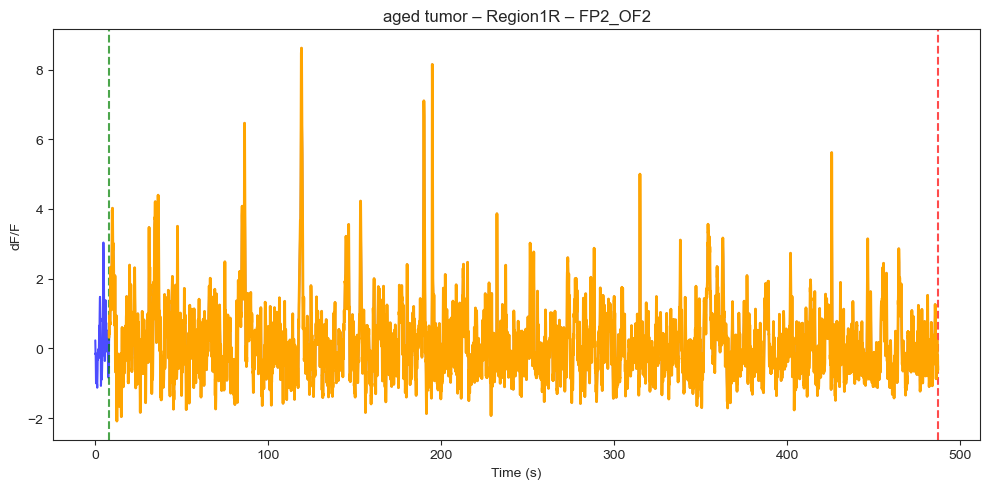

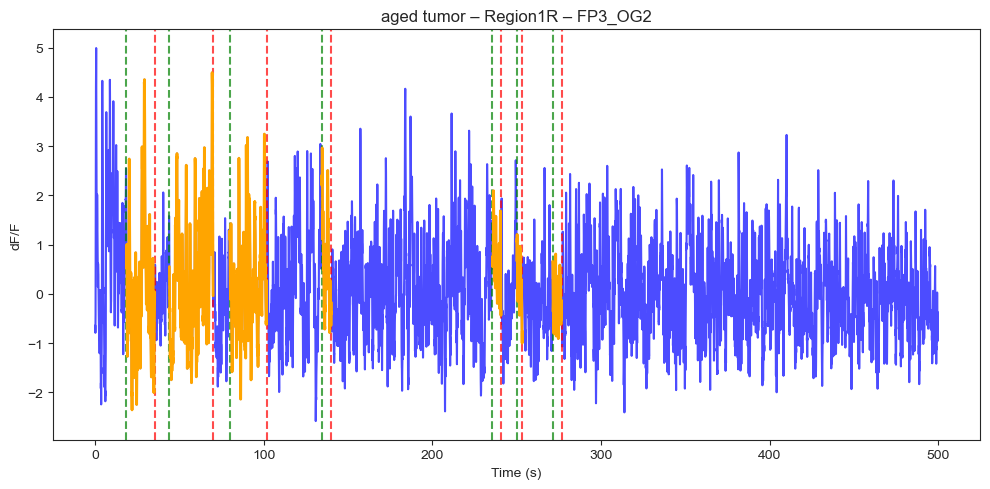

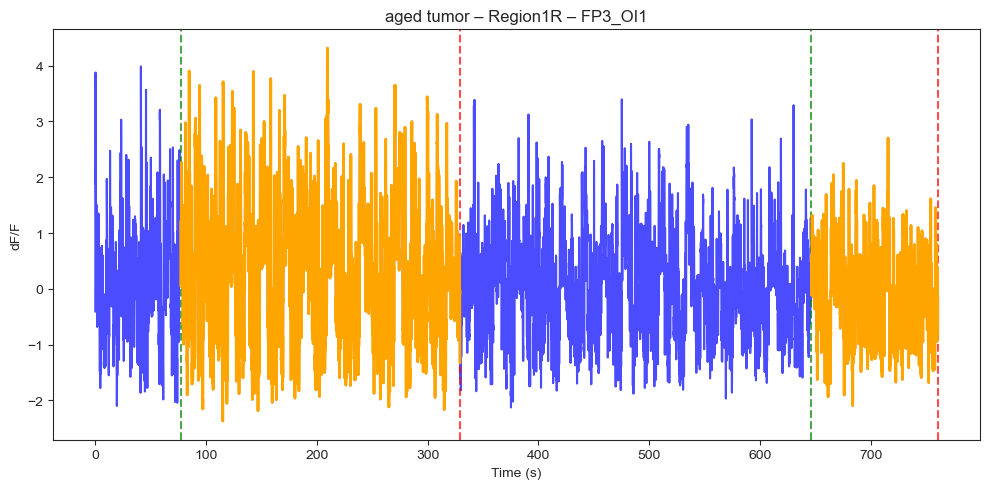

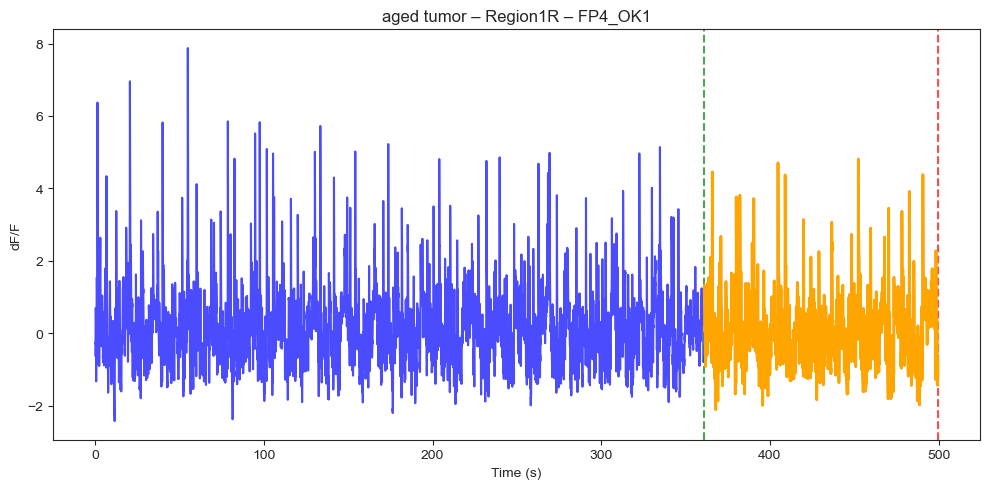

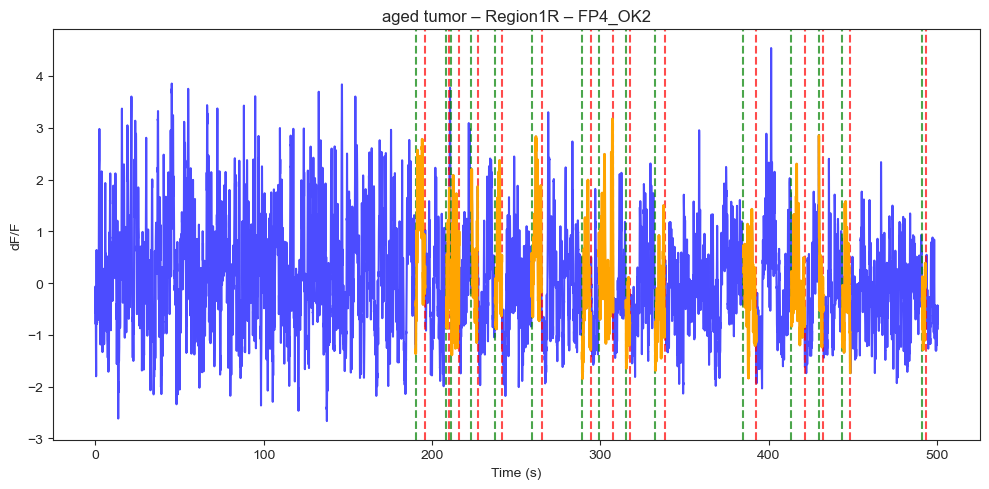

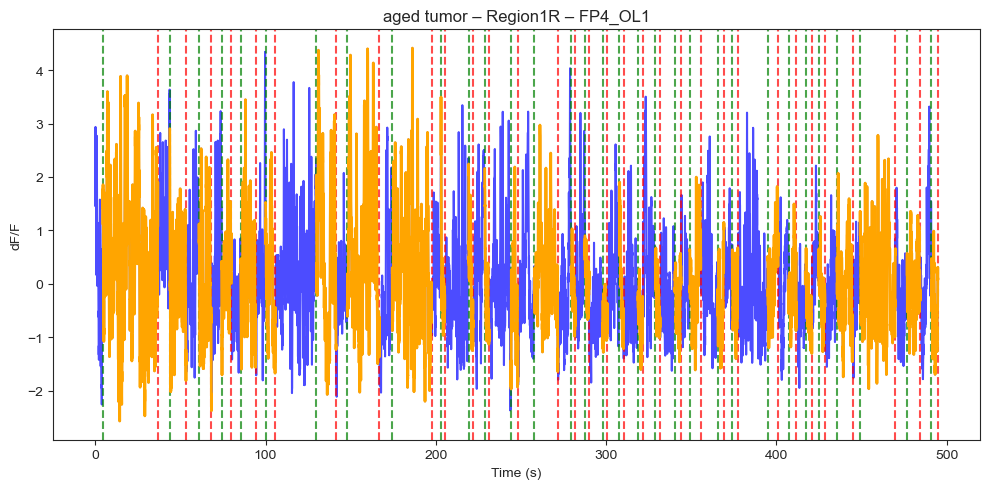

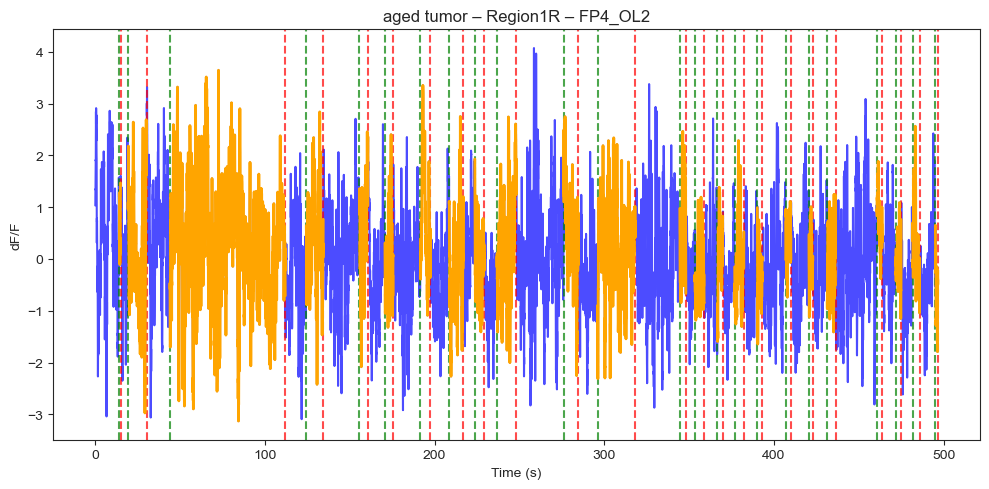

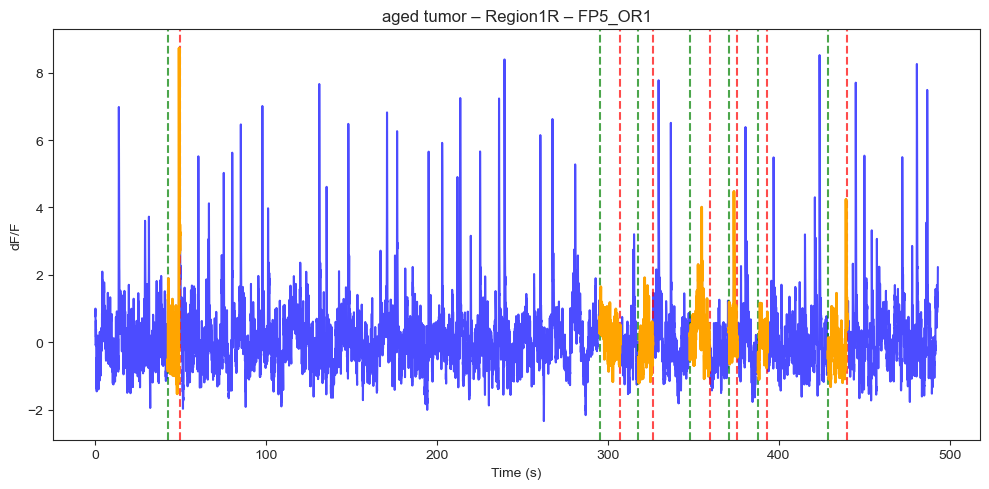

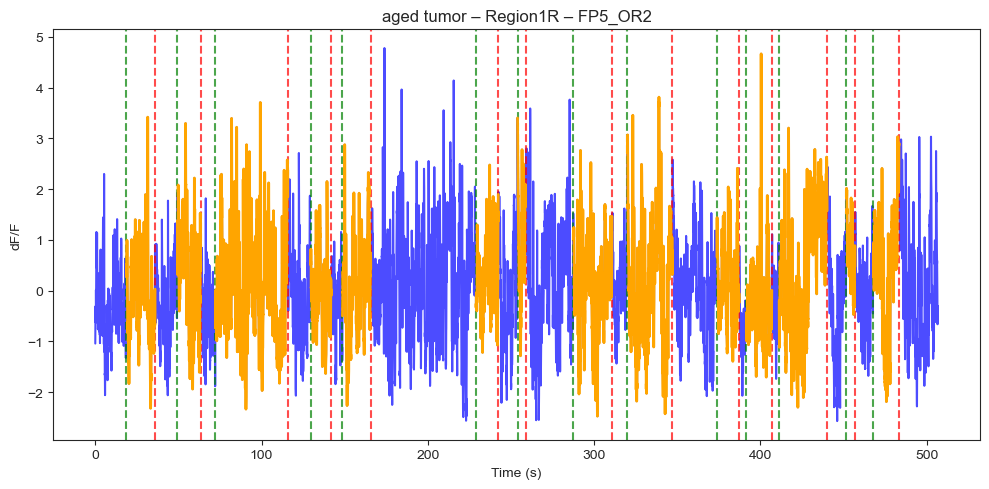

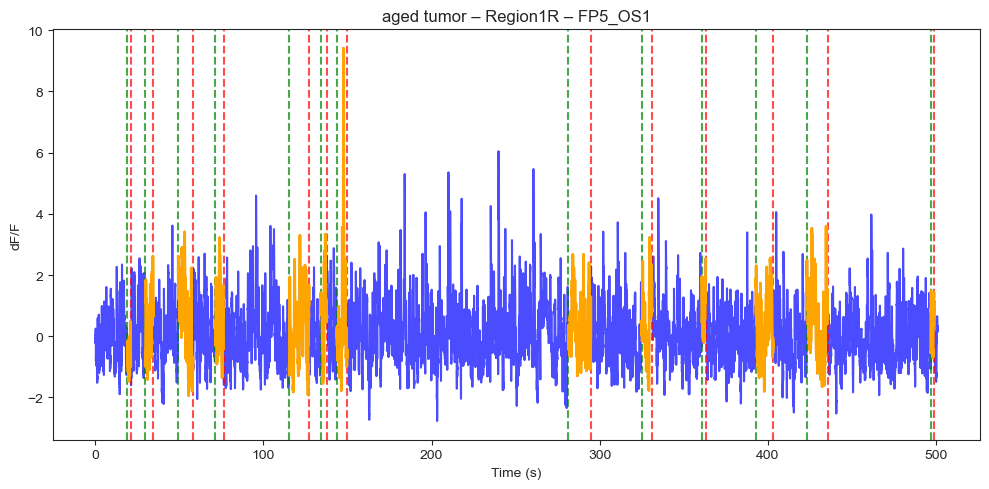

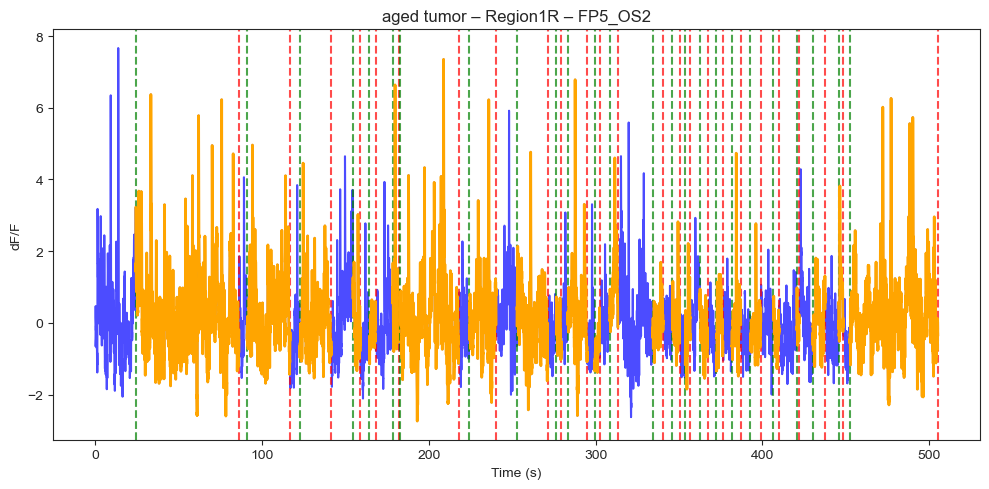

In [58]:
%matplotlib inline
plot_group_events(
    events_by_group=events_by_group,
    curves_by_id=curves_by_id,
    treatment="aged tumor",
    region="Region1R"
)

In [150]:
import numpy as np
import scipy.interpolate
from scipy.signal import find_peaks
import scipy.ndimage as ndi
import matplotlib.pyplot as plt


def peak_latency_from_curve_records(
    curve_records,
    regionA: str,
    regionB: str,
    fs: float = 30.0,
    window: float = 15.0,
    search_start: float = 0.0,
    search_end: float | None = 10.0,   # kept for API compatibility, but region-specific ends override it
    astro_peak: str = "max",          # 'max' | 'min' | 'abs' for astro regions
    smooth_sigma_s: float | None = 0.2,
    min_rest_sec: float = 0.0,
    min_dur_sec: float = 0.0,
    treatments_order: list[str] | None = None,
    ax: plt.Axes | None = None,
    jitter: float = 0.06,
    width_s_range: tuple[float, float] | None = (1, 15),  # not used now; region-specific widths below
):
    """
    Peak latency Δ (regionA − regionB) using events + signals from curve_records.

    Peak/width logic matches plot_peak_ips_for_mouse:
      - Peak is searched in a CROPPED window [search_start, region_search_end]
        (region_search_end = 12 s for astro, 5 s for neurons).
      - HWHM / left_ips is computed on the FULL ETA (full time_rel).
      - Bases for peak_widths come from find_bases_after_steepest_descent
        applied to the full, mode-transformed signal.
    """

    # ---------- helpers for region type ----------
    def _is_neuron_region(region: str) -> bool:
        r = str(region)
        return ("0R" in r) or ("1R" in r)

    def _peak_mode_for(region: str) -> str:
        # Neurons always 'max'; astro uses astro_peak arg
        return "max" if _is_neuron_region(region) else astro_peak

    # ---------- index curve_records by (treatment, mouse, region) ----------
    by_tm_r = {}
    for rec in curve_records:
        t = rec["treatment"]
        m = rec["mouse"]
        r = rec["region"]
        by_tm_r.setdefault(t, {}).setdefault(m, {})[r] = rec

    # Treatments order
    if treatments_order is None:
        treatments = sorted(by_tm_r.keys())
    else:
        treatments = [t for t in treatments_order if t in by_tm_r]

    # Time axis for ETA
    n_indices = int(window * 1.5 * fs)
    time_rel = np.linspace(-window/2, window, n_indices)

    # ---------- ETA builder ----------
    def subject_eta(rec, event_times):
        """Average ETA trace for one mouse/region given event times (sec)."""
        if event_times is None or len(event_times) == 0:
            return None

        signal = np.asarray(rec["signal"], dtype=float)
        n = len(signal)
        t_full = np.arange(n) / fs

        interp = scipy.interpolate.interp1d(
            t_full,
            signal,
            kind="cubic",
            bounds_error=False,
            fill_value=np.nan
        )

        within = np.zeros((len(event_times), n_indices), float)
        for i, ev in enumerate(event_times):
            tp = np.linspace(ev - (window/2), ev + window, n_indices)
            within[i] = interp(tp)
        return np.nanmean(within, axis=0)

    # ---------- peak latency from ETA using FULL-width HWHM ----------
    def eta_peak_latency(eta: np.ndarray, region: str) -> float | None:
        """
        Match compute_ips from plot_peak_ips_for_mouse:

          1) Smooth FULL eta (region-dependent sigma).
          2) Restrict *peak search* to [search_start, region_search_end]
             (12 s astro, 5 s neurons).
          3) Pick peak:
                - astro: highest peak in window
                - neuron: peak closest to 0 s
          4) Use FULL eta/time_rel for peak_widths with
             find_bases_after_steepest_descent on the full signal.
        """
        if eta is None or not np.isfinite(eta).any():
            return None

        # 1) smooth FULL eta
        if smooth_sigma_s and smooth_sigma_s > 0:
            if "G" in region:   # astro: heavier smoothing
                sigma = 1.0 * fs
            else:               # neurons: user-specified
                sigma = smooth_sigma_s * fs
            eta_full = ndi.gaussian_filter1d(eta, sigma=sigma, mode="nearest")
        else:
            eta_full = np.asarray(eta, float)

        # 2) region-specific search window (for peak search only)
        if "G" in region:       # astrocytes
            region_search_end = 12.0
        else:                   # neurons
            region_search_end = 5.0

        if "G" in region:
            mask_search = (time_rel >= 0) & (time_rel <= region_search_end)
        else:
            mask_search = (time_rel >= search_start) & (time_rel <= region_search_end)
        if not np.any(mask_search):
            return None

        tw_search  = time_rel[mask_search]
        eta_search = eta_full[mask_search]
        if tw_search.size < 3:
            return None

        # 3) choose signal for PEAK DETECTION (cropped)
        mode = _peak_mode_for(region)
        if mode == "max":
            y_search = eta_search
        elif mode == "min":
            y_search = -eta_search
        elif mode == "abs":
            y_search = np.abs(eta_search)
        else:
            raise ValueError("astro_peak must be 'max','min','abs'")

        dy = np.diff(y_search)
        cand = np.where((dy[:-1] > 0) & (dy[1:] <= 0))[0] + 1

        # peak selection rule
        if "G" in region:
            # ASTRO: highest max in window
            if cand.size == 0:
                peak_idx_search = int(np.argmax(y_search))
            else:
                peak_idx_search = int(cand[np.argmax(y_search[cand])])
        else:
            # NEURON: peak closest to 0 s
            if cand.size == 0:
                peak_idx_search = int(np.argmax(y_search))
            else:
                peak_times = tw_search[cand]
                # best = int(np.argmin(np.abs(peak_times - 0.0)))
                # peak_idx_search = int(cand[best])
                peak_idx_search = int(np.argmax(y_search))


        # map peak index from CROPPED → FULL
        search_indices = np.where(mask_search)[0]
        peak_idx_full  = int(search_indices[peak_idx_search])
        peak_time      = time_rel[peak_idx_full]  # not used in Δ but kept for debugging

        # 4) build FULL detection signal y_full
        if mode == "max":
            y_full = eta_full
        elif mode == "min":
            y_full = -eta_full
        elif mode == "abs":
            y_full = np.abs(eta_full)

        # custom bases from full signal
        left_base_idx, right_base_idx, prominence = find_bases_after_steepest_descent(
            y_full, peak_idx_full
        )

        prominences = np.array([prominence], dtype=float)
        left_bases  = np.array([left_base_idx], dtype=int)
        right_bases = np.array([right_base_idx], dtype=int)
        prom_data   = (prominences, left_bases, right_bases)

        if time_rel.size < 2:
            return None

        dt_full = time_rel[1] - time_rel[0]

        widths, height, l_ips, r_ips = peak_widths(
            y_full,
            [peak_idx_full],
            rel_height=0.5,
            prominence_data=prom_data,
        )
        left_ip = float(l_ips[0])

        latency_left = time_rel[0] + peak_idx_full * dt_full
        return float(latency_left)

    # ---------- per-treatment → per-mouse deltas ----------
    group_deltas = {}
    group_labels = {}

    for t in treatments:
        mice_dict = by_tm_r.get(t, {})
        deltas = []
        labels = []

        for mouse_id, regions_dict in mice_dict.items():
            if regionA not in regions_dict or regionB not in regions_dict:
                continue

            recA = regions_dict[regionA]
            recB = regions_dict[regionB]

            behavior = np.asarray(recA["behavior"]).astype(int)

            # define events
            onsets, offsets = get_onsets_offsets(
                behavior
            )
            if len(onsets) == 0:
                continue

            event_times = onsets / fs  # event times in sec

            # ETA for each region
            etaA = subject_eta(recA, event_times)
            etaB = subject_eta(recB, event_times)

            latA = eta_peak_latency(etaA, regionA)
            latB = eta_peak_latency(etaB, regionB)
            if latA is None or latB is None:
                continue

            deltas.append(latA - latB)
            labels.append(mouse_id)

        if deltas:
            group_deltas[t] = np.asarray(deltas, dtype=float)
            group_labels[t] = labels

    if not group_deltas:
        raise ValueError("No valid mice/events found for any treatment.")

    # ---------- plotting ----------
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    else:
        fig = ax.figure

    x_positions = np.arange(len(treatments), dtype=float)
    colors = plt.cm.tab10(np.linspace(0, 1, len(treatments)))
    means = []
    sems = []

    for i, t in enumerate(treatments):
        vals = group_deltas.get(t, None)
        if vals is None:
            means.append(np.nan)
            sems.append(0.0)
            continue
        m = np.nanmean(vals)
        se = np.nanstd(vals, ddof=1) / np.sqrt(vals.size) if vals.size > 1 else 0.0
        means.append(m)
        sems.append(se)

    ax.bar(
        x_positions, means, yerr=sems,
        color=colors, alpha=0.65,
        edgecolor="k", linewidth=0.5,
        tick_label=treatments
    )

    rng = np.random.default_rng(42)
    for i, t in enumerate(treatments):
        vals = group_deltas.get(t, None)
        if vals is None:
            continue
        xs = x_positions[i] + rng.uniform(-jitter, jitter, size=vals.size)
        ax.scatter(
            xs, vals,
            s=30, edgecolor="k", linewidth=0.3,
            color=colors[i], alpha=0.9, zorder=3
        )

    ax.axhline(0, ls="--", c="k", lw=1)
    ax.set_ylabel(f"Peak latency Δ ({regionA} − {regionB}) [s]")
    ax.set_title("Peak latency difference by treatment (left_ips-based)")
    ax.set_xlim(-0.6, len(treatments) - 0.4)

    out = {
        "group_deltas": group_deltas,
        "group_labels": group_labels,
        "treatments": treatments,
        "fig": fig,
        "ax": ax,
        "params": {
            "regionA": regionA,
            "regionB": regionB,
            "fs": fs,
            "window": window,
            "search_start": search_start,
            "search_end": search_end,  # kept for bookkeeping
            "astro_peak": astro_peak,
            "smooth_sigma_s": smooth_sigma_s,
            "width_s_range": width_s_range,
        }
    }
    return out


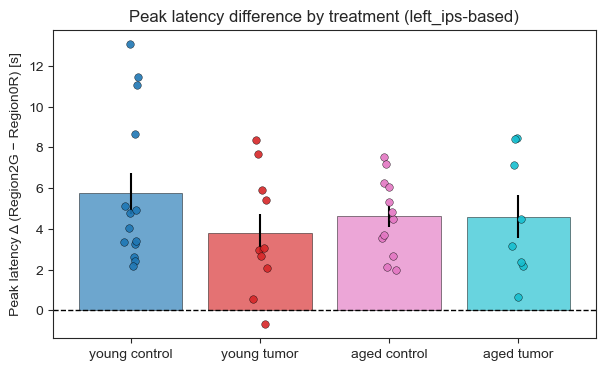

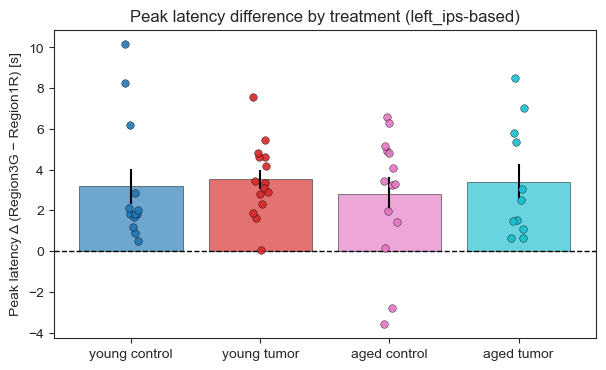

In [151]:
treatments_order = [
    "young control",
    "young tumor",
    "aged control",
    "aged tumor"
]

res_mPFC_peak = peak_latency_from_curve_records(
    curve_records,
    regionA="Region2G", regionB="Region0R",
    fs=30,
    window=20,
    search_start=-2,
    search_end=10,
    astro_peak="max",         # astro = minima
    smooth_sigma_s=0.5,
    treatments_order=treatments_order,
    jitter=0.06,
)
plt.show()

res_vCA1_peak = peak_latency_from_curve_records(
    curve_records,
    regionA="Region3G", regionB="Region1R",
    fs=30,
    window=20,
    search_start=-2,
    search_end=10,
    astro_peak="max",
    smooth_sigma_s=0.5,
    treatments_order=treatments_order,
    jitter=0.06,
)

plt.show()


In [152]:
import pandas as pd

# Build a long-form table
rows = []
for treatment, deltas in res_mPFC_peak["group_deltas"].items():
    labels = res_mPFC_peak["group_labels"][treatment]
    for mouse_id, delta_val in zip(labels, deltas):
        rows.append({
            "Treatment": treatment,
            "Mouse": mouse_id,
            "DeltaLatency": delta_val
        })

df_mPFC = pd.DataFrame(rows)

# Save to CSV
df_mPFC.to_csv("EZM_peaklatency_mPFC.csv", index=False)
print("Saved TST_peaklatency_mPFC.csv")

rows = []
for treatment, deltas in res_vCA1_peak["group_deltas"].items():
    labels = res_vCA1_peak["group_labels"][treatment]
    for mouse_id, delta_val in zip(labels, deltas):
        rows.append({
            "Treatment": treatment,
            "Mouse": mouse_id,
            "DeltaLatency": delta_val
        })

df_mPFC = pd.DataFrame(rows)

# Save to CSV
df_mPFC.to_csv("EZM_peaklatency_vCA1.csv", index=False)
print("Saved TST_peaklatency_vCA1_new.csv")


Saved TST_peaklatency_mPFC.csv
Saved TST_peaklatency_vCA1_new.csv


In [57]:
import pandas as pd
import numpy as np
import scipy
import re
def multi_event_eta_summary(self, task, treatment, region, events_dict, window=3, ci='tci', sig_duration=8, a=0.05):
    number_of_indices = int((window+5) * 30)
    time_idx = "2" if "G" in region else "4"

    def event_interpolation_summary(curve, events_):
        within_eta_ = np.zeros((len(events_), number_of_indices))
        interp = scipy.interpolate.interp1d(
            curve.Timestamps[time_idx],
            curve.dfz_signals[region],
            kind='cubic',
            bounds_error=False,
            fill_value=np.nan
        )
        for i, event in enumerate(events_):
            time_period = np.linspace(event-5, event + window, number_of_indices)
            within_eta_[i] = interp(time_period)
        return np.nanmean(within_eta_, axis=0)

    results = []
    for curve in self[task, treatment]:
        base_id = re.sub(r'_ezm$', '', curve.ID, flags=re.IGNORECASE)

        if base_id not in events_dict:
            continue
        evs = events_dict[base_id]
        if len(evs) == 0:
            continue

        eta_trace = event_interpolation_summary(curve, evs)
        auc_val = np.trapz(abs(eta_trace))
        max_val = np.nanmax(np.abs(eta_trace))
        results.append((curve.ID, auc_val, max_val))

    return results


# -------------------------------
# Build results across groups
# -------------------------------
all_auc_results = []

for (treatment, region), mouse_events in events_by_group.items():
    # mouse_events is a list of (mouse_name, event_times)
    events_dict = {name: ev for name, ev in mouse_events}

    results = multi_event_eta_summary(
        fp_collection_fc, task="EZM", treatment=treatment, region=region,
        events_dict=events_dict, window=15, ci="tci", sig_duration=30, a=0.05
    )

    for curve_id, auc_val, max_val in results:
        base_name = re.sub(r'_ezm$', '', curve.ID, flags=re.IGNORECASE)
        all_auc_results.append({
            "Treatment": treatment,
            "Region": region,
            "Mouse": base_name,
            "CurveID": curve_id,
            "AUC": auc_val,
            "Max Amplitude": max_val
        })

# make a tidy DataFrame
df_auc = pd.DataFrame(all_auc_results)
output_path = "/Users/heloiseleblanc/Documents/AUC_EZM_summary_withMax_new.csv"
df_auc.to_csv(output_path, index=False)

print(f"Saved summary with {len(df_auc)} rows to {output_path}")
print(df_auc.head())


Saved summary with 205 rows to /Users/heloiseleblanc/Documents/AUC_EZM_summary_withMax_new.csv
       Treatment    Region    Mouse     CurveID         AUC  Max Amplitude
0  young control  Region3G  FP5_OS2   FP_C1_EZM  199.343727       0.961497
1  young control  Region3G  FP5_OS2   FP_C2_EZM   98.479164       0.640768
2  young control  Region3G  FP5_OS2  FP1_B1_EZM  301.634775       1.145283
3  young control  Region3G  FP5_OS2  FP1_D1_EZM  168.662090       0.672760
4  young control  Region3G  FP5_OS2  FP1_D2_EZM  163.683582       0.751177


In [177]:
import pandas as pd
import numpy as np
from scipy.signal import correlate, correlation_lags

# --- helpers ---
def correlation(x, y):
    n = min(x.shape[0], y.shape[0])
    return np.corrcoef(x.iloc[:n].values, y.iloc[:n].values)[0, 1]

def is_neuron(r): return ("0R" in str(r)) or ("1R" in str(r))
def is_astro(r):  return "G" in str(r)

def shift_for_maximum_correlation(x, y, lag_min=None, lag_max=None, require_bestlag_sign=None):
    """
    Find best lag within a specific lag range [lag_min, lag_max].
    BestLag reported as -lag (so BestLag>0 means y lags x).

    require_bestlag_sign:
        None  -> no sign constraint
        'pos' -> require BestLag>0  => lag < 0
        'neg' -> require BestLag<0  => lag > 0
    """
    xa = np.asarray(x, dtype=float)
    ya = np.asarray(y, dtype=float)

    corr = correlate(xa, ya, mode="full")
    lags = correlation_lags(xa.size, ya.size, mode="full")

    # restrict to [lag_min, lag_max] if provided
    mask = np.ones_like(lags, dtype=bool)
    if lag_min is not None:
        mask &= (lags >= -lag_max) & (lags <= -lag_min) if lag_min >= 0 else (lags >= lag_min)
    if lag_max is not None:
        mask &= (lags <= lag_max) & (lags >= -lag_max)

    # sign constraint in terms of lag (BestLag = -lag)
    if require_bestlag_sign == 'pos':   # want BestLag > 0 -> lag < 0
        mask &= (lags < 0)
    elif require_bestlag_sign == 'neg': # want BestLag < 0 -> lag > 0
        mask &= (lags > 0)

    if not np.any(mask):
        return x.reset_index(drop=True), y.reset_index(drop=True), np.nan

    limited_lags = lags[mask]
    limited_corr = corr[mask]
    best_lag = limited_lags[np.argmax(limited_corr)]

    # shift
    x_s, y_s = x.copy(), y.copy()
    if best_lag < 0:
        y_s = y_s.iloc[abs(best_lag):].reset_index(drop=True)
    elif best_lag > 0:
        x_s = x_s.iloc[best_lag:].reset_index(drop=True)

    return x_s, y_s, best_lag


# --- per-pair lag limits (frames) ---
PAIR_LAG_BOUNDS = {
    ("Region0R", "Region2G"): (30, 240),   # neuron–astro: min=30, max=300
    ("Region1R", "Region3G"): (30, 240),   # neuron–astro
    ("Region2G", "Region3G"): (0, 60),     # astro–astro
    ("Region0R", "Region1R"): (0, 60),     # neuron–neuron
}
DEFAULT_LAG_BOUNDS = (0, 150)

def lag_bounds_for(a, b):
    return (PAIR_LAG_BOUNDS.get((a, b))
            or PAIR_LAG_BOUNDS.get((b, a))
            or DEFAULT_LAG_BOUNDS)

# --- main loop ---
results = []
region_pairs = [
    ("Region0R", "Region2G"),
    ("Region1R", "Region3G"),
    ("Region2G", "Region3G"),
    ("Region0R", "Region1R"),
]

for curve_id, curve in fp_collection_fc.curves.items():
    for reg_x, reg_y in region_pairs:
        if reg_x not in curve.dfz_signals or reg_y not in curve.dfz_signals:
            continue

        x = pd.Series(curve.dfz_signals[reg_x])
        y = pd.Series(curve.dfz_signals[reg_y])

        lag_min, lag_max = lag_bounds_for(reg_x, reg_y)

        # enforce positive reported lag for neuron–astro pairs
        sign_req = 'pos' if ((is_neuron(reg_x) and is_astro(reg_y)) or
                             (is_neuron(reg_y) and is_astro(reg_x))) else None

        sx, sy, lag = shift_for_maximum_correlation(
            x, y, lag_min=lag_min, lag_max=lag_max, require_bestlag_sign=sign_req
        )

        corr_val = np.nan if np.isnan(lag) else correlation(sx, sy)
        results.append({
            "Mouse": curve_id,
            "Treatment": curve.treatment,
            "RegionX": reg_x,
            "RegionY": reg_y,
            "LagMin": lag_min,
            "LagMax": lag_max,
            "BestLag": -lag,       # positive => y lags x
            "Correlation": corr_val
        })

df_corr = pd.DataFrame(results)
out_path = "/Users/heloiseleblanc/Desktop/lagged_correlations_minlag_EZM.csv"
df_corr.to_csv(out_path, index=False)

print(f"✅ Saved results for {len(df_corr)} entries to {out_path}")
print(df_corr.head())


✅ Saved results for 248 entries to /Users/heloiseleblanc/Desktop/lagged_correlations_minlag_EZM.csv
       Mouse      Treatment   RegionX   RegionY  LagMin  LagMax  BestLag  \
0  FP_C1_EZM  young control  Region0R  Region2G      30     240       73   
1  FP_C1_EZM  young control  Region1R  Region3G      30     240       54   
2  FP_C1_EZM  young control  Region2G  Region3G       0      60        0   
3  FP_C1_EZM  young control  Region0R  Region1R       0      60        1   
4  FP_C2_EZM  young control  Region0R  Region2G      30     240       52   

   Correlation  
0     0.417734  
1     0.367516  
2     0.819964  
3     0.471100  
4     0.075495  
